## Objectif du projet

Ce projet intitulé **"Optimisation de la couverture du risque de change"**, a pour objectif principal de dépasser les approches classiques de gestion du risque en proposant une méthodologie intégrée et complète. L’idée principale est de montrer qu’une stratégie de couverture optimale ne se résume pas au simple choix d’un instrument financier, mais qu’elle repose sur une évaluation dynamique et prospective du risque. Dans cette optique, le projet s’appuie sur trois volets complémentaires: la prévision des taux de change à l’aide de modèles de Machine Learning, la mesure du risque au moyen de modèles économétriques et enfin, la mise en œuvre opérationnelle de la couverture à travers des instruments dérivés comme les options de change. L’approche adoptée vise donc à concevoir des stratégies de couverture sur mesure, non plus basées sur une vision statique du risque, mais calibrées sur une analyse dynamique des conditions de marché futures, permettant de sécuriser les marges tout en préservant des opportunités.

---

## Architecture générale du cadre automatisé de la couverture du risque de change

Le backend du cadre automatisé mis en place pour la couverture du risque de change n'est pas structuré comme des modules indépendants. Son architecture se décompose ainsi en une chaîne de traitement progressive et intégrée, où chaque étape s’appuie sur les résultats de la précédente formant un pipeline complet allant de la prévision initiale à la prise de décision finale.

Pour une compréhension approfondie de son fonctionnement, le schéma ci dessous détaille visuellement l'articulation de ces processus et les flux d’informations qui assurent leur cohérence.

![Architecture du cadre automatisé de la couverture du risque de change](images/schema_backend.png)

---


## Étape 1: Modélisation prédictive des taux de change par machine learning

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import requests
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
start_date = '2000-12-01'
end_date = datetime.today().strftime('%Y-%m-%d')

api_key = "8e877013bcb3862ac90cd864024bdb75"

def download_fred_data(series_id, start_date, end_date):
    url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&observation_start={start_date}&observation_end={end_date}&file_type=json"
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data['observations'])
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.rename(columns={'value': series_id}, inplace=True)
    return df

def process_yield_data(data, column):
    data[column] = pd.to_numeric(data[column], errors='coerce')
    data.index = pd.to_datetime(data.index)
    data.reset_index(inplace=True)
    data['Date'] = pd.to_datetime(data['date'])
    data.drop(columns=['date'], inplace=True)
    data.dropna(inplace=True)
    return data[['Date', column]]

two_year_yield_curve_data = process_yield_data(download_fred_data("DGS2", "1900-01-01", "2025-12-31"), 'DGS2')
time.sleep(2)
ten_year_yield_curve_data = process_yield_data(download_fred_data("DGS10", "1900-01-01", "2025-12-31"), 'DGS10')
time.sleep(2)
five_year_yield_curve_data = process_yield_data(download_fred_data("DGS5", "1900-01-01", "2025-12-31"), 'DGS5')
time.sleep(2)
DCOILWTICO_data = process_yield_data(download_fred_data("DCOILWTICO", "1900-01-01", "2025-12-31"), 'DCOILWTICO')
time.sleep(2)
Volatility_Index = process_yield_data(download_fred_data("VIXCLS", "1900-01-01", "2025-12-31"), 'VIXCLS')

def process_data(data, column):
    data[column] = pd.to_numeric(data[column], errors='coerce')
    data.reset_index(inplace=True)
    data['Date'] = pd.to_datetime(data['date'])
    daily_data = []
    for index, row in data.iterrows():
        month_days = pd.date_range(start=row['Date'], end=row['Date'].replace(day=1) + pd.offsets.MonthEnd(0), freq='D')
        daily_values = [row[column]] * len(month_days)
        daily_data.append(pd.DataFrame({column: daily_values, 'Date': month_days}))
    daily_data_df = pd.concat(daily_data, ignore_index=True)
    daily_data_df.dropna(inplace=True)
    return daily_data_df[[column, 'Date']]

interest_rate_data = process_data(download_fred_data("FEDFUNDS", "1900-01-01", "2025-12-31"), 'FEDFUNDS')
time.sleep(2)
inflation_data = process_data(download_fred_data("CPIAUCNS", "1900-01-01", "2025-12-31"), 'CPIAUCNS')
time.sleep(2)
industrial_orders_data = process_data(download_fred_data("AMTMNO", "1900-01-01", "2025-12-31"), 'AMTMNO')
time.sleep(2)
consumer_sentiment_data = process_data(download_fred_data("UMCSENT", "1900-01-01", "2025-12-31"), 'UMCSENT')
time.sleep(2)
retail_sales_data = process_data(download_fred_data("RSXFS", "1900-01-01", "2025-12-31"), 'RSXFS')
time.sleep(2)
unemployment_rate_data = process_data(download_fred_data("UNRATE", "1900-01-01", "2025-12-31"), 'UNRATE')
time.sleep(2)
M2_Money_Stock_data = process_data(download_fred_data("M2SL", "1900-01-01", "2025-12-31"), 'M2SL')
time.sleep(2)
Producer_Price_Index = process_data(download_fred_data("PPIACO", "1900-01-01", "2025-12-31"), 'PPIACO')
time.sleep(2)
Total_Nonfarm_Payroll = process_data(download_fred_data("PAYEMS", "1900-01-01", "2025-12-31"), 'PAYEMS')
time.sleep(2)
Industrial_Production_Index = process_data(download_fred_data("INDPRO", "1900-01-01", "2025-12-31"), 'INDPRO')
time.sleep(2)
Crude_Petroleum = process_data(download_fred_data("WPU0561", "1900-01-01", "2025-12-31"), 'WPU0561')
time.sleep(2)
pce_data = process_data(download_fred_data("PCE", "1900-01-01", "2025-12-31"), 'PCE')
time.sleep(2)
Manufacturing_Production_data = process_data(download_fred_data("IPMAN", "1900-01-01", "2025-12-31"), 'IPMAN')
time.sleep(2)
House_Price_Index_data = process_data(download_fred_data("CSUSHPISA", "1900-01-01", "2025-12-31"), 'CSUSHPISA')
time.sleep(2)
Commodity_Price_Index_data = process_data(download_fred_data("PALLFNFINDEXM", "1900-01-01", "2025-12-31"), 'PALLFNFINDEXM')
time.sleep(2)
Chicago_Fed_National_Activity_Index_data = process_data(download_fred_data("CFNAI", "1900-01-01", "2025-12-31"), 'CFNAI')
time.sleep(2)
Personal_Income_data = process_data(download_fred_data("PI", "1900-01-01", "2025-12-31"), 'PI')
time.sleep(2)
labor_force_participation_rate_data = process_data(download_fred_data("CIVPART", "1948-01-01", "2025-12-31"), 'CIVPART')
time.sleep(2)
trade_balance_data = process_data(download_fred_data("BOPGSTB", "1960-01-01", "2025-12-31"), 'BOPGSTB')
time.sleep(2)
M1_Money_Stock_data = process_data(download_fred_data("M1SL", "1959-01-01", "2025-12-31"), 'M1SL')
time.sleep(2)
Copper_Price_data = process_data(download_fred_data("PCOPPUSDM", "1983-01-01", "2025-12-31"), 'PCOPPUSDM')
time.sleep(2)
Durable_Goods_Production_Index_data = process_data(download_fred_data("IPDMAN", "1972-01-01", "2025-12-31"), 'IPDMAN')
time.sleep(2)
PCE_Services_data = process_data(download_fred_data("PCES", "1959-01-01", "2025-12-31"), 'PCES')
time.sleep(2)
Consumer_Goods_Production_Index_data = process_data(download_fred_data("IPCONGD", "1972-01-01", "2025-12-31"), 'IPCONGD')
time.sleep(2)
Construction_Materials_Production_Index_data = process_data(download_fred_data("IPB51220N", "1972-01-01", "2025-12-31"), 'IPB51220N')
time.sleep(2)
CPIAUCSL_data = process_data(download_fred_data("CPIAUCSL", "1900-01-01", "2025-12-31"), 'CPIAUCSL')
time.sleep(2)
CPILFESL_data = process_data(download_fred_data("CPILFESL", "1900-01-01", "2025-12-31"), 'CPILFESL')

def process_quarterly_data(data, column):
    data[column] = pd.to_numeric(data[column], errors='coerce')
    data.reset_index(inplace=True)
    data['Date'] = pd.to_datetime(data['date'])
    daily_data = []
    for index, row in data.iterrows():
        quarter_end = row['Date'] + pd.offsets.QuarterEnd(0)
        quarter_days = pd.date_range(start=row['Date'], end=quarter_end, freq='D')
        daily_values = [row[column]] * len(quarter_days)
        daily_data.append(pd.DataFrame({column: daily_values, 'Date': quarter_days}))
    daily_data_df = pd.concat(daily_data, ignore_index=True)
    daily_data_df.dropna(inplace=True)
    return daily_data_df[[column, 'Date']]

investment_data = process_quarterly_data(download_fred_data("GPDIC1", "1900-01-01", "2024-12-31"), 'GPDIC1')
time.sleep(2)
gdp_data = process_quarterly_data(download_fred_data("GDP", "1900-01-01", "2024-12-31"), 'GDP')
time.sleep(2)
balance_commerciale = process_quarterly_data(download_fred_data("NETEXP", "1900-01-01", "2024-12-31"), 'NETEXP')
time.sleep(2)
déficit_budgétaire = process_quarterly_data(download_fred_data("GFDEBTN", "1900-01-01", "2024-12-31"), 'GFDEBTN')

currency_pairs = ['GBPUSD=X','EURUSD=X', 'EURGBP=X', 'EURJPY=X', 'EURCAD=X', 'GBPNZD=X', 'CNYUSD=X', 'CNYEUR=X', 'GBPCNY=X', 'EURCHF=X', 'CHFUSD=X', 'GC=F','DX-Y.NYB','^IRX','^TNX','USDJPY=X','EEM','TLT','^GSPC','GC=F','USDCHF=X','^DJI','EURNOK=X','CL=F']

currency_data_list = []

for currency_pair in currency_pairs:
    currency_data = yf.download(currency_pair, start=start_date)
    currency_data = currency_data[['Close']].reset_index()
    currency_name = currency_pair.split('=')[0]
    formatted_currency_name = currency_name[:3] + '/' + currency_name[3:]
    currency_data.columns = ['Date', formatted_currency_name]
    currency_data['Date'] = pd.to_datetime(currency_data['Date'])
    currency_data_list.append(currency_data)

final_currency_data = currency_data_list[0]

for data in currency_data_list[1:]:
    final_currency_data = pd.merge(final_currency_data, data, on='Date', how='outer')

final_currency_data.dropna(inplace=True)

final_currency_data = final_currency_data.reset_index(drop=True)

final_currency_data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Date   GBP/USD   EUR/USD  EUR/GBP     EUR/JPY  EUR/CAD  GBP/NZD  \
0    2003-12-01  1.718597  1.196501  0.69570  130.580002  1.55960  2.67300   
1    2003-12-02  1.730313  1.208897  0.69800  131.440002  1.56700  2.67540   
2    2003-12-03  1.728101  1.212298  0.70070  131.259995  1.57590  2.67340   
3    2003-12-04  1.720697  1.208094  0.70180  130.759995  1.58290  2.66510   
4    2003-12-05  1.733102  1.218695  0.70300  130.729996  1.58760  2.68170   
...         ...       ...       ...      ...         ...      ...      ...   
5426 2025-09-23  1.351497  1.180108  0.87310  174.328995  1.63138  2.30251   
5427 2025-09-24  1.352448  1.181447  0.87359  174.382004  1.63479  2.30887   
5428 2025-09-25  1.345240  1.174467  0.87300  174.695999  1.63191  2.31248   
5429 2025-09-26  1.333653  1.166276  0.87445  174.772995  1.62583  2.31390   
5430 2025-10-01  1.348654  1.174260  0.87044  172.643997  1.63596  2.31704   

       CNY/USD   CNY/EUR    GBP/CNY  ...  ^TN/X     USD/JPY       EEM/  \
0     0.120960  0.100850  14.185000  ...  4.392  109.169998  11.303277   
1     0.120960  0.099770  14.283000  ...  4.380  108.730003  11.253136   
2     0.120961  0.099700  14.257000  ...  4.410  108.300003  11.213890   
3     0.120963  0.099870  14.205000  ...  4.369  108.269997  11.136853   
4     0.120964  0.099180  14.279000  ...  4.215  107.620003  11.115776   
...        ...       ...        ...  ...    ...         ...        ...   
5426  0.140568  0.119101   9.614033  ...  4.120  147.725006  53.299999   
5427  0.140615  0.119008   9.616508  ...  4.147  147.613007  53.119999   
5428  0.140223  0.119364   9.593829  ...  4.172  148.751007  52.810001   
5429  0.140178  0.120159   9.513636  ...  4.187  149.860992  52.709999   
5430  0.140479  0.119610   9.599300  ...  4.102  147.067993  53.834999   

           TLT/       ^GS/PC        GC/_y  USD/CHF         ^DJ/I   EUR/NOK  \
0     41.180103  1070.119995   402.700012  1.29810   9899.049805   8.16400   
1     41.356083  1066.619995   403.700012  1.28720   9853.639648   8.16350   
2     41.189899  1064.729980   403.899994  1.28520   9873.419922   8.11800   
3     41.282753  1069.719971   403.299988  1.28850   9930.820312   8.08380   
4     41.942715  1061.500000   406.399994  1.27240   9862.679688   8.08250   
...         ...          ...          ...      ...           ...       ...   
5426  89.320000  6656.919922  3780.600098  0.79239  46292.781250  11.69616   
5427  88.980003  6637.970215  3732.100098  0.79143  46121.281250  11.67357   
5428  88.980003  6604.720215  3736.899902  0.79466  45947.320312  11.66958   
5429  88.900002  6643.700195  3775.300049  0.80004  46247.289062  11.70150   
5430  89.250000  6718.009766  3890.899902  0.79671  46515.128906  11.62699   

            CL/  
0     29.950001  
1     30.780001  
2     31.100000  
3     31.260000  
4     30.730000  
...         ...  
5426  63.410000  
5427  64.989998  
5428  64.980003  
5429  65.720001  
5430  61.840000  

[5431 rows x 25 columns]

In [3]:
chosen_currency = input("Veuillez entrer la paire de devises (par exemple, EUR/USD) : ")

base, quote = chosen_currency.split("/")
currency_pair = f"{base}{quote}=X"

data = yf.download(currency_pair, start=start_date, end=end_date)

currency_data = data[['Close']].reset_index()
currency_data.columns = ['Date', chosen_currency]

currency_data = currency_data.dropna().reset_index(drop=True)
currency_data

[*********************100%***********************]  1 of 1 completed


Date   EUR/USD
0    2003-12-01  1.196501
1    2003-12-02  1.208897
2    2003-12-03  1.212298
3    2003-12-04  1.208094
4    2003-12-05  1.218695
...         ...       ...
5658 2025-09-22  1.173695
5659 2025-09-23  1.180108
5660 2025-09-24  1.181447
5661 2025-09-25  1.174467
5662 2025-09-26  1.166276

[5663 rows x 2 columns]

In [4]:

datasets = [
    "two_year_yield_curve_data",
    "ten_year_yield_curve_data",
    "inflation_data",
    "DCOILWTICO_data",
    "investment_data",
    "gdp_data",
    "consumer_sentiment_data",
    "retail_sales_data",
    "interest_rate_data",
    "five_year_yield_curve_data",
    "unemployment_rate_data",
    "M2_Money_Stock_data",
    "Producer_Price_Index",
    "Total_Nonfarm_Payroll",
    "Volatility_Index",
    "Industrial_Production_Index",
    "Crude_Petroleum",
    "pce_data",
    "Personal_Income_data",
    "Chicago_Fed_National_Activity_Index_data",
    "Commodity_Price_Index_data",
    "House_Price_Index_data",
    "Manufacturing_Production_data",
    "labor_force_participation_rate_data",
    "trade_balance_data",
    "M1_Money_Stock_data",
    "Durable_Goods_Production_Index_data",
    "Copper_Price_data",
    "PCE_Services_data",
    "Consumer_Goods_Production_Index_data",
    "Construction_Materials_Production_Index_data",
    "balance_commerciale",
    "déficit_budgétaire",
    "CPIAUCSL_data",
    "CPILFESL_data",
    "final_currency_data",
    "currency_data"
]

pmi_data = globals()[datasets[0]]

for data_name in datasets[1:]:
    data = globals()[data_name]
    pmi_data = pd.merge(pmi_data, data, on='Date', how='outer', suffixes=('', '_dup'))

    columns_to_drop = [col for col in pmi_data.columns if col.endswith('_dup')]
    pmi_data.drop(columns=columns_to_drop, inplace=True)

pmi_data.dropna(inplace=True)
pmi_data.reset_index(drop=True, inplace=True)
pmi_data


Date  DGS2  DGS10  CPIAUCNS  DCOILWTICO    GPDIC1        GDP  \
0    2003-12-01  2.12   4.40   184.300       29.89  2493.928  11772.234   
1    2003-12-02  2.07   4.38   184.300       30.74  2493.928  11772.234   
2    2003-12-03  2.09   4.41   184.300       30.61  2493.928  11772.234   
3    2003-12-04  2.06   4.38   184.300       31.24  2493.928  11772.234   
4    2003-12-05  1.88   4.23   184.300       30.68  2493.928  11772.234   
...         ...   ...    ...       ...         ...       ...        ...   
5201 2024-12-24  4.29   4.59   315.605       70.87  4315.564  29825.182   
5202 2024-12-26  4.30   4.58   315.605       70.38  4315.564  29825.182   
5203 2024-12-27  4.31   4.62   315.605       71.28  4315.564  29825.182   
5204 2024-12-30  4.24   4.55   315.605       71.73  4315.564  29825.182   
5205 2024-12-31  4.25   4.58   315.605       72.44  4315.564  29825.182   

      UMCSENT     RSXFS  FEDFUNDS  ...  ^TN/X     USD/JPY       EEM/  \
0        92.6  271550.0      0.98  ...  4.392  109.169998  11.303277   
1        92.6  271550.0      0.98  ...  4.380  108.730003  11.253136   
2        92.6  271550.0      0.98  ...  4.410  108.300003  11.213890   
3        92.6  271550.0      0.98  ...  4.369  108.269997  11.136853   
4        92.6  271550.0      0.98  ...  4.215  107.620003  11.115776   
...       ...       ...       ...  ...    ...         ...        ...   
5201     74.0  622396.0      4.48  ...  4.591  157.164993  42.230888   
5202     74.0  622396.0      4.48  ...  4.579  157.132996  42.082329   
5203     74.0  622396.0      4.48  ...  4.619  157.748001  41.894150   
5204     74.0  622396.0      4.48  ...  4.545  157.873001  41.557411   
5205     74.0  622396.0      4.48  ...  4.573  156.994995  41.418755   

           TLT/       ^GS/PC        GC/_y  USD/CHF         ^DJ/I   EUR/NOK  \
0     41.180103  1070.119995   402.700012  1.29810   9899.049805   8.16400   
1     41.356083  1066.619995   403.700012  1.28720   9853.639648   8.16350   
2     41.189899  1064.729980   403.899994  1.28520   9873.419922   8.11800   
3     41.282753  1069.719971   403.299988  1.28850   9930.820312   8.08380   
4     41.942715  1061.500000   406.399994  1.27240   9862.679688   8.08250   
...         ...          ...          ...      ...           ...       ...   
5201  85.357185  6040.040039  2620.000000  0.89847  43297.031250  11.81031   
5202  85.308609  6037.589844  2638.800049  0.89942  43325.800781  11.77991   
5203  84.609207  5970.839844  2617.199951  0.89890  42992.210938  11.87089   
5204  85.289192  5906.939941  2606.100098  0.90184  42573.730469  11.83283   
5205  84.832619  5881.629883  2629.199951  0.90324  42544.218750  11.78811   

            CL/  
0     29.950001  
1     30.780001  
2     31.100000  
3     31.260000  
4     30.730000  
...         ...  
5201  70.099998  
5202  69.620003  
5203  70.599998  
5204  70.989998  
5205  71.720001  

[5206 rows x 60 columns]

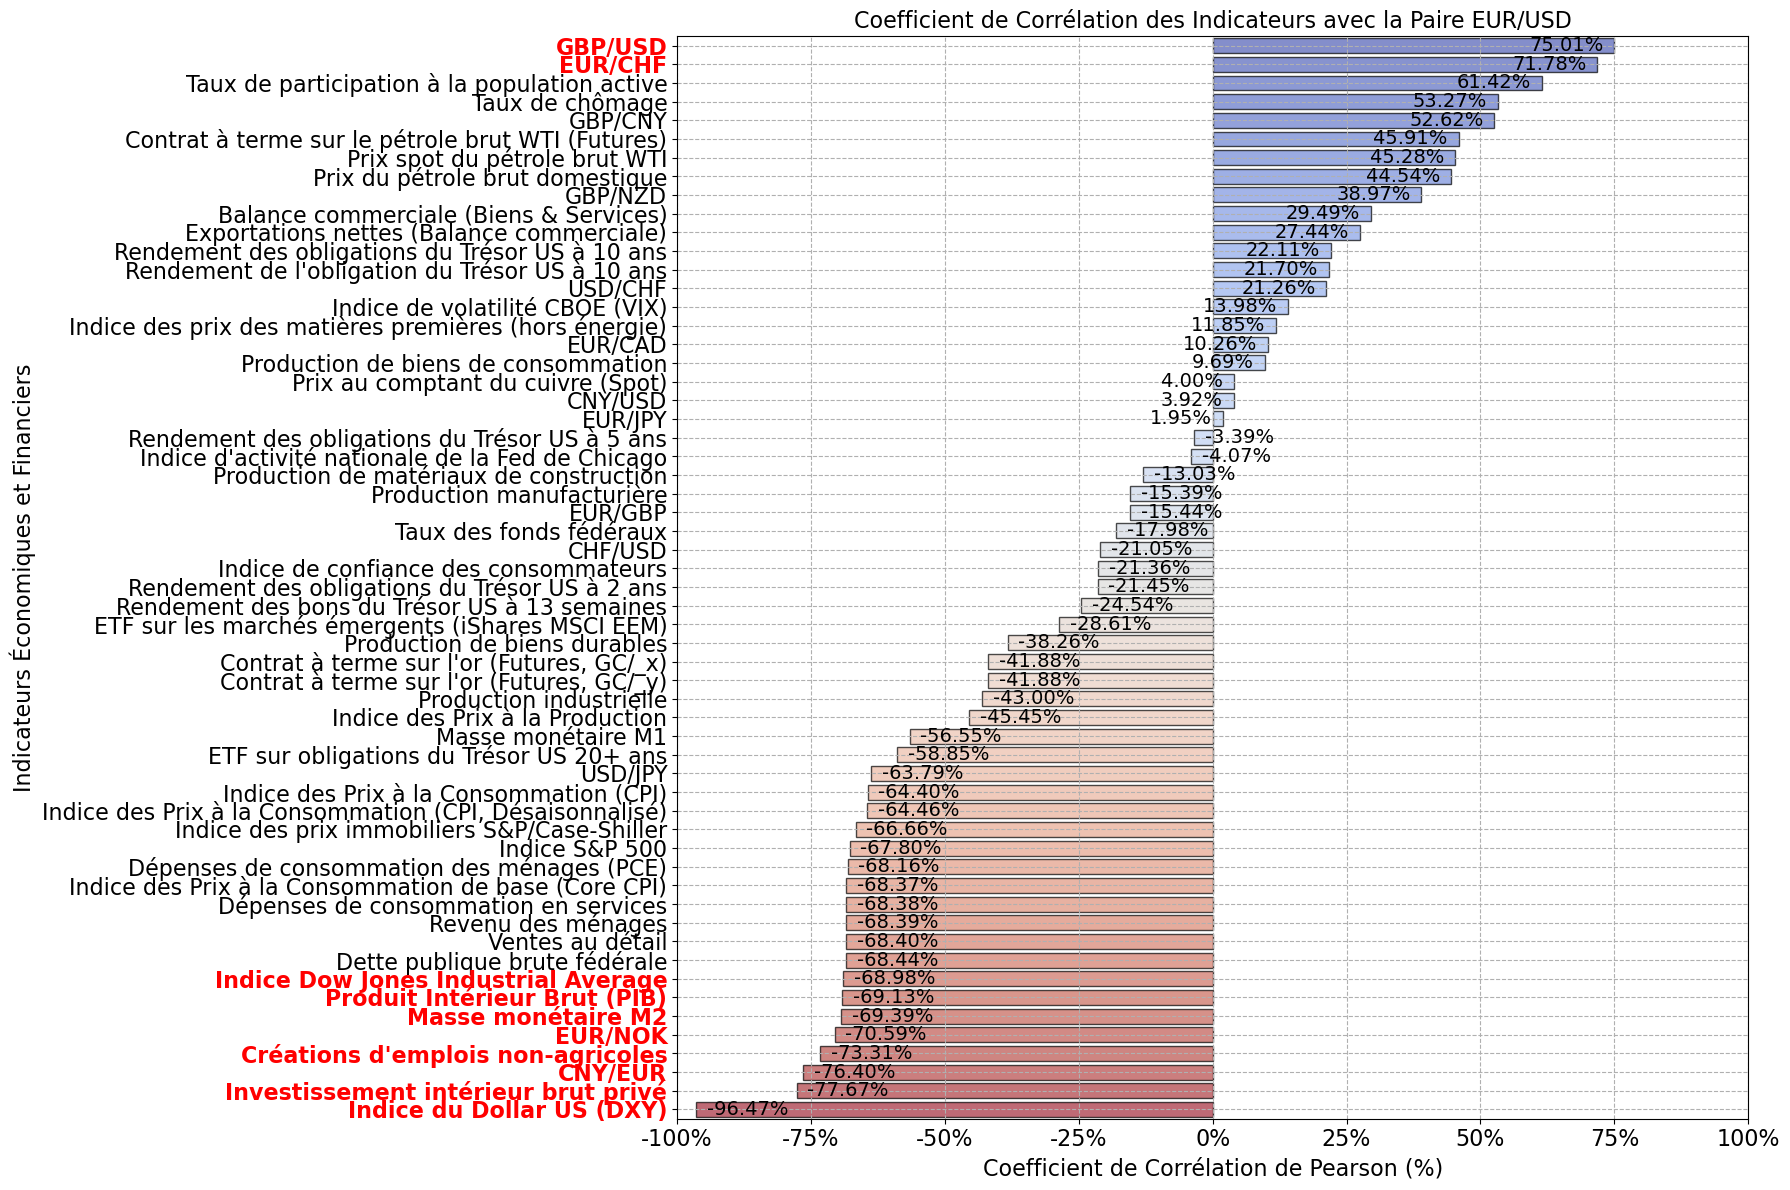

In [5]:
ticker_to_name_map = {
    'DGS2': "Rendement des obligations du Trésor US à 2 ans",
    'DGS5': "Rendement des obligations du Trésor US à 5 ans",
    'DGS10': "Rendement des obligations du Trésor US à 10 ans",
    'FEDFUNDS': "Taux des fonds fédéraux",
    '^IR/X': "Rendement des bons du Trésor US à 13 semaines",
    '^TN/X': "Rendement de l'obligation du Trésor US à 10 ans",
    'TLT/': "ETF sur obligations du Trésor US 20+ ans",
    'CPIAUCNS': "Indice des Prix à la Consommation (CPI)",
    'CPIAUCSL': "Indice des Prix à la Consommation (CPI, Désaisonnalisé)",
    'CPILFESL': "Indice des Prix à la Consommation de base (Core CPI)",
    'PCE': "Dépenses de consommation des ménages (PCE)",
    'PPIACO': "Indice des Prix à la Production",
    'CSUSHPISA': "Indice des prix immobiliers S&P/Case-Shiller",
    'PALLFNFINDEXM': "Indice des prix des matières premières (hors énergie)",
    'PCOPPUSDM': "Prix au comptant du cuivre (Spot)",
    'GDP': "Produit Intérieur Brut (PIB)",
    'UNRATE': "Taux de chômage",
    'PAYEMS': "Créations d'emplois non-agricoles",
    'INDPRO': "Production industrielle",
    'IPMAN': "Production manufacturière",
    'CFNAI': "Indice d'activité nationale de la Fed de Chicago",
    'GPDIC1': "Investissement intérieur brut privé",
    'CIVPART': "Taux de participation à la population active",
    'IPDMAN': "Production de biens durables",
    'IPCONGD': "Production de biens de consommation",
    'IPB51220N': "Production de matériaux de construction",
    'BOPGSTB': "Balance commerciale (Biens & Services)",
    'NETEXP': "Exportations nettes (Balance commerciale)",
    'GFDEBTN': "Dette publique brute fédérale",
    'UMCSENT': "Indice de confiance des consommateurs",
    'RSXFS': "Ventes au détail",
    'PI': "Revenu des ménages",
    'PCES': "Dépenses de consommation en services",
    'M1SL': "Masse monétaire M1",
    'M2SL': "Masse monétaire M2",
    'DCOILWTICO': "Prix spot du pétrole brut WTI",
    'WPU0561': "Prix du pétrole brut domestique",
    'VIXCLS': "Indice de volatilité CBOE (VIX)",
    'CL/': "Contrat à terme sur le pétrole brut WTI (Futures)",
    'GC/_x': "Contrat à terme sur l'or (Futures, GC/_x)",
    'GC/_y': "Contrat à terme sur l'or (Futures, GC/_y)",
    '^GS/PC': "Indice S&P 500",
    '^DJ/I': "Indice Dow Jones Industrial Average",
    'EUR/USD': 'EUR/USD', 'GBP/USD': 'GBP/USD', 'USD/JPY': "USD/JPY", 'EUR/GBP': "EUR/GBP",
    'EUR/JPY': "EUR/JPY", 'EUR/CAD': "EUR/CAD", 'GBP/NZD': "GBP/NZD", 'CNY/USD': "CNY/USD",
    'CNY/EUR': "CNY/EUR", 'EUR/CHF': 'EUR/CHF', 'CHF/USD': "CHF/USD", 'EUR/NOK': "EUR/NOK",
    'GBP/CNY': "GBP/CNY", 'USD/CHF': "USD/CHF",
    'DX-/Y.NYB': "Indice du Dollar US (DXY)",
    'EEM/': "ETF sur les marchés émergents (iShares MSCI EEM)",
}

if chosen_currency in pmi_data.columns:
    numeric_columns = pmi_data.select_dtypes(include='number')
    correlation_matrix = numeric_columns.corrwith(pmi_data[chosen_currency])
    correlation_matrix.drop(chosen_currency, inplace=True, errors='ignore')

    top_10_correlations = correlation_matrix.abs().nlargest(10)
    top_3_indices = top_10_correlations.index

    correlation_matrix.sort_values(ascending=False, inplace=True)

    plt.figure(figsize=(18, 12))

    ax = sns.barplot(y=correlation_matrix.index, x=correlation_matrix.values, palette='coolwarm', edgecolor='black', alpha=0.7, orient='h')

    plt.title(f'Coefficient de Corrélation des Indicateurs avec la Paire {chosen_currency}', fontsize=16)
    plt.xlabel('Coefficient de Corrélation de Pearson (%)', fontsize=16)
    plt.ylabel('Indicateurs Économiques et Financiers', fontsize=16)
    plt.xticks(rotation=0, ha='center', fontsize=16)
    plt.yticks(rotation=0, fontsize=16)
    plt.grid(axis='x', linestyle='--', alpha=1)
    plt.grid(axis='y', linestyle='--', alpha=1)
    plt.xlim(-1, 1)

    for label in ax.get_yticklabels():
        if label.get_text() in top_3_indices:
            label.set_color('red')
            label.set_weight('bold')

    new_labels = [ticker_to_name_map.get(label.get_text(), label.get_text()) for label in ax.get_yticklabels()]
    ax.set_yticklabels(new_labels)

    xlabels = [f'{x*100:.0f}%' for x in ax.get_xticks()]
    ax.set_xticklabels(xlabels)

    for i, (ticker, value) in enumerate(correlation_matrix.items()):
        if value >= 0:
            plt.text(value - 0.02, i, f'{value*100:.2f}%', ha='right', va='center', fontsize=14, color='black')
        else:
            plt.text(value + 0.02, i, f'{value*100:.2f}%', ha='left', va='center', fontsize=14, color='black')

    plt.tight_layout()
    plt.show()

else:
    print(f"La colonne '{chosen_currency}' n'existe pas dans les données.")

In [6]:
first_indicator = top_3_indices[0]
second_indicator = top_3_indices[1]
third_indicator = top_3_indices[2]
fourth_indicator = top_3_indices[3]
fifth_indicator = top_3_indices[4]
sixth_indicator = top_3_indices[5]
seventh_indicator = top_3_indices[6]
eighth_indicator = top_3_indices[7]
ninth_indicator = top_3_indices[8]
tenth_indicator = top_3_indices[9]

colonnes_a_garder = [chosen_currency, first_indicator, second_indicator, third_indicator,
                    fourth_indicator, fifth_indicator, sixth_indicator, seventh_indicator,
                    eighth_indicator, ninth_indicator, tenth_indicator, 'Date']

pmi_data = pmi_data[colonnes_a_garder]

pmi_data.interpolate(method='linear', inplace=True)

columns_to_normalize = [chosen_currency, first_indicator, second_indicator, third_indicator,
                    fourth_indicator, fifth_indicator, sixth_indicator, seventh_indicator,
                    eighth_indicator, ninth_indicator, tenth_indicator]

scaler = StandardScaler()

pmi_data[columns_to_normalize] = scaler.fit_transform(pmi_data[columns_to_normalize])
pmi_data

EUR/USD  DX-/Y.NYB    GPDIC1   CNY/EUR   GBP/USD    PAYEMS   EUR/CHF  \
0    -0.255382   0.069667 -1.063309 -1.206983  0.806060 -1.275504  1.358445   
1    -0.158678  -0.006614 -1.063309 -1.276663  0.855044 -1.275504  1.375093   
2    -0.132154  -0.021655 -1.063309 -1.281179  0.845792 -1.275504  1.382742   
3    -0.164944  -0.010912 -1.063309 -1.270211  0.814838 -1.275504  1.374193   
4    -0.082249  -0.060333 -1.063309 -1.314728  0.866703 -1.275504  1.348997   
...        ...        ...       ...       ...       ...       ...       ...   
5201 -1.471720   1.993884  1.698008  0.781718 -1.138623  2.098222 -1.420548   
5202 -1.476616   1.979917  1.698008  0.786428 -1.134745  2.098222 -1.418793   
5203 -1.458182   1.965950  1.698008  0.767524 -1.140593  2.098222 -1.411684   
5204 -1.453348   1.979917  1.698008  0.761394 -1.120087  2.098222 -1.395081   
5205 -1.471466   2.018594  1.698008  0.779717 -1.132507  2.098222 -1.397871   

       EUR/NOK      M2SL       GDP     ^DJ/I       Date  
0    -0.719419 -1.272944 -1.432738 -1.020800 2003-12-01  
1    -0.719827 -1.272944 -1.432738 -1.025611 2003-12-02  
2    -0.756963 -1.272944 -1.432738 -1.023515 2003-12-03  
3    -0.784877 -1.272944 -1.432738 -1.017434 2003-12-04  
4    -0.785938 -1.272944 -1.432738 -1.024653 2003-12-05  
...        ...       ...       ...       ...        ...  
5201  2.256630  1.764934  2.333490  2.517862 2024-12-24  
5202  2.231818  1.764934  2.333490  2.520910 2024-12-26  
5203  2.306074  1.764934  2.333490  2.485565 2024-12-27  
5204  2.275011  1.764934  2.333490  2.441225 2024-12-30  
5205  2.238511  1.764934  2.333490  2.438098 2024-12-31  

[5206 rows x 12 columns]

--- Test pour un split de 40% / 60% ---
  -> Résultat : MSE pour 40% d'entraînement = 0.0290
--- Test pour un split de 50% / 50% ---
  -> Résultat : MSE pour 50% d'entraînement = 0.0359
--- Test pour un split de 60% / 40% ---
  -> Résultat : MSE pour 60% d'entraînement = 0.0258
--- Test pour un split de 70% / 30% ---
  -> Résultat : MSE pour 70% d'entraînement = 0.0313
--- Test pour un split de 80% / 20% ---
  -> Résultat : MSE pour 80% d'entraînement = 0.0010
--- Test pour un split de 90% / 10% ---
  -> Résultat : MSE pour 90% d'entraînement = 0.0005

Meilleur split trouvé : 90% d'entraînement avec un MSE de 0.0005


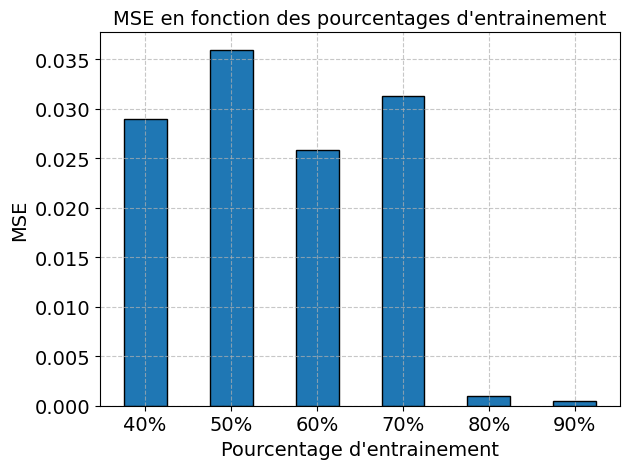

In [7]:

def prepare_data(data, look_back=6):
    X_retail_sales = []
    X_Inflation = []
    X_GDP = []
    X_GPDIC1 = []
    X_indicator4 = []
    X_indicator5 = []
    X_indicator6 = []
    X_indicator7 = []
    X_indicator8 = []
    X_indicator9 = []
    X_indicator10 = []

    y_retail_sales = []
    y_Inflation = []
    y_GDP = []
    y_GPDIC1 = []
    y_indicator4 = []
    y_indicator5 = []
    y_indicator6 = []
    y_indicator7 = []
    y_indicator8 = []
    y_indicator9 = []
    y_indicator10 = []

    for i in range(len(data) - look_back):
        X_row_retail_sales = []
        X_row_Inflation = []
        X_row_GDP = []
        X_row_GPDIC1 = []
        X_row_indicator4 = []
        X_row_indicator5 = []
        X_row_indicator6 = []
        X_row_indicator7 = []
        X_row_indicator8 = []
        X_row_indicator9 = []
        X_row_indicator10 = []

        for column in [chosen_currency, first_indicator, second_indicator, third_indicator,
                      fourth_indicator, fifth_indicator, sixth_indicator, seventh_indicator,
                      eighth_indicator, ninth_indicator, tenth_indicator]:
            if column == chosen_currency:
                X_row_retail_sales.extend(data[column].iloc[i:i+look_back].values.flatten())
            elif column == first_indicator:
                X_row_Inflation.extend(data[column].iloc[i:i+look_back].values.flatten())
            elif column == second_indicator:
                X_row_GDP.extend(data[column].iloc[i:i+look_back].values.flatten())
            elif column == third_indicator:
                X_row_GPDIC1.extend(data[column].iloc[i:i+look_back].values.flatten())
            elif column == fourth_indicator:
                X_row_indicator4.extend(data[column].iloc[i:i+look_back].values.flatten())
            elif column == fifth_indicator:
                X_row_indicator5.extend(data[column].iloc[i:i+look_back].values.flatten())
            elif column == sixth_indicator:
                X_row_indicator6.extend(data[column].iloc[i:i+look_back].values.flatten())
            elif column == seventh_indicator:
                X_row_indicator7.extend(data[column].iloc[i:i+look_back].values.flatten())
            elif column == eighth_indicator:
                X_row_indicator8.extend(data[column].iloc[i:i+look_back].values.flatten())
            elif column == ninth_indicator:
                X_row_indicator9.extend(data[column].iloc[i:i+look_back].values.flatten())
            elif column == tenth_indicator:
                X_row_indicator10.extend(data[column].iloc[i:i+look_back].values.flatten())

        X_retail_sales.append(X_row_retail_sales)
        X_Inflation.append(X_row_Inflation)
        X_GDP.append(X_row_GDP)
        X_GPDIC1.append(X_row_GPDIC1)
        X_indicator4.append(X_row_indicator4)
        X_indicator5.append(X_row_indicator5)
        X_indicator6.append(X_row_indicator6)
        X_indicator7.append(X_row_indicator7)
        X_indicator8.append(X_row_indicator8)
        X_indicator9.append(X_row_indicator9)
        X_indicator10.append(X_row_indicator10)

        y_retail_sales.append(data[chosen_currency].iloc[i+look_back])
        y_Inflation.append(data[first_indicator].iloc[i+look_back])
        y_GDP.append(data[second_indicator].iloc[i+look_back])
        y_GPDIC1.append(data[third_indicator].iloc[i+look_back])
        y_indicator4.append(data[fourth_indicator].iloc[i+look_back])
        y_indicator5.append(data[fifth_indicator].iloc[i+look_back])
        y_indicator6.append(data[sixth_indicator].iloc[i+look_back])
        y_indicator7.append(data[seventh_indicator].iloc[i+look_back])
        y_indicator8.append(data[eighth_indicator].iloc[i+look_back])
        y_indicator9.append(data[ninth_indicator].iloc[i+look_back])
        y_indicator10.append(data[tenth_indicator].iloc[i+look_back])

    return (
        np.array(X_retail_sales),
        np.array(X_Inflation),
        np.array(X_GDP),
        np.array(X_GPDIC1),
        np.array(X_indicator4),
        np.array(X_indicator5),
        np.array(X_indicator6),
        np.array(X_indicator7),
        np.array(X_indicator8),
        np.array(X_indicator9),
        np.array(X_indicator10),
        np.array(y_retail_sales),
        np.array(y_Inflation),
        np.array(y_GDP),
        np.array(y_GPDIC1),
        np.array(y_indicator4),
        np.array(y_indicator5),
        np.array(y_indicator6),
        np.array(y_indicator7),
        np.array(y_indicator8),
        np.array(y_indicator9),
        np.array(y_indicator10)
    )

split_percentages_range = range(4, 10)

successful_splits = []
errors = []

best_score = float('inf')
best_split = None

for p in split_percentages_range:
    percentage = p / 10.0

    try:
        print(f"--- Test pour un split de {int(p*10)}% / {int(100 - p*10)}% ---")
        train_data, test_data = train_test_split(pmi_data, train_size=percentage, shuffle=False)

        if len(test_data) <= 6:
            print(f"Jeu de test trop petit ({len(test_data)} lignes), on ignore ce split.")
            continue

        (X_train_retail_sales, X_train_Inflation, X_train_GDP, X_train_GPDIC1,
         X_train_indicator4, X_train_indicator5, X_train_indicator6, X_train_indicator7,
         X_train_indicator8, X_train_indicator9, X_train_indicator10,
         y_train_retail_sales, y_train_Inflation, y_train_GDP, y_train_GPDIC1,
         y_train_indicator4, y_train_indicator5, y_train_indicator6, y_train_indicator7,
         y_train_indicator8, y_train_indicator9, y_train_indicator10) = prepare_data(train_data)

        (X_test_retail_sales, X_test_Inflation, X_test_GDP, X_test_GPDIC1,
         X_test_indicator4, X_test_indicator5, X_test_indicator6, X_test_indicator7,
         X_test_indicator8, X_test_indicator9, X_test_indicator10,
         y_test_retail_sales, y_test_Inflation, y_test_GDP, y_test_GPDIC1,
         y_test_indicator4, y_test_indicator5, y_test_indicator6, y_test_indicator7,
         y_test_indicator8, y_test_indicator9, y_test_indicator10) = prepare_data(test_data)

        X_train_combined_retail_sales = np.concatenate((X_train_retail_sales, X_train_Inflation, X_train_GDP, X_train_GPDIC1, X_train_indicator4, X_train_indicator5, X_train_indicator6, X_train_indicator7, X_train_indicator8, X_train_indicator9, X_train_indicator10), axis=1)
        model_retail_sales = LinearRegression()
        model_retail_sales.fit(X_train_combined_retail_sales, y_train_retail_sales)

        X_test_combined_retail_sales = np.concatenate((X_test_retail_sales, X_test_Inflation, X_test_GDP, X_test_GPDIC1, X_test_indicator4, X_test_indicator5, X_test_indicator6, X_test_indicator7, X_test_indicator8, X_test_indicator9, X_test_indicator10), axis=1)
        y_pred_combined_retail_sales = model_retail_sales.predict(X_test_combined_retail_sales)

        mse_retail_sales = mean_squared_error(y_test_retail_sales, y_pred_combined_retail_sales)

        print(f"  -> Résultat : MSE pour {int(p*10)}% d'entraînement = {mse_retail_sales:.4f}")

        errors.append(mse_retail_sales)
        successful_splits.append(p)

        if mse_retail_sales < best_score:
            best_score = mse_retail_sales
            best_split = percentage

    except Exception as e:
        print(f"Erreur pour le split {int(p*10)}%: {e}. On ignore ce split.")
        continue

if not errors:
    print("\nAucun split n'a pu être traité. Impossible de générer le graphique.")
else:
    print(f"\nMeilleur split trouvé : {best_split*100:.0f}% d'entraînement avec un MSE de {best_score:.4f}")

    plt.bar([f'{s*10}%' for s in successful_splits], errors, width=0.5, edgecolor='black')
    plt.xlabel('Pourcentage d\'entrainement', fontsize=14)
    plt.ylabel('MSE', fontsize=14)
    plt.title('MSE en fonction des pourcentages d\'entrainement', fontsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


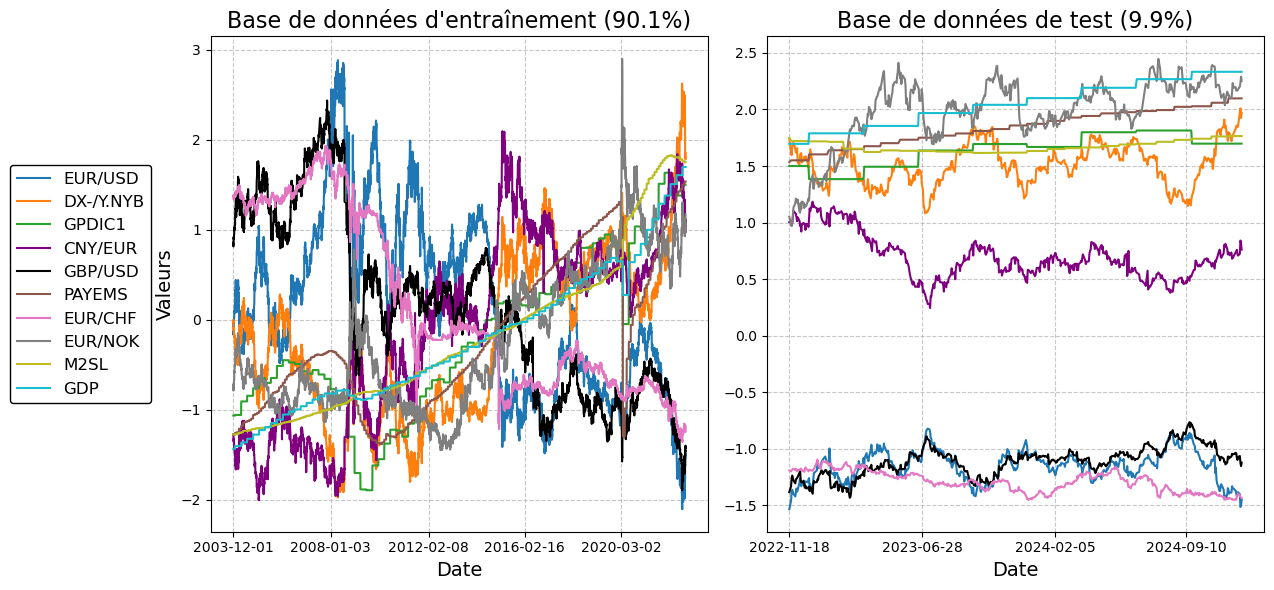

In [8]:
train_data, test_data = train_test_split(pmi_data, train_size=best_split, shuffle=False)

(X_train_retail_sales, X_train_Inflation, X_train_GDP, X_train_GPDIC1,
 X_train_indicator4, X_train_indicator5, X_train_indicator6, X_train_indicator7,
 X_train_indicator8, X_train_indicator9, X_train_indicator10,
 y_train_retail_sales, y_train_Inflation, y_train_GDP, y_train_GPDIC1,
 y_train_indicator4, y_train_indicator5, y_train_indicator6, y_train_indicator7,
 y_train_indicator8, y_train_indicator9, y_train_indicator10) = prepare_data(train_data)

(X_test_retail_sales, X_test_Inflation, X_test_GDP, X_test_GPDIC1,
 X_test_indicator4, X_test_indicator5, X_test_indicator6, X_test_indicator7,
 X_test_indicator8, X_test_indicator9, X_test_indicator10,
 y_test_retail_sales, y_test_Inflation, y_test_GDP, y_test_GPDIC1,
 y_test_indicator4, y_test_indicator5, y_test_indicator6, y_test_indicator7,
 y_test_indicator8, y_test_indicator9, y_test_indicator10) = prepare_data(test_data)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#800080', '#000000',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

train_size = len(X_train_GDP)
test_size = len(X_test_GDP)
total_size = train_size + test_size

train_pct = round(100 * train_size / total_size, 1)
test_pct = round(100 * test_size / total_size, 1)

train_dates = pmi_data['Date'][:train_size]
test_dates = pmi_data['Date'][train_size:train_size + test_size]

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

train_data = [
    (X_train_retail_sales, colors[0], chosen_currency),
    (X_train_Inflation, colors[1], first_indicator),
    (X_train_GDP, colors[2], second_indicator),
    (X_train_GPDIC1, colors[3], third_indicator),
    (X_train_indicator4, colors[4], fourth_indicator),
    (X_train_indicator5, colors[5], fifth_indicator),
    (X_train_indicator6, colors[6], sixth_indicator),
    (X_train_indicator7, colors[7], seventh_indicator),
    (X_train_indicator8, colors[8], eighth_indicator),
    (X_train_indicator9, colors[9], ninth_indicator)
]

test_data = [
    X_test_retail_sales,
    X_test_Inflation,
    X_test_GDP,
    X_test_GPDIC1,
    X_test_indicator4,
    X_test_indicator5,
    X_test_indicator6,
    X_test_indicator7,
    X_test_indicator8,
    X_test_indicator9
]

for data, color, label in train_data:
    axs[0].plot(train_dates, [sample[1] for sample in data], color=color, label=label)

axs[0].set_xticks(train_dates[::1000])
axs[0].set_xlabel('Date', fontsize=14)
axs[0].set_ylabel('Valeurs', fontsize=14)
axs[0].set_title(f'Base de données d\'entraînement ({train_pct}%)', fontsize=16)
axs[0].grid(True, linestyle='--', alpha=0.7)

for i, data in enumerate(test_data):
    axs[1].plot(test_dates, [sample[1] for sample in data], color=colors[i])

axs[1].set_xticks(test_dates[::150])
axs[1].set_xlabel('Date', fontsize=14)
axs[1].set_title(f'Base de données de test ({test_pct}%)', fontsize=16)
axs[1].grid(True, linestyle='--', alpha=0.7)

handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles, labels,
              loc='center left',
              bbox_to_anchor=(-0.42, 0.5),
              fontsize=12,
              frameon=True,
              fancybox=True,
              edgecolor='black',
              framealpha=1)

plt.tight_layout(rect=[0.18, 0, 1, 1])

plt.show()

In [9]:
X_train_combined_retail_sales = np.concatenate((X_train_retail_sales, X_train_Inflation,
                                              X_train_GDP, X_train_GPDIC1,
                                              X_train_indicator4, X_train_indicator5,
                                              X_train_indicator6, X_train_indicator7,
                                              X_train_indicator8, X_train_indicator9,
                                              X_train_indicator10), axis=1)

X_train_combined_Inflation = np.concatenate((X_train_Inflation, X_train_retail_sales,
                                          X_train_GDP, X_train_GPDIC1,
                                          X_train_indicator4, X_train_indicator5,
                                          X_train_indicator6, X_train_indicator7,
                                          X_train_indicator8, X_train_indicator9,
                                          X_train_indicator10), axis=1)

X_train_combined_GDP = np.concatenate((X_train_GDP, X_train_retail_sales,
                                    X_train_Inflation, X_train_GPDIC1,
                                    X_train_indicator4, X_train_indicator5,
                                    X_train_indicator6, X_train_indicator7,
                                    X_train_indicator8, X_train_indicator9,
                                    X_train_indicator10), axis=1)

X_train_combined_GPDIC1 = np.concatenate((X_train_GPDIC1, X_train_retail_sales,
                                        X_train_Inflation, X_train_GDP,
                                        X_train_indicator4, X_train_indicator5,
                                        X_train_indicator6, X_train_indicator7,
                                        X_train_indicator8, X_train_indicator9,
                                        X_train_indicator10), axis=1)

X_train_combined_indicator4 = np.concatenate((X_train_indicator4, X_train_retail_sales,
                                            X_train_Inflation, X_train_GDP, X_train_GPDIC1,
                                            X_train_indicator5, X_train_indicator6,
                                            X_train_indicator7, X_train_indicator8,
                                            X_train_indicator9, X_train_indicator10), axis=1)

X_train_combined_indicator5 = np.concatenate((X_train_indicator5, X_train_retail_sales,
                                            X_train_Inflation, X_train_GDP, X_train_GPDIC1,
                                            X_train_indicator4, X_train_indicator6,
                                            X_train_indicator7, X_train_indicator8,
                                            X_train_indicator9, X_train_indicator10), axis=1)

X_train_combined_indicator6 = np.concatenate((X_train_indicator6, X_train_retail_sales,
                                            X_train_Inflation, X_train_GDP, X_train_GPDIC1,
                                            X_train_indicator4, X_train_indicator5,
                                            X_train_indicator7, X_train_indicator8,
                                            X_train_indicator9, X_train_indicator10), axis=1)

X_train_combined_indicator7 = np.concatenate((X_train_indicator7, X_train_retail_sales,
                                            X_train_Inflation, X_train_GDP, X_train_GPDIC1,
                                            X_train_indicator4, X_train_indicator5,
                                            X_train_indicator6, X_train_indicator8,
                                            X_train_indicator9, X_train_indicator10), axis=1)

X_train_combined_indicator8 = np.concatenate((X_train_indicator8, X_train_retail_sales,
                                            X_train_Inflation, X_train_GDP, X_train_GPDIC1,
                                            X_train_indicator4, X_train_indicator5,
                                            X_train_indicator6, X_train_indicator7,
                                            X_train_indicator9, X_train_indicator10), axis=1)

X_train_combined_indicator9 = np.concatenate((X_train_indicator9, X_train_retail_sales,
                                            X_train_Inflation, X_train_GDP, X_train_GPDIC1,
                                            X_train_indicator4, X_train_indicator5,
                                            X_train_indicator6, X_train_indicator7,
                                            X_train_indicator8, X_train_indicator10), axis=1)

X_train_combined_indicator10 = np.concatenate((X_train_indicator10, X_train_retail_sales,
                                            X_train_Inflation, X_train_GDP, X_train_GPDIC1,
                                            X_train_indicator4, X_train_indicator5,
                                            X_train_indicator6, X_train_indicator7,
                                            X_train_indicator8, X_train_indicator9), axis=1)


model_retail_sales = LinearRegression()
model_retail_sales.fit(X_train_combined_retail_sales, y_train_retail_sales)

model_Inflation = LinearRegression()
model_Inflation.fit(X_train_combined_Inflation, y_train_Inflation)

model_GDP = LinearRegression()
model_GDP.fit(X_train_combined_GDP, y_train_GDP)

model_GPDIC1 = LinearRegression()
model_GPDIC1.fit(X_train_combined_GPDIC1, y_train_GPDIC1)

model_indicator4 = LinearRegression()
model_indicator4.fit(X_train_combined_indicator4, y_train_indicator4)

model_indicator5 = LinearRegression()
model_indicator5.fit(X_train_combined_indicator5, y_train_indicator5)

model_indicator6 = LinearRegression()
model_indicator6.fit(X_train_combined_indicator6, y_train_indicator6)

model_indicator7 = LinearRegression()
model_indicator7.fit(X_train_combined_indicator7, y_train_indicator7)

model_indicator8 = LinearRegression()
model_indicator8.fit(X_train_combined_indicator8, y_train_indicator8)

model_indicator9 = LinearRegression()
model_indicator9.fit(X_train_combined_indicator9, y_train_indicator9)

model_indicator10 = LinearRegression()
model_indicator10.fit(X_train_combined_indicator10, y_train_indicator10)


y_train_pred_retail_sales = model_retail_sales.predict(X_train_combined_retail_sales)

y_train_pred_Inflation = model_Inflation.predict(X_train_combined_Inflation)

y_train_pred_GDP = model_GDP.predict(X_train_combined_GDP)

y_train_pred_GPDIC1 = model_GPDIC1.predict(X_train_combined_GPDIC1)

y_train_pred_indicator4 = model_indicator4.predict(X_train_combined_indicator4)

y_train_pred_indicator5 = model_indicator5.predict(X_train_combined_indicator5)

y_train_pred_indicator6 = model_indicator6.predict(X_train_combined_indicator6)

y_train_pred_indicator7 = model_indicator7.predict(X_train_combined_indicator7)

y_train_pred_indicator8 = model_indicator8.predict(X_train_combined_indicator8)

y_train_pred_indicator9 = model_indicator9.predict(X_train_combined_indicator9)

y_train_pred_indicator10 = model_indicator10.predict(X_train_combined_indicator10)

np.set_printoptions(suppress=True)

train_rmse_retail_sales = np.sqrt(mean_squared_error(y_train_retail_sales, y_train_pred_retail_sales))
train_r2_retail_sales = r2_score(y_train_retail_sales, y_train_pred_retail_sales)
train_mae_retail_sales = mean_absolute_error(y_train_retail_sales, y_train_pred_retail_sales)

train_rmse_Inflation = np.sqrt(mean_squared_error(y_train_Inflation, y_train_pred_Inflation))
train_r2_Inflation = r2_score(y_train_Inflation, y_train_pred_Inflation)
train_mae_Inflation = mean_absolute_error(y_train_Inflation, y_train_pred_Inflation)

train_rmse_GDP = np.sqrt(mean_squared_error(y_train_GDP, y_train_pred_GDP))
train_r2_GDP = r2_score(y_train_GDP, y_train_pred_GDP)
train_mae_GDP = mean_absolute_error(y_train_GDP, y_train_pred_GDP)

train_rmse_GPDIC1 = np.sqrt(mean_squared_error(y_train_GPDIC1, y_train_pred_GPDIC1))
train_r2_GPDIC1 = r2_score(y_train_GPDIC1, y_train_pred_GPDIC1)
train_mae_GPDIC1 = mean_absolute_error(y_train_GPDIC1, y_train_pred_GPDIC1)

train_rmse_indicator4 = np.sqrt(mean_squared_error(y_train_indicator4, y_train_pred_indicator4))
train_r2_indicator4 = r2_score(y_train_indicator4, y_train_pred_indicator4)
train_mae_indicator4 = mean_absolute_error(y_train_indicator4, y_train_pred_indicator4)

train_rmse_indicator5 = np.sqrt(mean_squared_error(y_train_indicator5, y_train_pred_indicator5))
train_r2_indicator5 = r2_score(y_train_indicator5, y_train_pred_indicator5)
train_mae_indicator5 = mean_absolute_error(y_train_indicator5, y_train_pred_indicator5)

train_rmse_indicator6 = np.sqrt(mean_squared_error(y_train_indicator6, y_train_pred_indicator6))
train_r2_indicator6 = r2_score(y_train_indicator6, y_train_pred_indicator6)
train_mae_indicator6 = mean_absolute_error(y_train_indicator6, y_train_pred_indicator6)

train_rmse_indicator7 = np.sqrt(mean_squared_error(y_train_indicator7, y_train_pred_indicator7))
train_r2_indicator7 = r2_score(y_train_indicator7, y_train_pred_indicator7)
train_mae_indicator7 = mean_absolute_error(y_train_indicator7, y_train_pred_indicator7)

train_rmse_indicator8 = np.sqrt(mean_squared_error(y_train_indicator8, y_train_pred_indicator8))
train_r2_indicator8 = r2_score(y_train_indicator8, y_train_pred_indicator8)
train_mae_indicator8 = mean_absolute_error(y_train_indicator8, y_train_pred_indicator8)

train_rmse_indicator9 = np.sqrt(mean_squared_error(y_train_indicator9, y_train_pred_indicator9))
train_r2_indicator9 = r2_score(y_train_indicator9, y_train_pred_indicator9)
train_mae_indicator9 = mean_absolute_error(y_train_indicator9, y_train_pred_indicator9)

train_rmse_indicator10 = np.sqrt(mean_squared_error(y_train_indicator10, y_train_pred_indicator10))
train_r2_indicator10 = r2_score(y_train_indicator10, y_train_pred_indicator10)
train_mae_indicator10 = mean_absolute_error(y_train_indicator10, y_train_pred_indicator10)

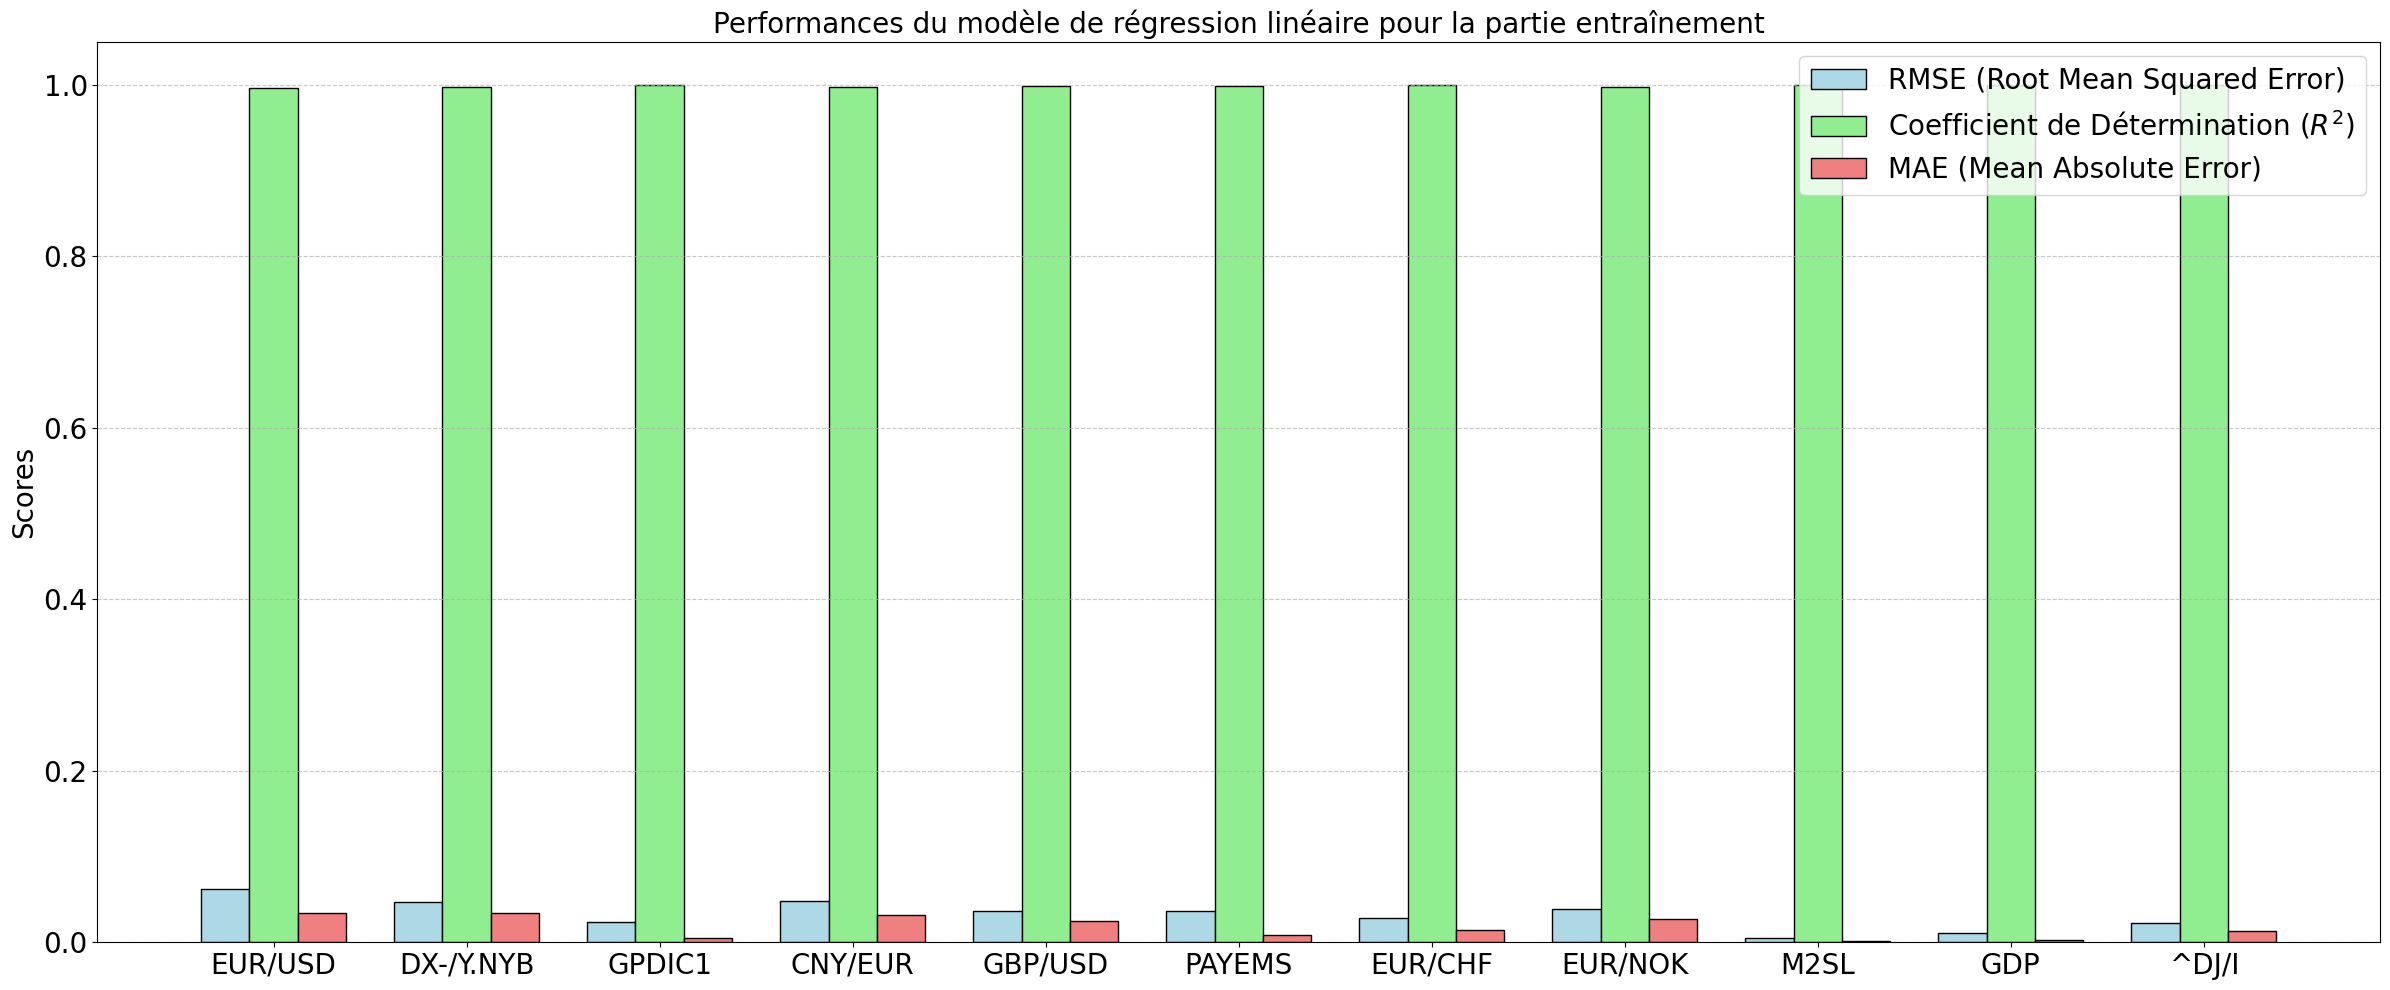

In [10]:
models = [chosen_currency, first_indicator, second_indicator, third_indicator,
          fourth_indicator, fifth_indicator, sixth_indicator, seventh_indicator,
          eighth_indicator, ninth_indicator, tenth_indicator]

rmse_scores = [train_rmse_retail_sales, train_rmse_Inflation, train_rmse_GDP, train_rmse_GPDIC1,
               train_rmse_indicator4, train_rmse_indicator5, train_rmse_indicator6, train_rmse_indicator7,
               train_rmse_indicator8, train_rmse_indicator9, train_rmse_indicator10]

r2_scores = [train_r2_retail_sales, train_r2_Inflation, train_r2_GDP, train_r2_GPDIC1,
             train_r2_indicator4, train_r2_indicator5, train_r2_indicator6, train_r2_indicator7,
             train_r2_indicator8, train_r2_indicator9, train_r2_indicator10]

mae_scores = [train_mae_retail_sales, train_mae_Inflation, train_mae_GDP, train_mae_GPDIC1,
              train_mae_indicator4, train_mae_indicator5, train_mae_indicator6, train_mae_indicator7,
              train_mae_indicator8, train_mae_indicator9, train_mae_indicator10]

bar_width = 0.25
index = np.arange(len(models))

plt.figure(figsize=(24, 10))

plt.bar(index - bar_width, rmse_scores, bar_width, label='RMSE (Root Mean Squared Error)', 
        color='lightblue', edgecolor='black')
plt.bar(index, r2_scores, bar_width, label=r'Coefficient de Détermination ($R^2$)', 
        color='lightgreen', edgecolor='black')
plt.bar(index + bar_width, mae_scores, bar_width, label='MAE (Mean Absolute Error)', 
        color='lightcoral', edgecolor='black')

# On affiche directement les noms de variables sans mapping
plt.ylabel('Scores', fontsize=20)
plt.title('Performances du modèle de régression linéaire pour la partie entraînement', fontsize=20)
plt.xticks(index, models, fontsize=20, rotation=0, ha='center')
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

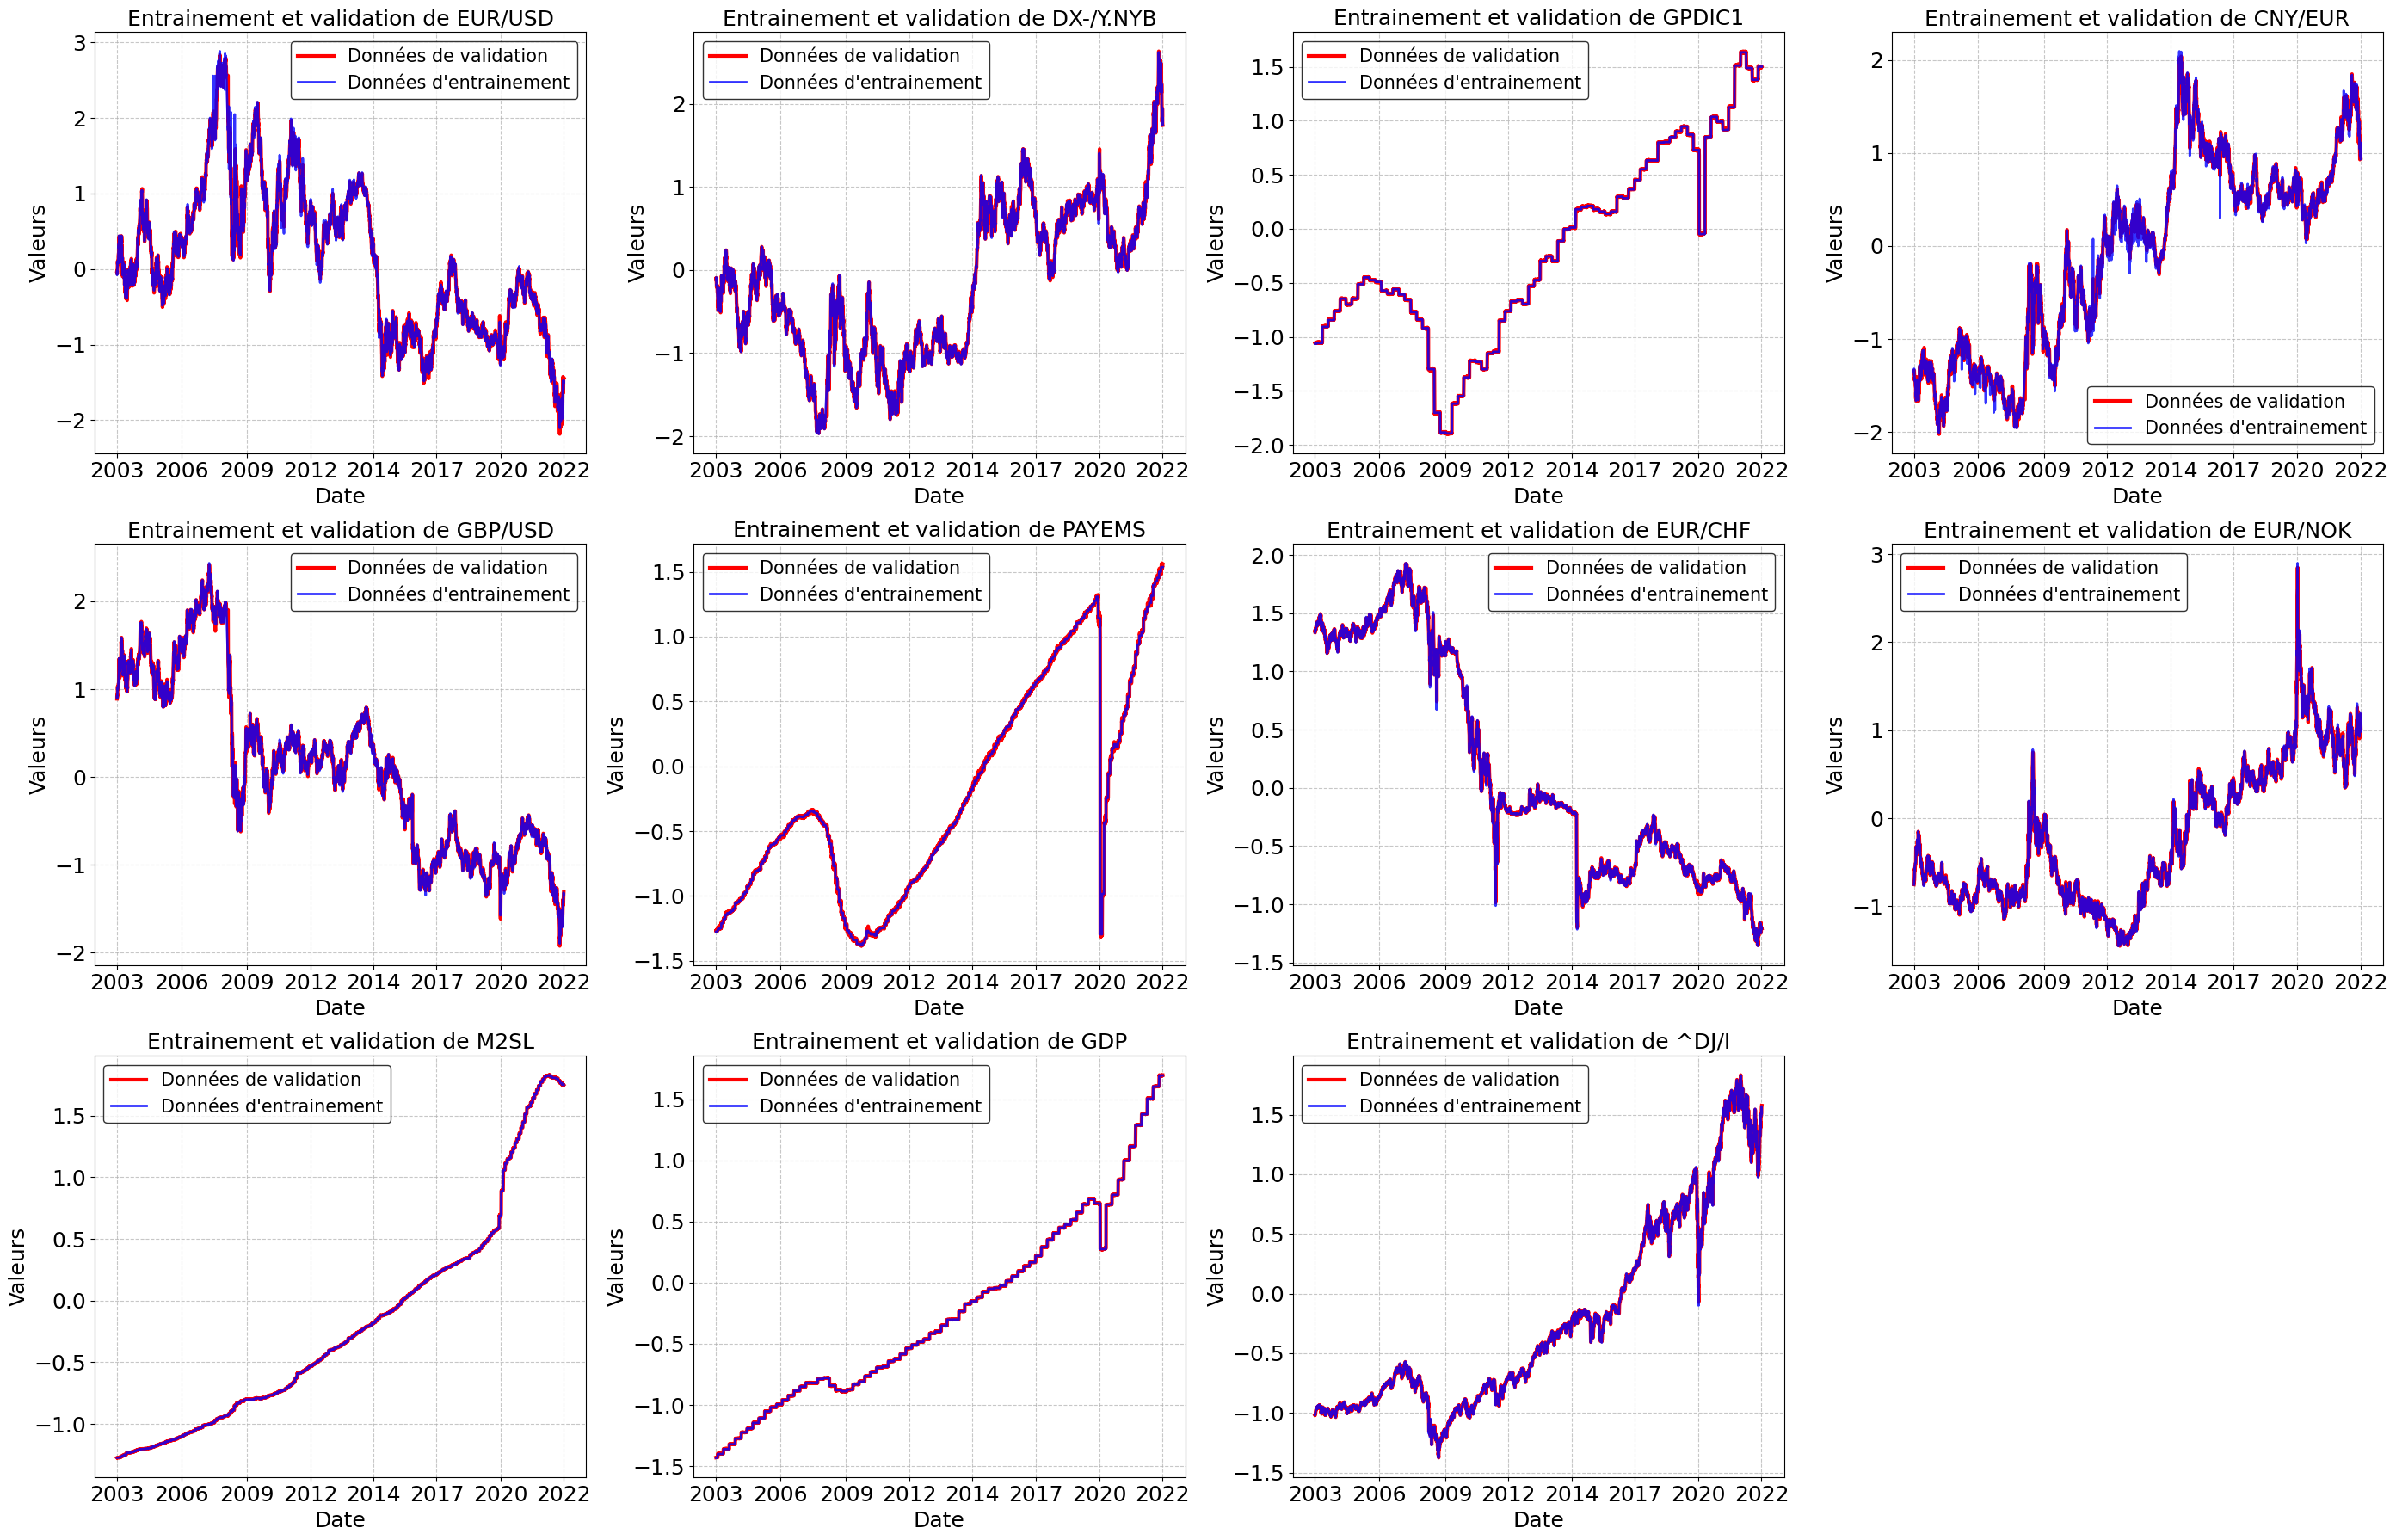

In [11]:
pmi_data_nv = pmi_data.iloc[6:].copy()
pmi_data_nv['Date'] = pd.to_datetime(pmi_data_nv['Date'])

dates_train = pmi_data_nv['Date'][:len(y_train_pred_GDP)]
sampled_dates = dates_train[::len(dates_train)//7]

plots_config = [
    (chosen_currency, y_train_pred_retail_sales, chosen_currency),
    (first_indicator, y_train_pred_Inflation, first_indicator),
    (second_indicator, y_train_pred_GDP, second_indicator),
    (third_indicator, y_train_pred_GPDIC1, third_indicator),
    (fourth_indicator, y_train_pred_indicator4, fourth_indicator),
    (fifth_indicator, y_train_pred_indicator5, fifth_indicator),
    (sixth_indicator, y_train_pred_indicator6, sixth_indicator),
    (seventh_indicator, y_train_pred_indicator7, seventh_indicator),
    (eighth_indicator, y_train_pred_indicator8, eighth_indicator),
    (ninth_indicator, y_train_pred_indicator9, ninth_indicator),
    (tenth_indicator, y_train_pred_indicator10, tenth_indicator),]

n_cols = 4
n_rows = (len(plots_config) + n_cols - 1) // n_cols
plt.figure(figsize=(28, 6 * n_rows))

for i, (title, y_pred, col) in enumerate(plots_config, start=1):
    plt.subplot(n_rows, n_cols, i)
    
    plt.plot(dates_train, y_pred, label='Données de validation', 
             color='red', linestyle='-', linewidth=3)
    plt.plot(dates_train, pmi_data_nv[col][:len(y_pred)], 
             label="Données d'entrainement", color='blue', linewidth=2, alpha=0.8)
    
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Valeurs', fontsize=18)
    plt.title(f'Entrainement et validation de {title}', fontsize=18)
    plt.legend(edgecolor='black', fontsize=15)
    
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', labelsize=18)
    ax.set_xticks(sampled_dates)
    
    plt.xticks(rotation=0, fontsize=18)
    plt.yticks(fontsize=18)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


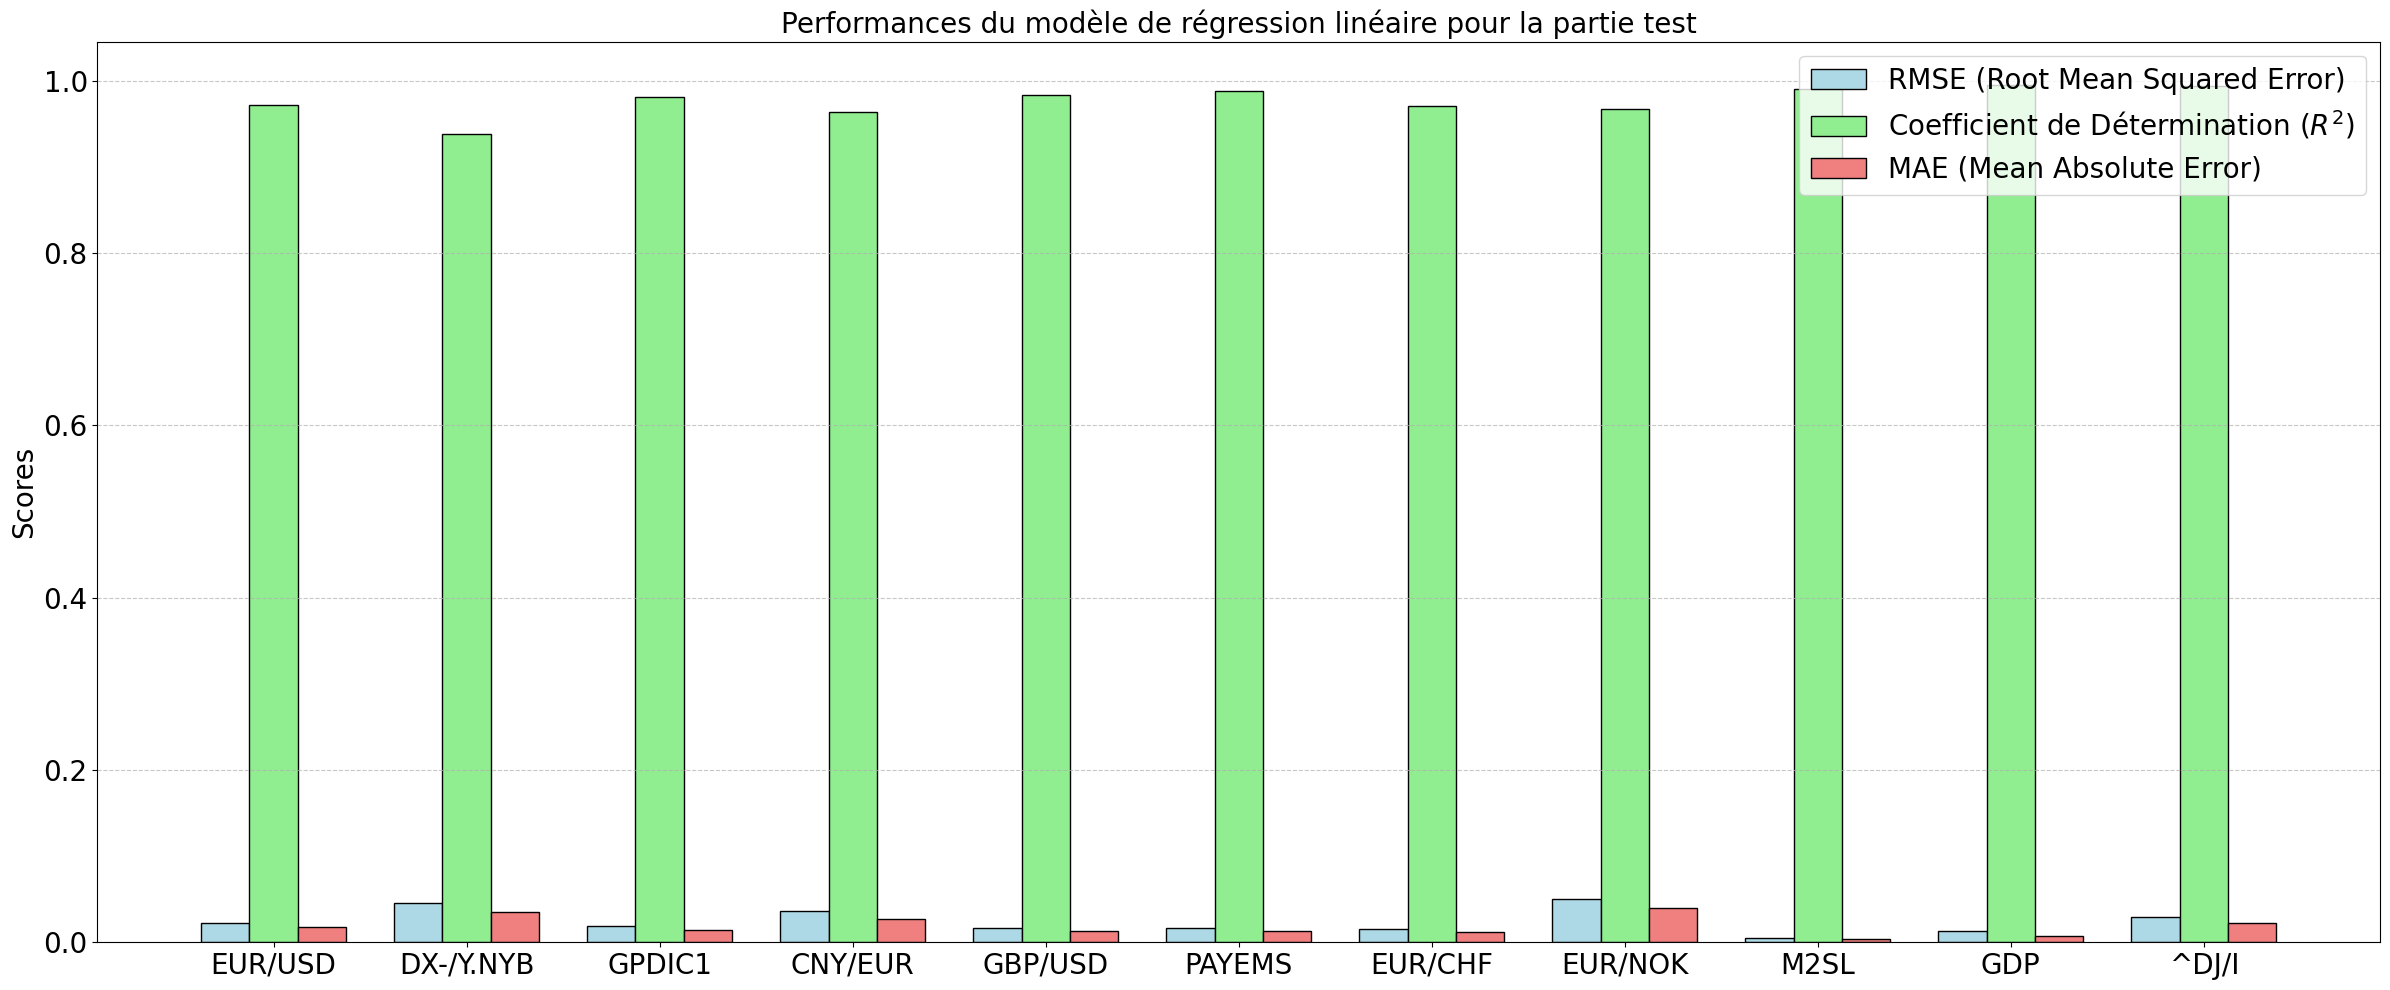

In [12]:
X_test_combined_retail_sales = np.concatenate((X_test_retail_sales, X_test_Inflation,
                                              X_test_GDP, X_test_GPDIC1,
                                              X_test_indicator4, X_test_indicator5,
                                              X_test_indicator6, X_test_indicator7,
                                              X_test_indicator8, X_test_indicator9,
                                              X_test_indicator10), axis=1)

X_test_combined_Inflation = np.concatenate((X_test_Inflation, X_test_retail_sales,
                                          X_test_GDP, X_test_GPDIC1,
                                          X_test_indicator4, X_test_indicator5,
                                          X_test_indicator6, X_test_indicator7,
                                          X_test_indicator8, X_test_indicator9,
                                          X_test_indicator10), axis=1)

X_test_combined_GDP = np.concatenate((X_test_GDP, X_test_retail_sales,
                                    X_test_Inflation, X_test_GPDIC1,
                                    X_test_indicator4, X_test_indicator5,
                                    X_test_indicator6, X_test_indicator7,
                                    X_test_indicator8, X_test_indicator9,
                                    X_test_indicator10), axis=1)

X_test_combined_GPDIC1 = np.concatenate((X_test_GPDIC1, X_test_retail_sales,
                                       X_test_Inflation, X_test_GDP,
                                       X_test_indicator4, X_test_indicator5,
                                       X_test_indicator6, X_test_indicator7,
                                       X_test_indicator8, X_test_indicator9,
                                       X_test_indicator10), axis=1)

X_test_combined_indicator4 = np.concatenate((X_test_indicator4, X_test_retail_sales,
                                           X_test_Inflation, X_test_GDP, X_test_GPDIC1,
                                           X_test_indicator5, X_test_indicator6,
                                           X_test_indicator7, X_test_indicator8,
                                           X_test_indicator9, X_test_indicator10), axis=1)

X_test_combined_indicator5 = np.concatenate((X_test_indicator5, X_test_retail_sales,
                                           X_test_Inflation, X_test_GDP, X_test_GPDIC1,
                                           X_test_indicator4, X_test_indicator6,
                                           X_test_indicator7, X_test_indicator8,
                                           X_test_indicator9, X_test_indicator10), axis=1)

X_test_combined_indicator6 = np.concatenate((X_test_indicator6, X_test_retail_sales,
                                           X_test_Inflation, X_test_GDP, X_test_GPDIC1,
                                           X_test_indicator4, X_test_indicator5,
                                           X_test_indicator7, X_test_indicator8,
                                           X_test_indicator9, X_test_indicator10), axis=1)

X_test_combined_indicator7 = np.concatenate((X_test_indicator7, X_test_retail_sales,
                                           X_test_Inflation, X_test_GDP, X_test_GPDIC1,
                                           X_test_indicator4, X_test_indicator5,
                                           X_test_indicator6, X_test_indicator8,
                                           X_test_indicator9, X_test_indicator10), axis=1)

X_test_combined_indicator8 = np.concatenate((X_test_indicator8, X_test_retail_sales,
                                           X_test_Inflation, X_test_GDP, X_test_GPDIC1,
                                           X_test_indicator4, X_test_indicator5,
                                           X_test_indicator6, X_test_indicator7,
                                           X_test_indicator9, X_test_indicator10), axis=1)

X_test_combined_indicator9 = np.concatenate((X_test_indicator9, X_test_retail_sales,
                                           X_test_Inflation, X_test_GDP, X_test_GPDIC1,
                                           X_test_indicator4, X_test_indicator5,
                                           X_test_indicator6, X_test_indicator7,
                                           X_test_indicator8, X_test_indicator10), axis=1)

X_test_combined_indicator10 = np.concatenate((X_test_indicator10, X_test_retail_sales,
                                            X_test_Inflation, X_test_GDP, X_test_GPDIC1,
                                            X_test_indicator4, X_test_indicator5,
                                            X_test_indicator6, X_test_indicator7,
                                            X_test_indicator8, X_test_indicator9), axis=1)

y_pred_combined_retail_sales = model_retail_sales.predict(X_test_combined_retail_sales)

y_pred_combined_Inflation = model_Inflation.predict(X_test_combined_Inflation)

y_pred_combined_GDP = model_GDP.predict(X_test_combined_GDP)

y_pred_combined_GPDIC1 = model_GPDIC1.predict(X_test_combined_GPDIC1)

y_pred_combined_indicator4 = model_indicator4.predict(X_test_combined_indicator4)

y_pred_combined_indicator5 = model_indicator5.predict(X_test_combined_indicator5)

y_pred_combined_indicator6 = model_indicator6.predict(X_test_combined_indicator6)

y_pred_combined_indicator7 = model_indicator7.predict(X_test_combined_indicator7)

y_pred_combined_indicator8 = model_indicator8.predict(X_test_combined_indicator8)

y_pred_combined_indicator9 = model_indicator9.predict(X_test_combined_indicator9)

y_pred_combined_indicator10 = model_indicator10.predict(X_test_combined_indicator10)


mse_retail_sales = mean_squared_error(y_test_retail_sales, y_pred_combined_retail_sales)
mae_retail_sales = mean_absolute_error(y_test_retail_sales, y_pred_combined_retail_sales)
r2_retail_sales = r2_score(y_test_retail_sales, y_pred_combined_retail_sales)

mse_Inflation = mean_squared_error(y_test_Inflation, y_pred_combined_Inflation)
mae_Inflation = mean_absolute_error(y_test_Inflation, y_pred_combined_Inflation)
r2_Inflation = r2_score(y_test_Inflation, y_pred_combined_Inflation)

mse_GDP = mean_squared_error(y_test_GDP, y_pred_combined_GDP)
mae_GDP = mean_absolute_error(y_test_GDP, y_pred_combined_GDP)
r2_GDP = r2_score(y_test_GDP, y_pred_combined_GDP)

rmse_GPDIC1 = np.sqrt(mean_squared_error(y_test_GPDIC1, y_pred_combined_GPDIC1))
r2_GPDIC1 = r2_score(y_test_GPDIC1, y_pred_combined_GPDIC1)
mae_GPDIC1 = mean_absolute_error(y_test_GPDIC1, y_pred_combined_GPDIC1)

rmse_indicator4 = np.sqrt(mean_squared_error(y_test_indicator4, y_pred_combined_indicator4))
r2_indicator4 = r2_score(y_test_indicator4, y_pred_combined_indicator4)
mae_indicator4 = mean_absolute_error(y_test_indicator4, y_pred_combined_indicator4)

rmse_indicator5 = np.sqrt(mean_squared_error(y_test_indicator5, y_pred_combined_indicator5))
r2_indicator5 = r2_score(y_test_indicator5, y_pred_combined_indicator5)
mae_indicator5 = mean_absolute_error(y_test_indicator5, y_pred_combined_indicator5)

rmse_indicator6 = np.sqrt(mean_squared_error(y_test_indicator6, y_pred_combined_indicator6))
r2_indicator6 = r2_score(y_test_indicator6, y_pred_combined_indicator6)
mae_indicator6 = mean_absolute_error(y_test_indicator6, y_pred_combined_indicator6)

rmse_indicator7 = np.sqrt(mean_squared_error(y_test_indicator7, y_pred_combined_indicator7))
r2_indicator7 = r2_score(y_test_indicator7, y_pred_combined_indicator7)
mae_indicator7 = mean_absolute_error(y_test_indicator7, y_pred_combined_indicator7)

rmse_indicator8 = np.sqrt(mean_squared_error(y_test_indicator8, y_pred_combined_indicator8))
r2_indicator8 = r2_score(y_test_indicator8, y_pred_combined_indicator8)
mae_indicator8 = mean_absolute_error(y_test_indicator8, y_pred_combined_indicator8)

rmse_indicator9 = np.sqrt(mean_squared_error(y_test_indicator9, y_pred_combined_indicator9))
r2_indicator9 = r2_score(y_test_indicator9, y_pred_combined_indicator9)
mae_indicator9 = mean_absolute_error(y_test_indicator9, y_pred_combined_indicator9)

rmse_indicator10 = np.sqrt(mean_squared_error(y_test_indicator10, y_pred_combined_indicator10))
r2_indicator10 = r2_score(y_test_indicator10, y_pred_combined_indicator10)
mae_indicator10 = mean_absolute_error(y_test_indicator10, y_pred_combined_indicator10)


rmse_scores = [np.sqrt(mse_retail_sales), np.sqrt(mse_Inflation), np.sqrt(mse_GDP), rmse_GPDIC1,
               rmse_indicator4, rmse_indicator5, rmse_indicator6, rmse_indicator7,
               rmse_indicator8, rmse_indicator9, rmse_indicator10]

r2_scores = [r2_retail_sales, r2_Inflation, r2_GDP, r2_GPDIC1,
             r2_indicator4, r2_indicator5, r2_indicator6, r2_indicator7,
             r2_indicator8, r2_indicator9, r2_indicator10]

mae_scores = [mae_retail_sales, mae_Inflation, mae_GDP, mae_GPDIC1,
              mae_indicator4, mae_indicator5, mae_indicator6, mae_indicator7,
              mae_indicator8, mae_indicator9, mae_indicator10]

models = [chosen_currency, first_indicator, second_indicator, third_indicator,
          fourth_indicator, fifth_indicator, sixth_indicator, seventh_indicator,
          eighth_indicator, ninth_indicator, tenth_indicator]


bar_width = 0.25
index = np.arange(len(models))

plt.figure(figsize=(24, 10))

plt.bar(index - bar_width, rmse_scores, bar_width, label='RMSE (Root Mean Squared Error)', 
        color='lightblue', edgecolor='black')
plt.bar(index, r2_scores, bar_width, label=r'Coefficient de Détermination ($R^2$)', 
        color='lightgreen', edgecolor='black')
plt.bar(index + bar_width, mae_scores, bar_width, label='MAE (Mean Absolute Error)', 
        color='lightcoral', edgecolor='black')

plt.ylabel('Scores', fontsize=20)
plt.title('Performances du modèle de régression linéaire pour la partie test', fontsize=20)
plt.xticks(index, models, fontsize=20, rotation=0, ha='center')
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


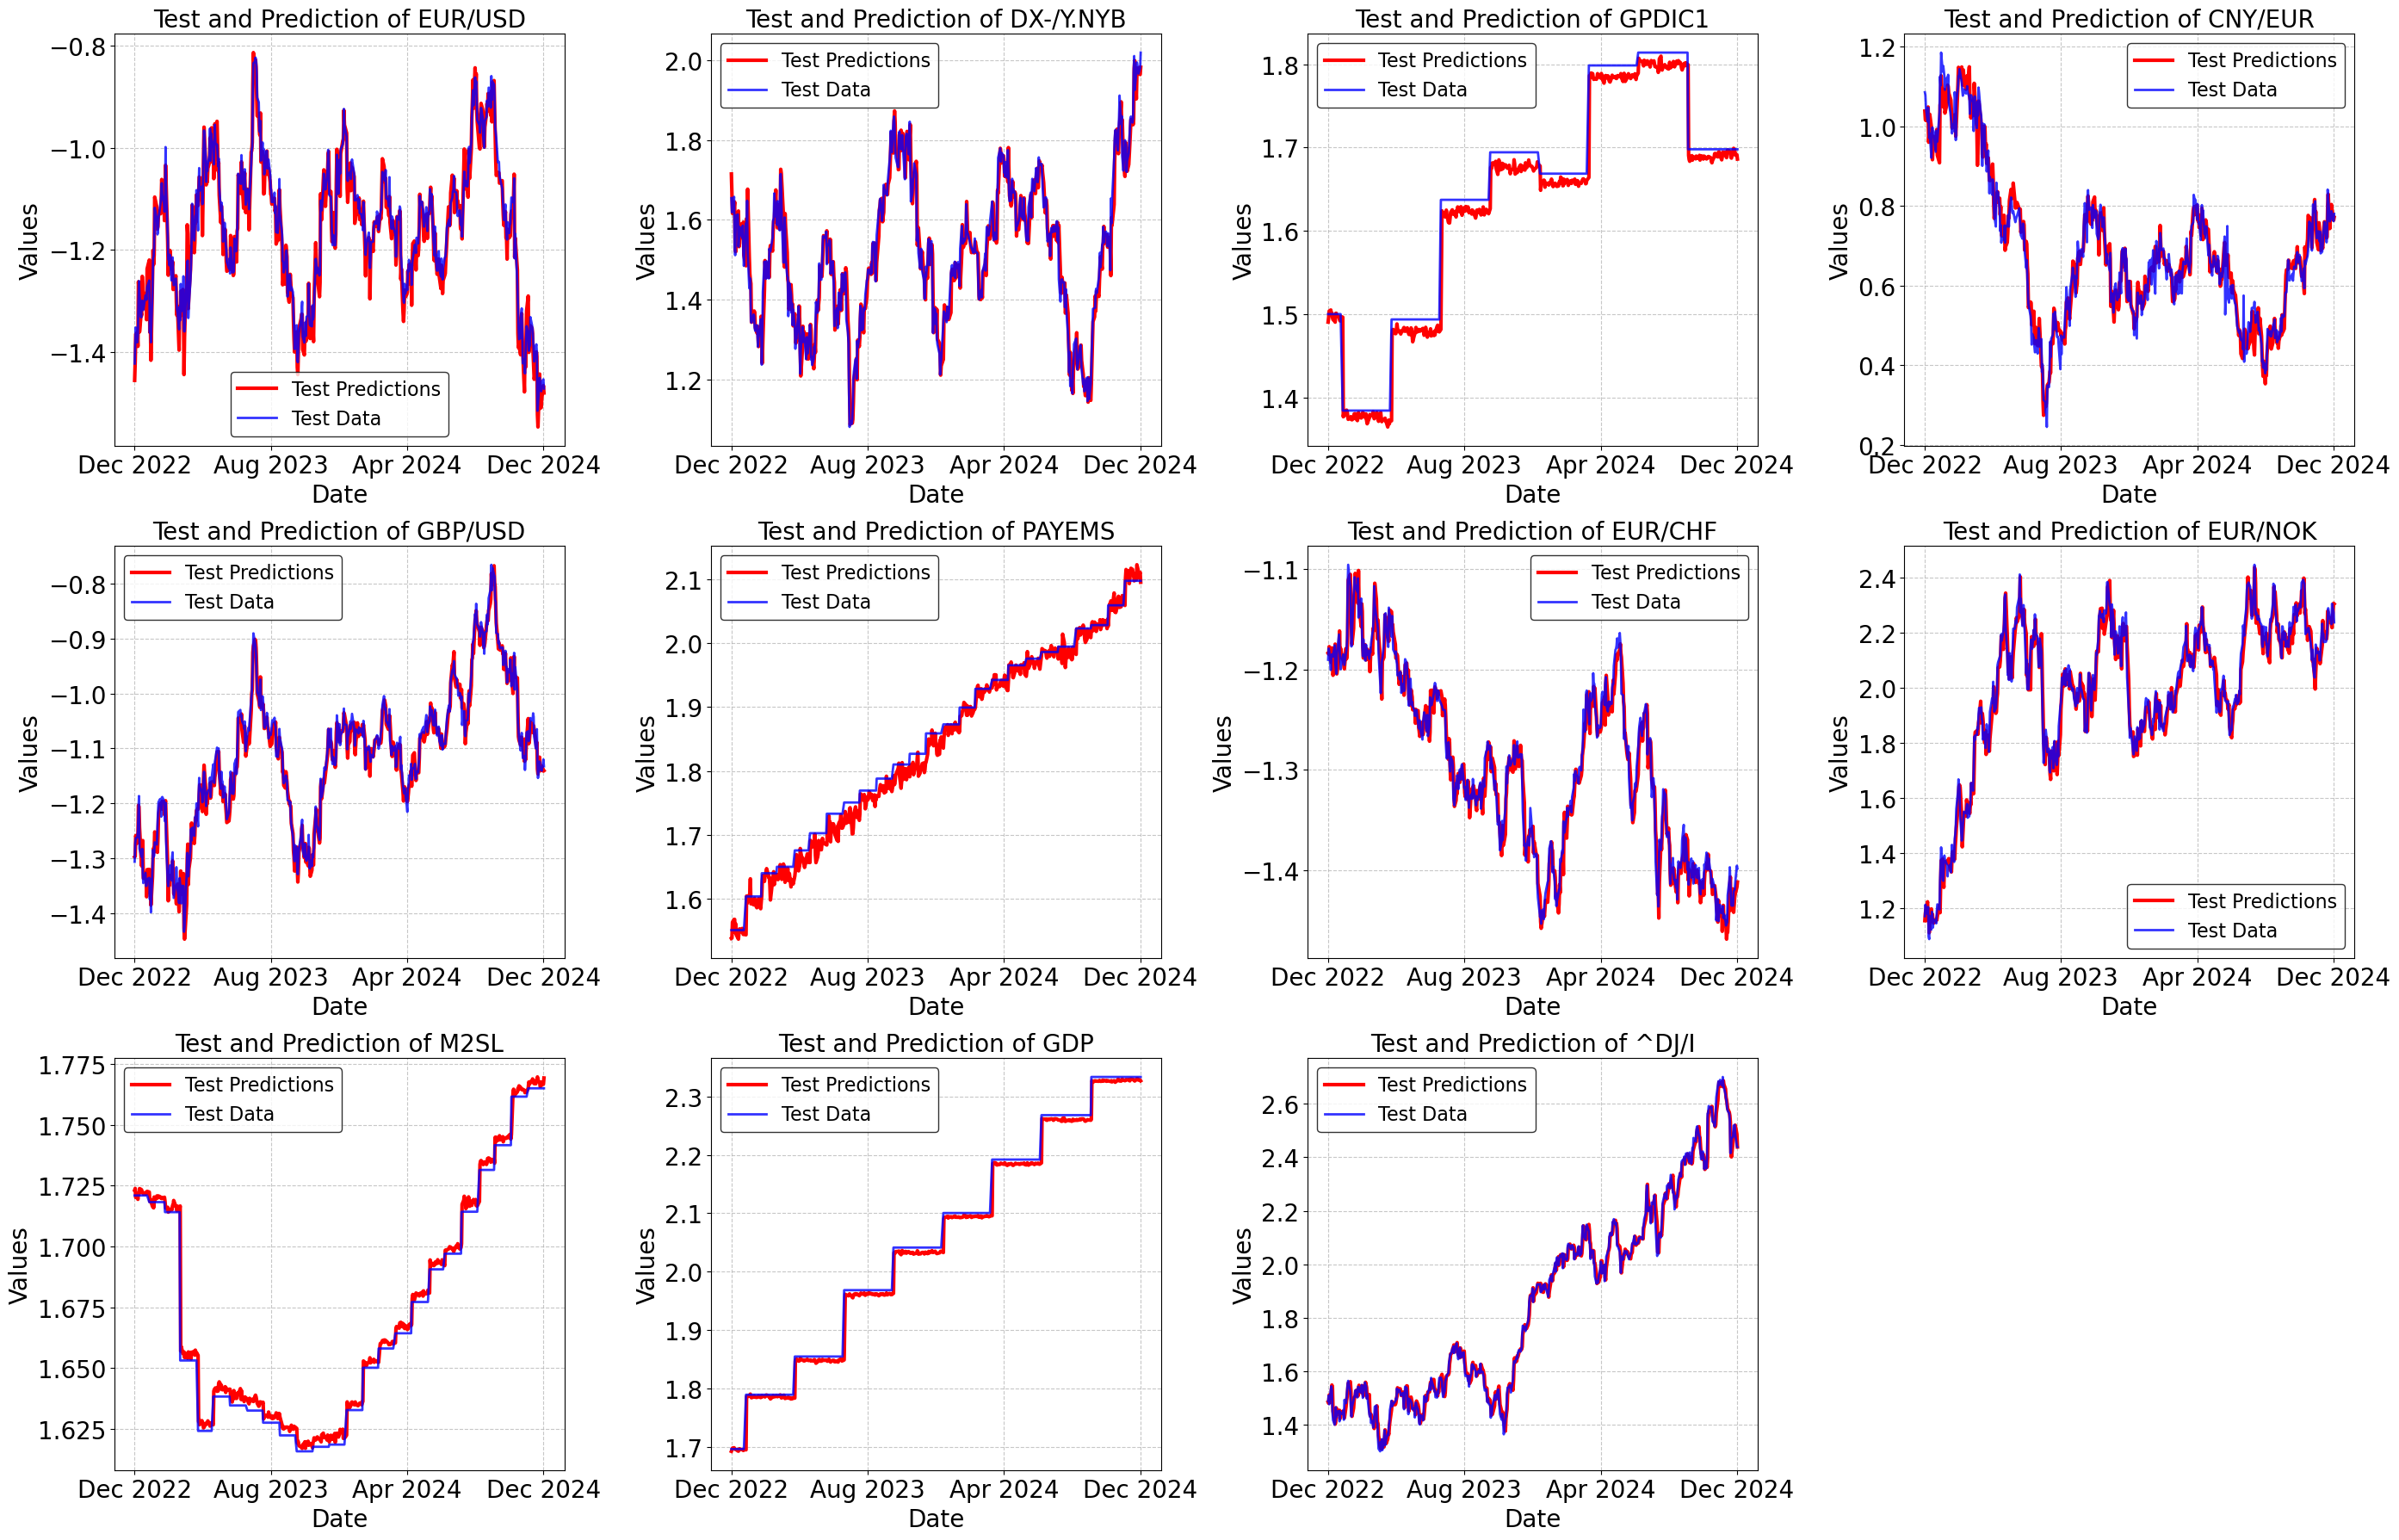

In [13]:

len_test = len(y_test_GDP)
dates_test = pmi_data_nv['Date'][-len_test:]
first_dates_test = dates_test[::len_test // 20]

start_date = first_dates_test.iloc[0]
pmi_data_test = pmi_data_nv[pmi_data_nv['Date'] >= start_date].reset_index(drop=True)

indicators_data = [
    (chosen_currency, y_pred_combined_retail_sales),
    (first_indicator, y_pred_combined_Inflation),
    (second_indicator, y_pred_combined_GDP),
    (third_indicator, y_pred_combined_GPDIC1),
    (fourth_indicator, y_pred_combined_indicator4),
    (fifth_indicator, y_pred_combined_indicator5),
    (sixth_indicator, y_pred_combined_indicator6),
    (seventh_indicator, y_pred_combined_indicator7),
    (eighth_indicator, y_pred_combined_indicator8),
    (ninth_indicator, y_pred_combined_indicator9),
    (tenth_indicator, y_pred_combined_indicator10),
]

n_cols = 4
n_rows = (len(indicators_data) + n_cols - 1) // n_cols

plt.figure(figsize=(28, 6 * n_rows))

sampled_dates_test = dates_test[::len(dates_test) // 3]

for i, (indicator, y_pred) in enumerate(indicators_data, start=1):
    ax = plt.subplot(n_rows, n_cols, i)

    ax.plot(dates_test, y_pred, label='Test Predictions', color='red', linestyle='-', linewidth=3)
    ax.plot(dates_test, pmi_data_test[indicator], label='Test Data', color='blue', linewidth=2, alpha=0.8)

    ax.set_title(f'Test and Prediction of {indicator}', fontsize=20)
    ax.set_xlabel('Date', fontsize=20)
    ax.set_ylabel('Values', fontsize=20)
    ax.legend(edgecolor='black', fontsize=16)

    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.tick_params(axis='x', labelsize=20)
    ax.set_xticks(sampled_dates_test)

    ax.grid(axis='x', linestyle='--', alpha=0.7)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.tick_params(axis='y', labelsize=20)

for j in range(len(indicators_data) + 1, n_rows * n_cols + 1):
    plt.subplot(n_rows, n_cols, j)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [14]:
end_date = pmi_data['Date'].max()
end_date += timedelta(days=5)

def predict_future_values(model_retail_sales, model_Inflation, model_GDP, model_GPDIC1,
                         model_indicator4, model_indicator5, model_indicator6, model_indicator7,
                         model_indicator8, model_indicator9, model_indicator10,
                         start_date, end_date, pmi_data):
    future_dates = pd.date_range(start=start_date, end=end_date, freq='D')

    past_data = pmi_data.iloc[-6:]

    past_retail_sales = past_data[chosen_currency].values.tolist()
    past_Inflation = past_data[first_indicator].values.tolist()
    past_GDP = past_data[second_indicator].values.tolist()
    past_GPDIC1 = past_data[third_indicator].values.tolist()
    past_indicator4 = past_data[fourth_indicator].values.tolist()
    past_indicator5 = past_data[fifth_indicator].values.tolist()
    past_indicator6 = past_data[sixth_indicator].values.tolist()
    past_indicator7 = past_data[seventh_indicator].values.tolist()
    past_indicator8 = past_data[eighth_indicator].values.tolist()
    past_indicator9 = past_data[ninth_indicator].values.tolist()
    past_indicator10 = past_data[tenth_indicator].values.tolist()

    last_historical_row = pmi_data.iloc[-1]
    last_historical_date = pmi_data['Date'].iloc[-1]

    predictions = {
        chosen_currency: [last_historical_row[chosen_currency]],
        first_indicator: [last_historical_row[first_indicator]],
        second_indicator: [last_historical_row[second_indicator]],
        third_indicator: [last_historical_row[third_indicator]],
        fourth_indicator: [last_historical_row[fourth_indicator]],
        fifth_indicator: [last_historical_row[fifth_indicator]],
        sixth_indicator: [last_historical_row[sixth_indicator]],
        seventh_indicator: [last_historical_row[seventh_indicator]],
        eighth_indicator: [last_historical_row[eighth_indicator]],
        ninth_indicator: [last_historical_row[ninth_indicator]],
        tenth_indicator: [last_historical_row[tenth_indicator]]
    }

    for date in future_dates:
        future_pred_retail_sales = model_retail_sales.predict(np.concatenate((
            past_retail_sales, past_Inflation, past_GDP, past_GPDIC1,
            past_indicator4, past_indicator5, past_indicator6, past_indicator7,
            past_indicator8, past_indicator9, past_indicator10)).reshape(1, -1))

        future_pred_Inflation = model_Inflation.predict(np.concatenate((past_Inflation, past_retail_sales, past_GDP, past_GPDIC1, past_indicator4, past_indicator5, past_indicator6, past_indicator7, past_indicator8, past_indicator9, past_indicator10)).reshape(1, -1))
        future_pred_GDP = model_GDP.predict(np.concatenate((past_GDP, past_retail_sales, past_Inflation, past_GPDIC1, past_indicator4, past_indicator5, past_indicator6, past_indicator7, past_indicator8, past_indicator9, past_indicator10)).reshape(1, -1))
        future_pred_GPDIC1 = model_GPDIC1.predict(np.concatenate((past_GPDIC1, past_retail_sales, past_Inflation, past_GDP, past_indicator4, past_indicator5, past_indicator6, past_indicator7, past_indicator8, past_indicator9, past_indicator10)).reshape(1, -1))
        future_pred_indicator4 = model_indicator4.predict(np.concatenate((past_indicator4, past_retail_sales, past_Inflation, past_GDP, past_GPDIC1, past_indicator5, past_indicator6, past_indicator7, past_indicator8, past_indicator9, past_indicator10)).reshape(1, -1))
        future_pred_indicator5 = model_indicator5.predict(np.concatenate((past_indicator5, past_retail_sales, past_Inflation, past_GDP, past_GPDIC1, past_indicator4, past_indicator6, past_indicator7, past_indicator8, past_indicator9, past_indicator10)).reshape(1, -1))
        future_pred_indicator6 = model_indicator6.predict(np.concatenate((past_indicator6, past_retail_sales, past_Inflation, past_GDP, past_GPDIC1, past_indicator4, past_indicator5, past_indicator7, past_indicator8, past_indicator9, past_indicator10)).reshape(1, -1))
        future_pred_indicator7 = model_indicator7.predict(np.concatenate((past_indicator7, past_retail_sales, past_Inflation, past_GDP, past_GPDIC1, past_indicator4, past_indicator5, past_indicator6, past_indicator8, past_indicator9, past_indicator10)).reshape(1, -1))
        future_pred_indicator8 = model_indicator8.predict(np.concatenate((past_indicator8, past_retail_sales, past_Inflation, past_GDP, past_GPDIC1, past_indicator4, past_indicator5, past_indicator6, past_indicator7, past_indicator9, past_indicator10)).reshape(1, -1))
        future_pred_indicator9 = model_indicator9.predict(np.concatenate((past_indicator9, past_retail_sales, past_Inflation, past_GDP, past_GPDIC1, past_indicator4, past_indicator5, past_indicator6, past_indicator7, past_indicator8, past_indicator10)).reshape(1, -1))
        future_pred_indicator10 = model_indicator10.predict(np.concatenate((past_indicator10, past_retail_sales, past_Inflation, past_GDP, past_GPDIC1, past_indicator4, past_indicator5, past_indicator6, past_indicator7, past_indicator8, past_indicator9)).reshape(1, -1))

        predictions[chosen_currency].append(future_pred_retail_sales[0])
        predictions[first_indicator].append(future_pred_Inflation[0])
        predictions[second_indicator].append(future_pred_GDP[0])
        predictions[third_indicator].append(future_pred_GPDIC1[0])
        predictions[fourth_indicator].append(future_pred_indicator4[0])
        predictions[fifth_indicator].append(future_pred_indicator5[0])
        predictions[sixth_indicator].append(future_pred_indicator6[0])
        predictions[seventh_indicator].append(future_pred_indicator7[0])
        predictions[eighth_indicator].append(future_pred_indicator8[0])
        predictions[ninth_indicator].append(future_pred_indicator9[0])
        predictions[tenth_indicator].append(future_pred_indicator10[0])

        past_retail_sales.pop(0); past_retail_sales.append(future_pred_retail_sales[0])
        past_Inflation.pop(0); past_Inflation.append(future_pred_Inflation[0])
        past_GDP.pop(0); past_GDP.append(future_pred_GDP[0])
        past_GPDIC1.pop(0); past_GPDIC1.append(future_pred_GPDIC1[0])
        past_indicator4.pop(0); past_indicator4.append(future_pred_indicator4[0])
        past_indicator5.pop(0); past_indicator5.append(future_pred_indicator5[0])
        past_indicator6.pop(0); past_indicator6.append(future_pred_indicator6[0])
        past_indicator7.pop(0); past_indicator7.append(future_pred_indicator7[0])
        past_indicator8.pop(0); past_indicator8.append(future_pred_indicator8[0])
        past_indicator9.pop(0); past_indicator9.append(future_pred_indicator9[0])
        past_indicator10.pop(0); past_indicator10.append(future_pred_indicator10[0])

    combined_dates = [last_historical_date] + future_dates.tolist()

    future_df = pd.DataFrame(index=combined_dates, data=predictions)
    future_df.index.name = 'Date'

    return future_df

last_date = pmi_data['Date'].max()
start_date = last_date + pd.DateOffset(days=1)
end_date = pd.to_datetime(end_date)

predicted_df = predict_future_values(
    model_retail_sales, model_Inflation, model_GDP, model_GPDIC1,
    model_indicator4, model_indicator5, model_indicator6, model_indicator7,
    model_indicator8, model_indicator9, model_indicator10,
    start_date, end_date, pmi_data
)

columns_to_normalize = [
    chosen_currency, first_indicator, second_indicator, third_indicator,
    fourth_indicator, fifth_indicator, sixth_indicator, seventh_indicator,
    eighth_indicator, ninth_indicator, tenth_indicator
]

if hasattr(scaler, 'n_features_in_') and scaler.n_features_in_ != len(columns_to_normalize):
    from sklearn.preprocessing import StandardScaler
    all_columns = [chosen_currency, first_indicator, second_indicator, third_indicator,
                   fourth_indicator, fifth_indicator, sixth_indicator, seventh_indicator,
                   eighth_indicator, ninth_indicator, tenth_indicator]
    scaler = StandardScaler()
    scaler.fit(pmi_data[all_columns])

predicted_df[columns_to_normalize] = scaler.inverse_transform(predicted_df[columns_to_normalize])

predicted_df

EUR/USD   DX-/Y.NYB       GPDIC1   CNY/EUR   GBP/USD  \
Date                                                                
2024-12-31  1.040615  108.489998  4315.564000  0.131643  1.254910   
2025-01-01  1.035113  108.387744  4307.857375  0.131846  1.250135   
2025-01-02  1.036038  108.308104  4304.818162  0.131595  1.250253   
2025-01-03  1.037761  108.213043  4302.973295  0.131368  1.250816   
2025-01-04  1.038283  108.159022  4297.788719  0.131273  1.250652   
2025-01-05  1.038914  108.101977  4291.917875  0.131170  1.250542   

                   PAYEMS   EUR/CHF    EUR/NOK          M2SL           GDP  \
Date                                                                         
2024-12-31  158942.000000  0.939900  11.788110  21441.800000  29825.182000   
2025-01-01  158967.989032  0.937704  11.786820  21455.074943  29794.693314   
2025-01-02  159029.904053  0.936651  11.794117  21470.322601  29770.811826   
2025-01-03  159171.984471  0.937176  11.803800  21479.029415  29750.109245   
2025-01-04  159163.950437  0.936288  11.810766  21495.522535  29721.006481   
2025-01-05  159163.221272  0.935353  11.809312  21510.383806  29691.634747   

                   ^DJ/I  
Date                      
2024-12-31  42544.218750  
2025-01-01  42486.191921  
2025-01-02  42459.402586  
2025-01-03  42432.795343  
2025-01-04  42356.322466  
2025-01-05  42326.579876

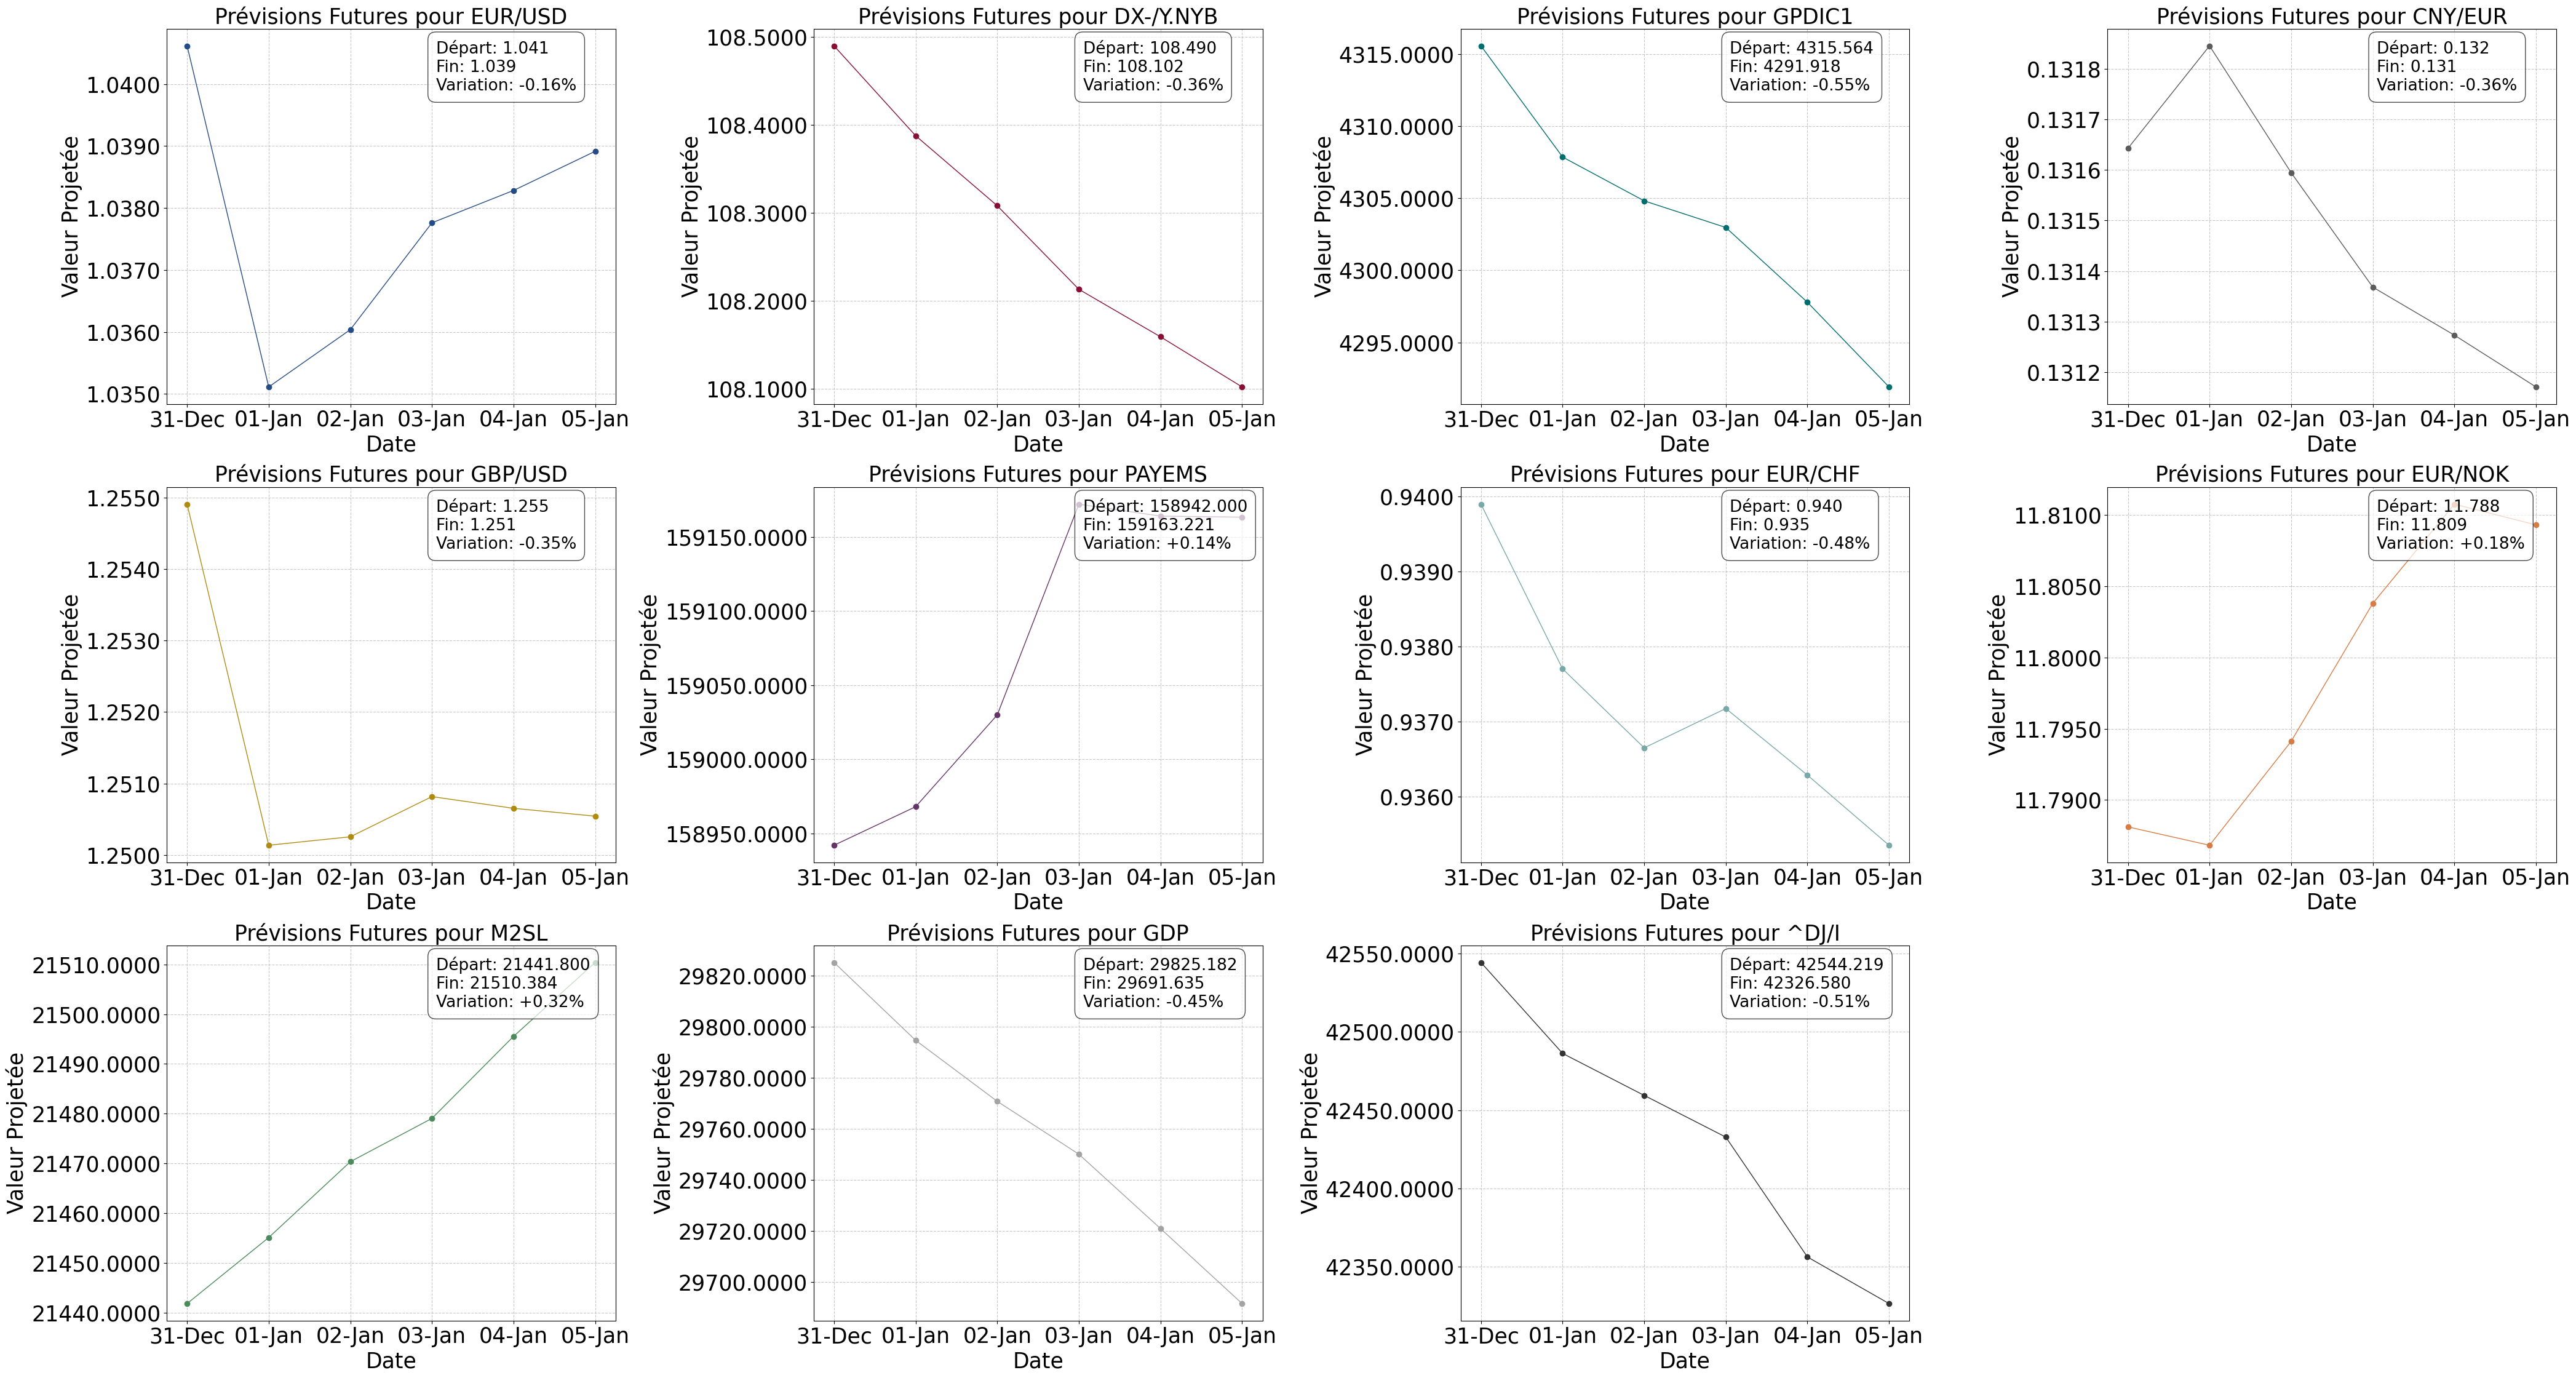

In [15]:
indicator_details = [
    (chosen_currency, '#254b85'),
    (first_indicator, '#880f33'),
    (second_indicator, '#006d6f'),
    (third_indicator, '#5c5c5c'),
    (fourth_indicator, '#b08b12'),
    (fifth_indicator, '#663366'),
    (sixth_indicator, '#79a8a9'),
    (seventh_indicator, '#d77c44'),
    (eighth_indicator, '#4b8a5a'),
    (ninth_indicator, '#a3a3a3'),
    (tenth_indicator, '#333333')
]

n_cols = 4
n_rows = (len(indicator_details) + n_cols - 1) // n_cols

plt.figure(figsize=(42, 7.5 * n_rows))

x = 25
y = 19

for i, (indicator_name, color) in enumerate(indicator_details, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    ax.plot(predicted_df.index, predicted_df[indicator_name], 
            label=f'Prévisions', color=color, linestyle='-', marker='o', linewidth=1)

    ax.set_title(f'Prévisions Futures pour {indicator_name}', fontsize=x)

    ax.set_xlabel('Date', fontsize=x)
    ax.set_ylabel('Valeur Projetée', fontsize=x)
    ax.tick_params(axis='y', labelsize=x)
    ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.4f'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    plt.xticks(rotation=0, ha='center', fontsize=x)
    plt.yticks(fontsize=x)
    ax.grid(axis='both', linestyle='--', alpha=0.7)

    start_val = predicted_df[indicator_name].iloc[0]
    end_val = predicted_df[indicator_name].iloc[-1]
    if np.allclose(start_val, 0):
        pct_change_text = "N/A"
    else:
        pct_change = ((end_val - start_val) / start_val) * 100
        pct_change_text = f'{pct_change:+.2f}%'

    ax.text(0.6, 0.97, 
            f'Départ: {start_val:.3f}\nFin: {end_val:.3f}\nVariation: {pct_change_text}',
            transform=ax.transAxes, fontsize=y, verticalalignment='top',
            bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7))

for j in range(len(indicator_details), n_rows * n_cols):
    plt.subplot(n_rows, n_cols, j + 1)
    plt.axis('off')

plt.tight_layout()
plt.show()


---

## Étape 2: Évaluation du risque de volatilités futures sur le marché de change

In [60]:
from matplotlib.ticker import FuncFormatter
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from joblib import Memory
from arch import arch_model
import traceback
from tqdm import tqdm
import matplotlib.ticker as mticker
from scipy.stats import norm


In [17]:
pmi_data[columns_to_normalize] = scaler.inverse_transform(pmi_data[columns_to_normalize])
pmi_data['Date'] = pd.to_datetime(pmi_data['Date'])
pmi_data

EUR/USD   DX-/Y.NYB    GPDIC1   CNY/EUR   GBP/USD    PAYEMS  EUR/CHF  \
0     1.196501   90.349998  2493.928  0.100850  1.718597  130589.0  1.55250   
1     1.208897   89.639999  2493.928  0.099770  1.730313  130589.0  1.55620   
2     1.212298   89.500000  2493.928  0.099700  1.728101  130589.0  1.55790   
3     1.208094   89.599998  2493.928  0.099870  1.720697  130589.0  1.55600   
4     1.218695   89.139999  2493.928  0.099180  1.733102  130589.0  1.55040   
...        ...         ...       ...       ...       ...       ...      ...   
5201  1.040583  108.260002  4315.564  0.131674  1.253447  158942.0  0.93486   
5202  1.039955  108.129997  4315.564  0.131747  1.254375  158942.0  0.93525   
5203  1.042318  108.000000  4315.564  0.131454  1.252976  158942.0  0.93683   
5204  1.042938  108.129997  4315.564  0.131359  1.257881  158942.0  0.94052   
5205  1.040615  108.489998  4315.564  0.131643  1.254910  158942.0  0.93990   

       EUR/NOK     M2SL        GDP         ^DJ/I       Date  
0      8.16400   6074.0  11772.234   9899.049805 2003-12-01  
1      8.16350   6074.0  11772.234   9853.639648 2003-12-02  
2      8.11800   6074.0  11772.234   9873.419922 2003-12-03  
3      8.08380   6074.0  11772.234   9930.820312 2003-12-04  
4      8.08250   6074.0  11772.234   9862.679688 2003-12-05  
...        ...      ...        ...           ...        ...  
5201  11.81031  21441.8  29825.182  43297.031250 2024-12-24  
5202  11.77991  21441.8  29825.182  43325.800781 2024-12-26  
5203  11.87089  21441.8  29825.182  42992.210938 2024-12-27  
5204  11.83283  21441.8  29825.182  42573.730469 2024-12-30  
5205  11.78811  21441.8  29825.182  42544.218750 2024-12-31  

[5206 rows x 12 columns]

In [18]:
predicted_df = predicted_df.iloc[1:]
predicted_df

EUR/USD   DX-/Y.NYB       GPDIC1   CNY/EUR   GBP/USD  \
Date                                                                
2025-01-01  1.035113  108.387744  4307.857375  0.131846  1.250135   
2025-01-02  1.036038  108.308104  4304.818162  0.131595  1.250253   
2025-01-03  1.037761  108.213043  4302.973295  0.131368  1.250816   
2025-01-04  1.038283  108.159022  4297.788719  0.131273  1.250652   
2025-01-05  1.038914  108.101977  4291.917875  0.131170  1.250542   

                   PAYEMS   EUR/CHF    EUR/NOK          M2SL           GDP  \
Date                                                                         
2025-01-01  158967.989032  0.937704  11.786820  21455.074943  29794.693314   
2025-01-02  159029.904053  0.936651  11.794117  21470.322601  29770.811826   
2025-01-03  159171.984471  0.937176  11.803800  21479.029415  29750.109245   
2025-01-04  159163.950437  0.936288  11.810766  21495.522535  29721.006481   
2025-01-05  159163.221272  0.935353  11.809312  21510.383806  29691.634747   

                   ^DJ/I  
Date                      
2025-01-01  42486.191921  
2025-01-02  42459.402586  
2025-01-03  42432.795343  
2025-01-04  42356.322466  
2025-01-05  42326.579876

In [19]:
exog_variable_names = [first_indicator, second_indicator, third_indicator, fourth_indicator, fifth_indicator, sixth_indicator, seventh_indicator, eighth_indicator, ninth_indicator, tenth_indicator]
num_exog_vars = len(exog_variable_names)


print("\nCalcul des log-rendements pour la devise et les variables exogènes...")

# 1. Log-rendements pour la devise cible
target_col_raw = chosen_currency
target_col = f'Log_Returns_{chosen_currency.replace("/", "")}'

pmi_data = pmi_data[pmi_data[target_col_raw] > 0].copy()
pmi_data[target_col] = np.log(pmi_data[target_col_raw] / pmi_data[target_col_raw].shift(1)) * 100
print(f"Log-rendements calculés pour {chosen_currency}.")

# 2. Log-rendements pour les variables exogènes
exog_log_return_names = []

for var in exog_variable_names:
    log_return_col = f'Log_Returns_{var}'
    exog_log_return_names.append(log_return_col)

    temp = pmi_data[pmi_data[var] > 0].copy()
    pmi_data[log_return_col] = np.log(temp[var] / temp[var].shift(1)) * 100

    print(f"Log-rendements calculés pour {var}.")

exog_variable_names = exog_log_return_names
num_exog_vars = len(exog_variable_names)

print(f"\nVariables exogènes finales ({num_exog_vars}): {exog_variable_names}")
print("*** NOTE: Toutes les colonnes utilisées pour la modélisation sont maintenant en log-rendements * 100 ***")



Calcul des log-rendements pour la devise et les variables exogènes...
Log-rendements calculés pour EUR/USD.
Log-rendements calculés pour DX-/Y.NYB.
Log-rendements calculés pour GPDIC1.
Log-rendements calculés pour CNY/EUR.
Log-rendements calculés pour GBP/USD.
Log-rendements calculés pour PAYEMS.
Log-rendements calculés pour EUR/CHF.
Log-rendements calculés pour EUR/NOK.
Log-rendements calculés pour M2SL.
Log-rendements calculés pour GDP.
Log-rendements calculés pour ^DJ/I.

Variables exogènes finales (10): ['Log_Returns_DX-/Y.NYB', 'Log_Returns_GPDIC1', 'Log_Returns_CNY/EUR', 'Log_Returns_GBP/USD', 'Log_Returns_PAYEMS', 'Log_Returns_EUR/CHF', 'Log_Returns_EUR/NOK', 'Log_Returns_M2SL', 'Log_Returns_GDP', 'Log_Returns_^DJ/I']
*** NOTE: Toutes les colonnes utilisées pour la modélisation sont maintenant en log-rendements * 100 ***



Vérification des dates :
Première date : 2003-12-01 00:00:00
Dernière date : 2024-12-31 00:00:00
Nombre total de dates : 5206


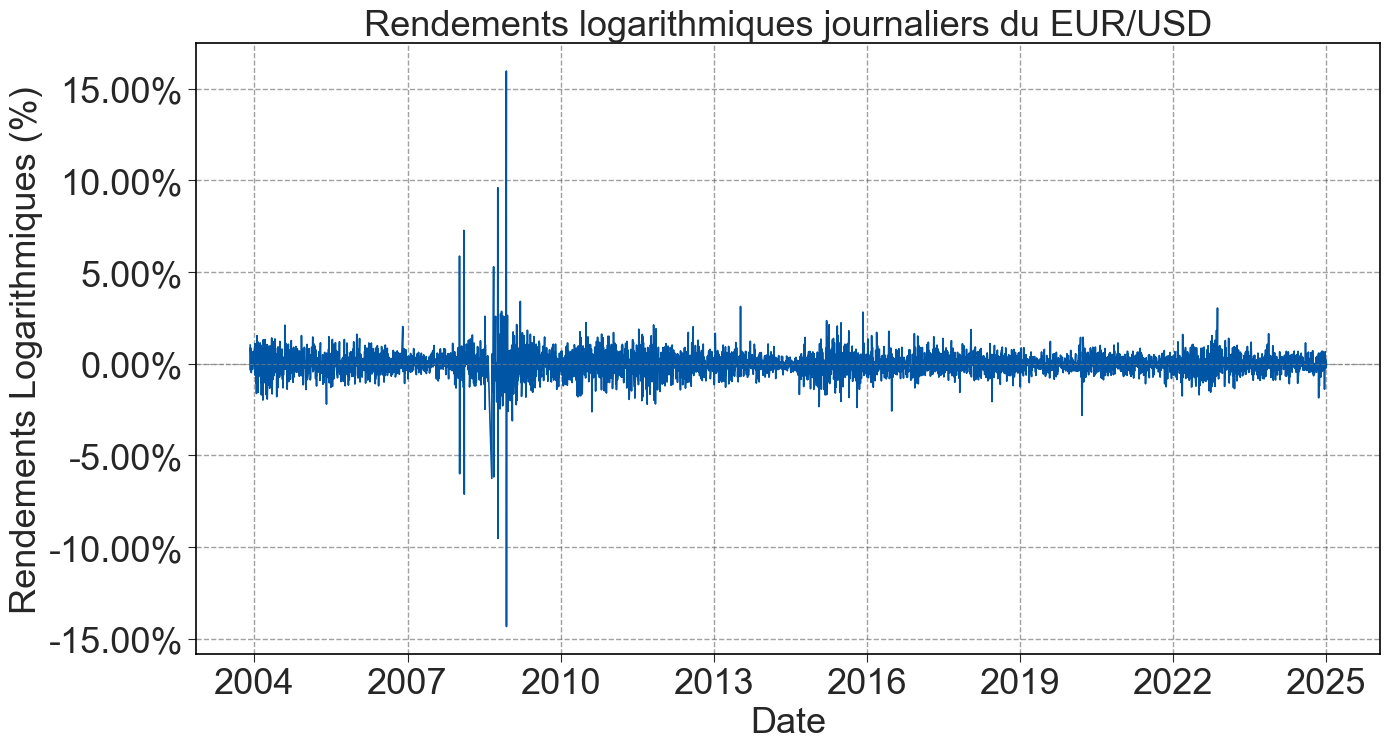

In [20]:
if 'Date' not in pmi_data.columns:
    raise ValueError("La colonne 'Date' est introuvable dans le DataFrame")

pmi_data['Date'] = pd.to_datetime(pmi_data['Date'])

print("\nVérification des dates :")
print("Première date :", pmi_data['Date'].iloc[0])
print("Dernière date :", pmi_data['Date'].iloc[-1])
print("Nombre total de dates :", len(pmi_data['Date']))

clean_data = pmi_data[[target_col, 'Date']].dropna()

plt.style.use('seaborn-v0_8-ticks')

fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(clean_data['Date'], clean_data[target_col],
        color='#0055A5',
        linewidth=1.2,
        label=f'Rendements journaliers de {chosen_currency}')

ax.axhline(0, color='grey', linestyle='--', linewidth=0.8, alpha=0.7)

ax.fill_between(clean_data['Date'], 0, clean_data[target_col],
                where=clean_data[target_col] >= 0,
                facecolor='#0055A5',
                alpha=0.1)
ax.fill_between(clean_data['Date'], 0, clean_data[target_col],
                where=clean_data[target_col] < 0,
                facecolor='#E74C3C',
                alpha=0.1)

ax.set_title(f'Rendements logarithmiques journaliers du {chosen_currency}', fontsize=26)

ax.set_ylabel('Rendements Logarithmiques (%)', fontsize=26)
ax.set_xlabel('Date', fontsize=26)

ax.tick_params(axis='both', which='major', labelsize=26)

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2f}%'))

ax.xaxis.set_major_locator(mdates.YearLocator(base=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax.get_xticklabels(), rotation=0, ha='center')

ax.grid(axis='y', linestyle='--', linewidth=1, color='#444444', alpha=0.5)
ax.grid(axis='x', linestyle='--', linewidth=1, color='#444444', alpha=0.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.2)
    spine.set_color('black')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


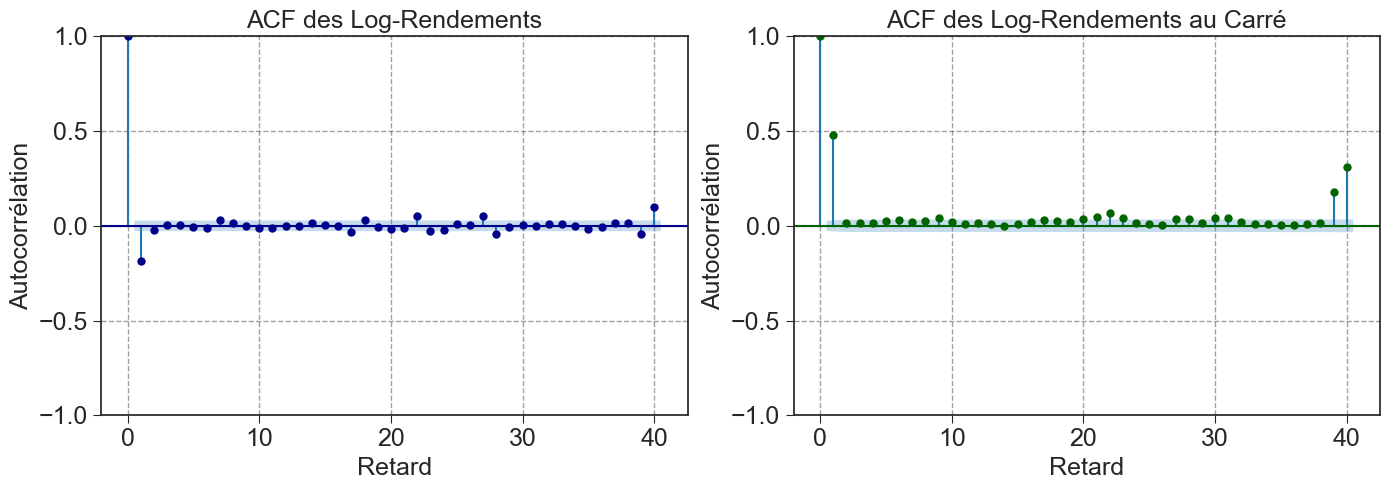

In [21]:
log_returns_series = clean_data[target_col].dropna()
log_returns_squared_series = log_returns_series**2

title_fontsize = 18
label_fontsize = 18
tick_fontsize = 18

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))  # Plus large pour aérer

plot_acf(log_returns_series, lags=40, ax=ax1, color='#00008B')
ax1.set_title('ACF des Log-Rendements', fontsize=title_fontsize)
ax1.set_xlabel('Retard', fontsize=label_fontsize)
ax1.set_ylabel('Autocorrélation', fontsize=label_fontsize)
ax1.tick_params(axis='both', labelsize=tick_fontsize)
ax1.grid(True,linestyle='--', linewidth=1, color='#444444', alpha=0.5)

plot_acf(log_returns_squared_series, lags=40, ax=ax2, color='#006400')
ax2.set_title('ACF des Log-Rendements au Carré', fontsize=title_fontsize)
ax2.set_xlabel('Retard', fontsize=label_fontsize)
ax2.set_ylabel('Autocorrélation', fontsize=label_fontsize)
ax2.tick_params(axis='both', labelsize=tick_fontsize)
ax2.grid(True,linestyle='--', linewidth=1, color='#444444', alpha=0.5)

plt.tight_layout()
plt.show()

In [22]:
def perform_adf_test(series, series_name):
    print(f"\n--- Résultats du Test ADF pour la série : '{series_name}' ---")
    adf_result = adfuller(series.dropna(), autolag='AIC')

    adf_statistic = adf_result[0]
    p_value = adf_result[1]
    critical_values = adf_result[4]

    print(f"Statistique de Test ADF : {adf_statistic:.4f}")
    print(f"P-value : {p_value:.4f}")
    print("Valeurs Critiques :")
    for key, value in critical_values.items():
        print(f"   {key}: {value:.4f}")

    print("\nInterprétation :")
    if p_value <= 0.05 and adf_statistic < critical_values['5%']:
        print(f"  Conclusion : La p-value ({p_value:.4f}) est inférieure à 0.05.")
        print("  On rejette l'hypothèse nulle (H0).")
        print(f"  => La série '{series_name}' est considérée comme STATIONNAIRE.")
    else:
        print(f"  Conclusion : La p-value ({p_value:.4f}) est supérieure à 0.05.")
        print("  On ne peut pas rejeter l'hypothèse nulle (H0).")
        print(f"  => La série '{series_name}' est considérée comme NON-STATIONNAIRE (présence d'une racine unitaire).")


if 'pmi_data' in globals() and 'target_col_raw' in globals() and target_col_raw in pmi_data.columns:
    price_series = pmi_data[target_col_raw]
    perform_adf_test(price_series, f"Taux de Change {chosen_currency} (Niveaux)")
else:
    print(f"\nAVERTISSEMENT: Impossible d'exécuter le test ADF sur les prix bruts car 'pmi_data' ou la colonne '{target_col_raw}' ne sont pas disponibles.")


if 'log_returns_series' in globals() and isinstance(log_returns_series, pd.Series) and not log_returns_series.empty:
    perform_adf_test(log_returns_series, f"Log-Rendements de {chosen_currency}")
else:
    print("\nAVERTISSEMENT: Impossible d'exécuter le test ADF sur les log-rendements car 'log_returns_series' n'est pas disponible.")


--- Résultats du Test ADF pour la série : 'Taux de Change EUR/USD (Niveaux)' ---
Statistique de Test ADF : -1.8124
P-value : 0.3743
Valeurs Critiques :
   1%: -3.4316
   5%: -2.8621
   10%: -2.5671

Interprétation :
  Conclusion : La p-value (0.3743) est supérieure à 0.05.
  On ne peut pas rejeter l'hypothèse nulle (H0).
  => La série 'Taux de Change EUR/USD (Niveaux)' est considérée comme NON-STATIONNAIRE (présence d'une racine unitaire).

--- Résultats du Test ADF pour la série : 'Log-Rendements de EUR/USD' ---
Statistique de Test ADF : -13.4303
P-value : 0.0000
Valeurs Critiques :
   1%: -3.4316
   5%: -2.8621
   10%: -2.5671

Interprétation :
  Conclusion : La p-value (0.0000) est inférieure à 0.05.
  On rejette l'hypothèse nulle (H0).
  => La série 'Log-Rendements de EUR/USD' est considérée comme STATIONNAIRE.


In [23]:
p_orders_to_test = range(1, 4)
q_orders_to_test = range(0, 4)

pdq_orders_list = []
for p_val in p_orders_to_test:
    for q_val in q_orders_to_test:
        if p_val == 0 and q_val == 0:
            continue
        if p_val > 0 :
             pdq_orders_list.append((p_val, q_val))

print(f"Ordres GARCH-X (p,q) à tester : {pdq_orders_list}")
print(f"  Nombre de combinaisons (p,q) à tester : {len(pdq_orders_list)}")

update_frequency = 5
print(f"Fréquence de réajustement simple du modèle (si utilisée) : {update_frequency} pas")

window_size = 125
step_size = 5

print(f"Taille de la fenêtre d'entraînement (window_size) : {window_size} pas")
print(f"Fréquence de ré-évaluation des ordres (p,q) (step_size) : {step_size} pas")

Ordres GARCH-X (p,q) à tester : [(1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]
  Nombre de combinaisons (p,q) à tester : 12
Fréquence de réajustement simple du modèle (si utilisée) : 5 pas
Taille de la fenêtre d'entraînement (window_size) : 125 pas
Fréquence de ré-évaluation des ordres (p,q) (step_size) : 5 pas


In [24]:
pmi_data = pd.DataFrame(pmi_data)
chosen_currency = str(chosen_currency)

pmi_data['Date'] = pd.to_datetime(pmi_data['Date'])

print("\nPréparation et vérification des données pour la modélisation...")

missing_cols = [col for col in exog_variable_names if col not in pmi_data.columns]
assert not missing_cols, f"Colonnes exogènes (log-returns) manquantes dans pmi_data: {missing_cols}"

assert target_col in pmi_data.columns, f"Colonne cible (log-returns) '{target_col}' manquante dans pmi_data."

print("Colonnes requises présentes dans pmi_data.")

data_subset = pmi_data[[target_col] + exog_variable_names].copy()
print(f"Taille initiale du sous-ensemble de données (target + exogènes): {data_subset.shape}")

data_subset.replace([np.inf, -np.inf], np.nan, inplace=True)
initial_rows = len(data_subset)
data_subset.dropna(inplace=True)
final_rows = len(data_subset)

removed_rows_count = initial_rows - final_rows
if removed_rows_count > 0:
    print(f"Nombre de lignes supprimées à cause de NaN ou Inf: {removed_rows_count}")
else:
    print("Aucune ligne supprimée pour NaN ou Inf.")
print(f"Taille finale du sous-ensemble de données après nettoyage: {data_subset.shape}")

Y = data_subset[target_col].values
exog_data_raw = data_subset[exog_variable_names].values
original_index = data_subset.index

print(f"Shapes après nettoyage final - Rendements (Y): {Y.shape}, Exogènes brutes (X_raw): {exog_data_raw.shape}")

assert Y.ndim == 1, f"Y devrait être un array 1D, mais a {Y.ndim} dimensions."
assert exog_data_raw.ndim == 2, f"exog_data_raw devrait être un array 2D, mais a {exog_data_raw.ndim} dimensions."
assert Y.shape[0] == exog_data_raw.shape[0], \
    f"Discordance du nombre d'observations entre Y ({Y.shape[0]}) et exog_data_raw ({exog_data_raw.shape[0]}) après nettoyage final."
assert Y.shape[0] > 0, \
    "Aucune donnée restante après nettoyage. Vérifiez les NaNs/Infs initiaux, le filtrage des données ou la disponibilité des données pour la période sélectionnée."
assert exog_data_raw.shape[1] == num_exog_vars, \
    f"Nombre de colonnes exogènes incorrect. Attendu: {num_exog_vars}, Obtenu: {exog_data_raw.shape[1]}"

exog_data = exog_data_raw.copy()
print("Utilisation des variables exogènes nettoyées (exog_data_raw) sans normalisation StandardScaler supplémentaire ici.")

print(f"Shape des variables exogènes finales (exog_data): {exog_data.shape}")



Préparation et vérification des données pour la modélisation...
Colonnes requises présentes dans pmi_data.
Taille initiale du sous-ensemble de données (target + exogènes): (5206, 11)
Nombre de lignes supprimées à cause de NaN ou Inf: 1
Taille finale du sous-ensemble de données après nettoyage: (5205, 11)
Shapes après nettoyage final - Rendements (Y): (5205,), Exogènes brutes (X_raw): (5205, 10)
Utilisation des variables exogènes nettoyées (exog_data_raw) sans normalisation StandardScaler supplémentaire ici.
Shape des variables exogènes finales (exog_data): (5205, 10)


In [25]:
cache_folder_name = f'cache_garchx_sliding_pq_exog{num_exog_vars}'
memory = Memory(location=cache_folder_name, verbose=0)
print(f"Le cache des résultats des ajustements de modèles sera stocké dans : '{cache_folder_name}'")

@memory.cache
def fit_garch_x(train_y, train_x, order_pq):
    train_y_contig = np.ascontiguousarray(train_y)
    train_x_contig = np.ascontiguousarray(train_x) if train_x is not None and train_x.size > 0 else None
    p_arch, q_garch = order_pq
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model = arch_model(train_y_contig, x=train_x_contig,
                               mean='ARX', lags=0,
                               vol='GARCH', p=p_arch, q=q_garch,
                               dist='normal',
                               rescale=False)
            results = model.fit(disp='off', update_freq=0, options={'maxiter': 1000})

        if results.convergence_flag == 0 and np.isfinite(results.aic):
             return results.aic, results
        else:
             return float('inf'), None

    except (ValueError, np.linalg.LinAlgError, OverflowError) as numeric_error:
        return float('inf'), None
    except Exception as unexpected_error:
        return float('inf'), None

if not pdq_orders_list:
    raise ValueError("La liste 'pdq_orders_list' des ordres (p,q) à tester est vide.")

max_p_tested = 0
max_q_tested = 0
for p_ord, q_ord in pdq_orders_list:
    if p_ord > max_p_tested:
        max_p_tested = p_ord
    if q_ord > max_q_tested:
        max_q_tested = q_ord

print(f"Ordre ARCH maximum (max_p) testé : {max_p_tested}")
print(f"Ordre GARCH maximum (max_q) testé : {max_q_tested}")

min_params_mean = 1 + num_exog_vars
min_params_vol = 1 + max_p_tested + max_q_tested
min_obs_needed_approx = min_params_mean + min_params_vol + 15

print(f"Estimation du minimum d'observations requises pour la fenêtre : {min_obs_needed_approx} "
      f"(pour p={max_p_tested}, q={max_q_tested}, {num_exog_vars} exogènes)")

if window_size < min_obs_needed_approx:
    warnings.warn(
        f"ATTENTION: La taille de la fenêtre ({window_size}) est potentiellement INSUFFISANTE "
        f"pour les ordres maximum testés (p={max_p_tested}, q={max_q_tested}). "
        f"Minimum estimé ~{min_obs_needed_approx}. Risque élevé d'erreurs de convergence ou de modèles non fiables.",
        UserWarning
    )
elif window_size < min_obs_needed_approx + 30:
     warnings.warn(
        f"AVERTISSEMENT: La taille de la fenêtre ({window_size}) pourrait être juste "
        f"pour les ordres maximum testés (p={max_p_tested}, q={max_q_tested}). "
        f"Minimum estimé ~{min_obs_needed_approx}. Recommandé : au moins {min_obs_needed_approx + 30} pour plus de stabilité.",
        UserWarning
    )

if window_size >= len(Y):
    raise ValueError(
        f"ERREUR CRITIQUE: La taille de la fenêtre ({window_size}) est supérieure ou égale "
        f"au nombre total d'observations disponibles après nettoyage ({len(Y)}). "
        f"Réduisez la taille de la fenêtre (window_size) ou vérifiez votre processus de nettoyage des données."
    )

results_selection_history = []
forecasts = []
actuals = []
actual_indices = []

print("Listes de stockage des résultats initialisées.")


Le cache des résultats des ajustements de modèles sera stocké dans : 'cache_garchx_sliding_pq_exog10'
Ordre ARCH maximum (max_p) testé : 3
Ordre GARCH maximum (max_q) testé : 3
Estimation du minimum d'observations requises pour la fenêtre : 33 (pour p=3, q=3, 10 exogènes)
Listes de stockage des résultats initialisées.


In [26]:
print("\nDémarrage de la Validation Croisée par Fenêtre Glissante (avec analyse étendue)...")
print(f"Taille Fenêtre: {window_size}, Fréquence Sélection Modèle (p,q): {step_size} pas")
print(f"Nombre de combinaisons (p,q) testées à chaque sélection: {len(pdq_orders_list)}")

current_best_params_cv = None
last_model_selection_step_cv = -step_size

try:
    for t in tqdm(range(window_size, len(Y)), desc="Sliding Window CV"):
        train_start_idx = t - window_size
        train_end_idx = t
        predict_idx = t

        Y_train_window = Y[train_start_idx:train_end_idx]
        exog_train_window = exog_data[train_start_idx:train_end_idx, :] if exog_data.ndim == 2 else exog_data[train_start_idx:train_end_idx]

        if predict_idx < exog_data.shape[0]:
            exog_for_forecast = exog_data[predict_idx:predict_idx + 1, :]
        else:
            print(f"\nArrêt anticipé au pas {t}: Plus de données exogènes disponibles pour la prévision à l'indice {predict_idx} "
                  f"(exog_data a {exog_data.shape[0]} lignes).")
            break

        if exog_for_forecast.shape[0] == 0:
            print(f"\nArrêt anticipé (vérification secondaire) au pas {t}: exog_for_forecast est vide à l'indice {predict_idx}.")
            break

        model_to_use_for_forecast = None

        perform_selection = (current_best_params_cv is None) or \
                            ((t - window_size) >= last_model_selection_step_cv + step_size)

        if perform_selection:
            last_model_selection_step_cv = t - window_size

            window_best_aic = float('inf')
            window_best_model_obj = None
            window_best_params_tuple = None
            window_best_alpha_sum = np.nan
            window_best_beta_sum = np.nan
            window_best_alpha_plus_beta_sum = np.nan

            for order_tuple in pdq_orders_list:
                aic_loop, model_results_loop = fit_garch_x(Y_train_window, exog_train_window, order_tuple)

                if model_results_loop is not None and np.isfinite(aic_loop) and aic_loop < window_best_aic:
                    window_best_aic = aic_loop
                    window_best_model_obj = model_results_loop
                    window_best_params_tuple = order_tuple

                    try:
                        params_dict = window_best_model_obj.params
                        alpha_sum_loop = sum(params_dict[p_name] for p_name in params_dict.index if 'alpha' in p_name)
                        beta_sum_loop = sum(params_dict[p_name] for p_name in params_dict.index if 'beta' in p_name)

                        window_best_alpha_sum = alpha_sum_loop
                        window_best_beta_sum = beta_sum_loop
                        window_best_alpha_plus_beta_sum = alpha_sum_loop + beta_sum_loop
                    except (AttributeError, KeyError, TypeError) as e_param_extract:
                        window_best_alpha_sum = np.nan
                        window_best_beta_sum = np.nan
                        window_best_alpha_plus_beta_sum = np.nan

            if window_best_model_obj:
                current_best_params_cv = window_best_params_tuple
                model_to_use_for_forecast = window_best_model_obj

                results_selection_history.append({
                    'step_idx_data': t,
                    'window_start_offset': t - window_size,
                    'selected_params': current_best_params_cv,
                    'aic': window_best_aic,
                    'alpha_sum': window_best_alpha_sum,
                    'beta_sum': window_best_beta_sum,
                    'alpha_plus_beta_sum': window_best_alpha_plus_beta_sum
                })
            else:
                warnings.warn(f"Pas {t-window_size} (t={t}): ÉCHEC DE LA SÉLECTION - Aucun modèle n'a convergé avec succès sur cette fenêtre.", UserWarning)

        else:
            if current_best_params_cv:
                aic_refit, refit_model_obj = fit_garch_x(Y_train_window, exog_train_window, current_best_params_cv)
                if refit_model_obj:
                    model_to_use_for_forecast = refit_model_obj
                else:
                    warnings.warn(f"Pas {t-window_size} (t={t}): ÉCHEC DU RÉAJUSTEMENT du modèle {current_best_params_cv}.", UserWarning)

        if model_to_use_for_forecast:
            try:
                current_num_exog_vars = exog_for_forecast.shape[1]
                forecast_input_x_dict = { f'x{idx}': exog_for_forecast[:, idx] for idx in range(current_num_exog_vars) }

                forecast_result = model_to_use_for_forecast.forecast(
                    horizon=1, x=forecast_input_x_dict, reindex=False, method='analytic'
                )
                forecast_variance = forecast_result.variance.values[0, 0]

                if np.isfinite(forecast_variance) and forecast_variance > 1e-12:
                    forecasts.append(forecast_variance)
                else:
                    warnings.warn(
                        f"Prévision de variance invalide (={forecast_variance:.4f}) générée au pas {t-window_size} (t={t}) "
                        f"avec params {model_to_use_for_forecast.model.volatility.name if hasattr(model_to_use_for_forecast, 'model') else current_best_params_cv}. Stockage de NaN.", UserWarning
                    )
                    forecasts.append(np.nan)

            except Exception as forecast_err:
                warnings.warn(
                    f"Erreur de prévision au pas {t-window_size} (t={t}) "
                    f"avec params {model_to_use_for_forecast.model.volatility.name if hasattr(model_to_use_for_forecast, 'model') else current_best_params_cv}: {forecast_err}", UserWarning
                )
                forecasts.append(np.nan)
        else:
            forecasts.append(np.nan)

        actuals.append(Y[predict_idx]**2)

        try:
            actual_indices.append(pd.Timestamp.now() + pd.Timedelta(days=predict_idx) if not isinstance(pmi_data, dict) and 'Date' not in pmi_data else pmi_data["Date"].iloc[predict_idx])

        except (KeyError, IndexError, AttributeError) as date_err:
            actual_indices.append(predict_idx)

except KeyboardInterrupt:
    print("\nValidation croisée interrompue par l'utilisateur.")
except Exception as e_main_loop:
    print(f"\nUne erreur inattendue est survenue PENDANT la boucle principale de validation croisée: {e_main_loop}")
    traceback.print_exc()

print("\nValidation Croisée Terminée.")
if len(forecasts) != len(actuals) or len(forecasts) != len(actual_indices):
    print(f"ATTENTION: Discordance de longueur dans les listes de résultats ! F:{len(forecasts)}, A:{len(actuals)}, I:{len(actual_indices)}")


Démarrage de la Validation Croisée par Fenêtre Glissante (avec analyse étendue)...
Taille Fenêtre: 125, Fréquence Sélection Modèle (p,q): 5 pas
Nombre de combinaisons (p,q) testées à chaque sélection: 12


Sliding Window CV:  18%|█▊        | 921/5080 [20:58<2:30:46,  2.18s/it]c:\Users\Asus-Pc\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Sliding Window CV:  20%|██        | 1020/5080 [22:52<39:11,  1.73it/s]  c:\Users\Asus-Pc\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Sliding Window CV: 100%|██████████| 5080/5080 [1:12:34<00:00,  1.17it/s]


Validation Croisée Terminée.


In [91]:
print("\n" + "="*40 + "\nPost-Traitement des Résultats de la Validation Croisée (CV)\n" + "="*40)

if not (len(forecasts) == len(actuals) == len(actual_indices)):
    min_len = min(len(forecasts), len(actuals), len(actual_indices))
    warnings.warn(
        f"ATTENTION: Discordance de longueur dans les listes de résultats de la CV! "
        f"Forecasts: {len(forecasts)}, Actuals: {len(actuals)}, Actual_Indices: {len(actual_indices)}. "
        f"Troncature à la longueur minimale ({min_len}) pour la création du DataFrame.",
        UserWarning
    )
    forecasts_cv = forecasts[:min_len]
    actuals_cv = actuals[:min_len]
    actual_indices_cv = actual_indices[:min_len]
else:
    forecasts_cv = forecasts
    actuals_cv = actuals
    actual_indices_cv = actual_indices

if not forecasts_cv:
    print("Aucune prévision n'a été générée ou stockée durant la validation croisée. Impossible de créer results_df.")
    cv_results_df = pd.DataFrame(columns=['Date', 'Variance_Réelle_CV', 'Variance_Prédite_CV'])
else:
    cv_results_data = {
        'Variance_Réelle_CV': actuals_cv,
        'Variance_Prédite_CV': forecasts_cv
    }
    try:
        date_column_cv = pd.to_datetime(actual_indices_cv, errors='coerce')
        if date_column_cv.isna().sum() > len(date_column_cv) * 0.5:
            warnings.warn("Une grande partie des 'actual_indices_cv' n'a pas pu être convertie en dates valides. "
                          "Le DataFrame utilisera un index numérique.", UserWarning)
            if all(isinstance(x, (int, np.integer)) for x in actual_indices_cv):
                 print("Les 'actual_indices_cv' semblent être des index numériques. Utilisation comme index.")
                 cv_results_df = pd.DataFrame(cv_results_data, index=pd.Index(actual_indices_cv, name="Index_CV"))
            else:
                 cv_results_df = pd.DataFrame(cv_results_data)
        else:
            cv_results_data['Date_CV'] = date_column_cv
            cv_results_df = pd.DataFrame(cv_results_data)
            cv_results_df.dropna(subset=['Date_CV'], inplace=True)
            if 'Date_CV' in cv_results_df.columns:
                 cv_results_df.set_index('Date_CV', inplace=True)
                 print("Colonne 'Date_CV' convertie en datetime et utilisée comme index.")

    except Exception as e_date_conv:
        warnings.warn(f"Erreur lors de la conversion de 'actual_indices_cv' en dates: {e_date_conv}. "
                      "Le DataFrame utilisera un index numérique par défaut.", UserWarning)
        if all(isinstance(x, (int, np.integer)) for x in actual_indices_cv):
             cv_results_df = pd.DataFrame(cv_results_data, index=pd.Index(actual_indices_cv, name="Index_CV"))
        else:
             cv_results_df = pd.DataFrame(cv_results_data)

    print("\nRésultats des prévisions de la Validation Croisée (cv_results_df):")
    if not cv_results_df.empty:
        print(cv_results_df.head())
        print(f"\nNombre total de prévisions dans cv_results_df: {len(cv_results_df)}")
        print("\nStatistiques descriptives des prévisions de la CV:")
        print(cv_results_df[['Variance_Réelle_CV', 'Variance_Prédite_CV']].describe().round(6))

        cv_df_cleaned_for_metrics = cv_results_df.dropna(subset=['Variance_Réelle_CV', 'Variance_Prédite_CV'])
        num_valid_metric_points = len(cv_df_cleaned_for_metrics)
        print(f"Points valides pour calcul des métriques: {num_valid_metric_points}")

        if num_valid_metric_points > 5:
            mse_cv_df = mean_squared_error(cv_df_cleaned_for_metrics['Variance_Réelle_CV'], cv_df_cleaned_for_metrics['Variance_Prédite_CV'])
            rmse_cv_df = np.sqrt(mse_cv_df)
            mae_cv_df = mean_absolute_error(cv_df_cleaned_for_metrics['Variance_Réelle_CV'], cv_df_cleaned_for_metrics['Variance_Prédite_CV'])
            print(f"\nMétriques de performance (basées sur cv_results_df nettoyé):")
            print(f"  MSE_CV: {mse_cv_df:.8f} | RMSE_CV: {rmse_cv_df:.8f} | MAE_CV: {mae_cv_df:.8f}")

            qlike_valid_actuals = cv_df_cleaned_for_metrics['Variance_Réelle_CV']
            qlike_valid_forecasts = cv_df_cleaned_for_metrics['Variance_Prédite_CV']
            qlike_mask_cv_df = (qlike_valid_forecasts > 1e-12) & (qlike_valid_actuals >= 0)

            if np.sum(qlike_mask_cv_df) > 0:
                ratio_cv_df = qlike_valid_actuals[qlike_mask_cv_df] / qlike_valid_forecasts[qlike_mask_cv_df]
                ratio_cv_df[ratio_cv_df < 1e-12] = 1e-12
                qlike_loss_cv_df = np.mean(ratio_cv_df - np.log(ratio_cv_df) - 1)
                print(f"  QLIKE_CV: {qlike_loss_cv_df:.8f}")
            else:
                print("  QLIKE_CV non calculable (pas de points valides après filtrage).")
        else:
            print("\nPas assez de points valides dans cv_results_df pour une évaluation détaillée des métriques.")
    else:
        print("cv_results_df est vide après traitement.")


Post-Traitement des Résultats de la Validation Croisée (CV)
Colonne 'Date_CV' convertie en datetime et utilisée comme index.

Résultats des prévisions de la Validation Croisée (cv_results_df):
            Variance_Réelle_CV  Variance_Prédite_CV
Date_CV                                            
2004-06-10            0.151444             0.049475
2004-06-14            0.737664             0.086986
2004-06-15            1.732325             0.057577
2004-06-16            0.050523             0.051730
2004-06-17            0.844180             0.067252

Nombre total de prévisions dans cv_results_df: 5080

Statistiques descriptives des prévisions de la CV:
       Variance_Réelle_CV  Variance_Prédite_CV
count         5080.000000          5079.000000
mean             0.523388             0.207814
std              5.201583             1.738606
min              0.000000             0.000514
25%              0.021745             0.030186
50%              0.107173             0.055742
75%     

In [92]:
print("\n" + "="*40 + "\nAnalyse Approfondie de l'Historique des Sélections de Modèles\n" + "="*40)

if not results_selection_history:
    print("Aucun historique de sélection de modèle n'a été enregistré (results_selection_history est vide).")
    selection_df = pd.DataFrame()
    most_frequent_params_val_str = None
    alternative_summary_df = pd.DataFrame()
    best_alternative_suggestion = None
else:
    selection_df = pd.DataFrame(results_selection_history)

    selection_df['params_str'] = selection_df['selected_params'].astype(str)

    print(f"Nombre total de sélections (réévaluations des paramètres p,q) effectuées: {len(selection_df)}")

    print("\nAperçu des dernières 10 sélections de modèles (basées sur AIC) :")
    cols_to_display = ['step_idx_data', 'selected_params', 'aic']
    if 'alpha_sum' in selection_df.columns: cols_to_display.append('alpha_sum')
    if 'beta_sum' in selection_df.columns: cols_to_display.append('beta_sum')
    if 'alpha_plus_beta_sum' in selection_df.columns: cols_to_display.append('alpha_plus_beta_sum')

    print(selection_df[cols_to_display].round(4).tail(10))

    most_frequent_params_series = selection_df['params_str'].mode()

    if not most_frequent_params_series.empty:
        most_frequent_params_val_str = most_frequent_params_series[0]
        print(f"\nParamètres (p,q) les plus fréquemment sélectionnés (basé sur l'AIC) : {most_frequent_params_val_str}")

        stats_most_frequent = selection_df[selection_df['params_str'] == most_frequent_params_val_str]
        print("  Statistiques pour ce modèle le plus fréquent:")
        print(f"    Nombre de fois sélectionné: {len(stats_most_frequent)}")
        print(f"    AIC moyen: {stats_most_frequent['aic'].mean():.4f}")
        if 'alpha_sum' in stats_most_frequent.columns:
            print(f"    alpha_sum moyen: {stats_most_frequent['alpha_sum'].mean():.4f}")
            print(f"    beta_sum moyen: {stats_most_frequent['beta_sum'].mean():.4f}")
            print(f"    alpha+beta moyen: {stats_most_frequent['alpha_plus_beta_sum'].mean():.4f}")
    else:
        print("\nAucun modèle n'a été sélectionné de manière prédominante.")
        most_frequent_params_val_str = None

    print("\n" + "-"*20 + " Recherche de Modèles Alternatifs Stationnaires et Persistants " + "-"*20)

    required_cols_for_alt_search = ['aic', 'beta_sum', 'alpha_plus_beta_sum']
    if not all(col in selection_df.columns for col in required_cols_for_alt_search):
        print("Colonnes 'beta_sum' ou 'alpha_plus_beta_sum' manquantes dans 'selection_df'. Impossible de rechercher des alternatives basées sur ces critères.")
        alternative_summary_df = pd.DataFrame()
        best_alternative_suggestion = None
    else:
        min_aic_global = selection_df['aic'].min()
        if pd.isna(min_aic_global) or not np.isfinite(min_aic_global):
             print("Meilleur AIC global non valide. Impossible de définir un seuil pour les alternatives.")
             aic_threshold_alt = float('inf')
        else:
            aic_margin = abs(min_aic_global * 0.05) if min_aic_global != 0 else 0.1
            aic_threshold_alt = min_aic_global + aic_margin
            print(f"Meilleur AIC global trouvé: {min_aic_global:.4f}. Seuil AIC pour alternatives (max): {aic_threshold_alt:.4f}")

        alternative_models_df = selection_df[
            (selection_df['beta_sum'] > 0.001) &
            (selection_df['alpha_plus_beta_sum'] < 0.999) &
            (selection_df['alpha_plus_beta_sum'] > 0.01) &
            (selection_df['aic'] <= aic_threshold_alt)
        ].copy()

        if not alternative_models_df.empty:
            print(f"\n{len(alternative_models_df)} sélections de modèles alternatifs potentiels trouvées (beta>0.001, 0.01<alpha+beta<0.999, AIC compétitif):")

            alternative_models_counts = alternative_models_df['params_str'].value_counts().reset_index()
            alternative_models_counts.columns = ['selected_params_str', 'count']

            avg_stats_alternatives = alternative_models_df.groupby('params_str').agg(
                avg_aic=('aic', 'mean'),
                avg_alpha_sum=('alpha_sum', 'mean'),
                avg_beta_sum=('beta_sum', 'mean'),
                avg_alpha_plus_beta_sum=('alpha_plus_beta_sum', 'mean')
            ).reset_index()

            alternative_summary_df = pd.merge(alternative_models_counts, avg_stats_alternatives,
                                              left_on='selected_params_str', right_on='params_str').drop(columns=['params_str'])
            alternative_summary_df = alternative_summary_df.sort_values(by=['count', 'avg_aic'], ascending=[False, True])

            print("Résumé des modèles alternatifs suggérés (triés par fréquence, puis par AIC moyen):")
            print(alternative_summary_df.round(10))

            best_alternative_suggestion = alternative_summary_df.iloc[0]['selected_params_str'] if not alternative_summary_df.empty else None
            if best_alternative_suggestion:
                print(f"\nSUGGESTION: Le modèle alternatif le plus prometteur (fréquent et bon AIC) pourrait être {best_alternative_suggestion}.")
            else:
                print("\nAucune suggestion de modèle alternatif spécifique basée sur la fréquence et l'AIC.")
                best_alternative_suggestion = None
        else:
            print("\nAucun modèle alternatif satisfaisant tous les critères (beta>0.001, 0.01<alpha+beta<0.999, AIC compétitif) n'a été trouvé.")
            alternative_summary_df = pd.DataFrame()
            best_alternative_suggestion = None


Analyse Approfondie de l'Historique des Sélections de Modèles
Nombre total de sélections (réévaluations des paramètres p,q) effectuées: 1016

Aperçu des dernières 10 sélections de modèles (basées sur AIC) :
      step_idx_data selected_params      aic  alpha_sum  beta_sum  \
1006           5155          (1, 0) -35.8801     0.8382       0.0   
1007           5160          (1, 0) -30.8638     0.7203       0.0   
1008           5165          (1, 0) -24.0682     1.0000       0.0   
1009           5170          (1, 0)  -1.9658     1.0000       0.0   
1010           5175          (2, 0)  10.8997     1.0000       0.0   
1011           5180          (1, 0)  12.5662     1.0000       0.0   
1012           5185          (1, 0)   8.2362     1.0000       0.0   
1013           5190          (1, 0)   7.5466     1.0000       0.0   
1014           5195          (1, 0)  -1.1195     1.0000       0.0   
1015           5200          (1, 0) -19.0941     1.0000       0.0   

      alpha_plus_beta_sum  
1006

In [93]:

print("\n" + "="*40 + "\nRéajustement du Modèle le Plus Fréquent (AIC) sur la Dernière Fenêtre\n" + "="*40)

final_model_details_most_frequent = None

if results_selection_history and 'most_frequent_params_val_str' in locals() and most_frequent_params_val_str is not None:
    try:
        params_str_cleaned = most_frequent_params_val_str.strip('()')
        if params_str_cleaned:
            most_frequent_params_tuple = tuple(map(int, params_str_cleaned.split(',')))
        else:
            raise ValueError("La chaîne de paramètres la plus fréquente est vide après nettoyage.")

        print(f"Modèle le plus fréquent identifié par AIC : GARCH-X{most_frequent_params_tuple}")

        if len(Y) >= window_size:
            print(f"Réajustement de GARCH-X{most_frequent_params_tuple} sur les {window_size} dernières observations de Y.")

            final_train_Y = Y[-window_size:]
            final_train_exog = exog_data[-window_size:, :]

            if hasattr(fit_garch_x, '__wrapped__'):
                print("  Utilisation de fit_garch_x.__wrapped__ pour forcer le réajustement (ignorer le cache).")
                aic_final_refit, final_model_details_most_frequent = fit_garch_x.__wrapped__(
                    final_train_Y, final_train_exog, most_frequent_params_tuple
                )
            else:
                aic_final_refit, final_model_details_most_frequent = fit_garch_x(
                    final_train_Y, final_train_exog, most_frequent_params_tuple
                )

            if final_model_details_most_frequent:
                print(f"  Réajustement réussi (AIC: {aic_final_refit:.4f}).")
                print("\nRésumé du Modèle le Plus Fréquent (AIC) Réajusté sur la Dernière Fenêtre:")
                print(final_model_details_most_frequent.summary())
            else:
                print(f"\nÉchec du réajustement final pour GARCH-X{most_frequent_params_tuple} sur la dernière fenêtre.")
        else:
            print(f"\nPas assez de données (Total Y: {len(Y)}, Fenêtre: {window_size}) pour le réajustement final du modèle le plus fréquent.")

    except ValueError as ve:
        print(f"\nErreur lors de la conversion ou de la préparation des paramètres du modèle le plus fréquent : {ve}")
    except Exception as e:
        print(f"\nErreur inattendue lors du réajustement du modèle le plus fréquent : {e}")
else:
    if not results_selection_history:
        print("\nAucun historique de sélection disponible, impossible de réajuster le modèle le plus fréquent.")
    elif 'most_frequent_params_val_str' not in locals() or most_frequent_params_val_str is None:
        print("\nAucun modèle le plus fréquent n'a été identifié, impossible de le réajuster.")



Réajustement du Modèle le Plus Fréquent (AIC) sur la Dernière Fenêtre
Modèle le plus fréquent identifié par AIC : GARCH-X(1, 0)
Réajustement de GARCH-X(1, 0) sur les 125 dernières observations de Y.
  Utilisation de fit_garch_x.__wrapped__ pour forcer le réajustement (ignorer le cache).
  Réajustement réussi (AIC: -14.0374).

Résumé du Modèle le Plus Fréquent (AIC) Réajusté sur la Dernière Fenêtre:
                          AR-X - ARCH Model Results                           
Dep. Variable:                      y   R-squared:                       0.598
Mean Model:                      AR-X   Adj. R-squared:                  0.563
Vol Model:                       ARCH   Log-Likelihood:                20.0187
Distribution:                  Normal   AIC:                          -14.0374
Method:            Maximum Likelihood   BIC:                           22.7307
                                        No. Observations:                  125
Date:                Thu, Oct 02 2025   Df R

In [94]:
print("\n" + "="*40 + "\nAnalyse des Coefficients Exogènes du Modèle le Plus Fréquent (AIC)\n" + "="*40)

significant_exog_names_for_future = None
significant_exog_indices_for_future = None
default_exog_names = exog_variable_names if 'exog_variable_names' in globals() and isinstance(exog_variable_names, list) and len(exog_variable_names) == num_exog_vars else [f'Exog_{i}' for i in range(num_exog_vars)]
default_exog_indices = list(range(num_exog_vars))

if 'final_model_details_most_frequent' in locals() and final_model_details_most_frequent is not None:
    try:
        model_params = final_model_details_most_frequent.params
        model_pvalues = final_model_details_most_frequent.pvalues

        expected_exog_coeff_names_in_model = [f'x{i}' for i in range(num_exog_vars)]

        actual_exog_coeffs_found_in_model = [name for name in expected_exog_coeff_names_in_model if name in model_params.index]

        if len(actual_exog_coeffs_found_in_model) == 0 and num_exog_vars > 0:
            print("AVERTISSEMENT: Aucun coefficient exogène nommé 'x0', 'x1', etc. trouvé dans les paramètres du modèle.")
            print(f"  Paramètres du modèle disponibles : {model_params.index.tolist()}")
            print("  Vérifiez le .summary() du modèle. Il est possible que les exogènes ne soient pas dans l'équation de la moyenne ou aient d'autres noms.")
            print("  Par défaut, toutes les variables exogènes seront considérées pour la suite si ce problème persiste.")
            significant_exog_names_for_future = default_exog_names
            significant_exog_indices_for_future = default_exog_indices

        elif len(actual_exog_coeffs_found_in_model) != num_exog_vars and num_exog_vars > 0 :
            print(f"AVERTISSEMENT: Le nombre de coefficients exogènes trouvés ('x0', 'x1', etc. : {len(actual_exog_coeffs_found_in_model)}) "
                  f"ne correspond pas au nombre total de variables exogènes attendu ({num_exog_vars}).")
            print(f"  Coefficients trouvés: {actual_exog_coeffs_found_in_model}")
            print(f"  Paramètres du modèle disponibles : {model_params.index.tolist()}")
            print("  Cela peut arriver si certaines exogènes ont été exclues par le modèle (colinéarité) ou si `num_exog_vars` est incorrect.")
            print("  Analyse de significativité basée sur les coefficients trouvés. Si aucun n'est significatif, toutes les vars seront utilisées.")
            significant_exog_names_for_future = default_exog_names
            significant_exog_indices_for_future = default_exog_indices

        elif len(actual_exog_coeffs_found_in_model) == num_exog_vars or num_exog_vars == 0 :
            if num_exog_vars > 0:
                mean_exog_coeffs_values = model_params[actual_exog_coeffs_found_in_model]
                mean_exog_pvals_values = model_pvalues[actual_exog_coeffs_found_in_model]

                current_display_exog_names = default_exog_names

                print("\nCoefficients des Variables Exogènes dans l'Équation de la Moyenne (basé sur le modèle réajusté):")
                coeff_report_df = pd.DataFrame({
                    'Variable Exogène': current_display_exog_names,
                    'Coefficient Estimé': mean_exog_coeffs_values.values,
                    'P-Value': mean_exog_pvals_values.values
                })
                print(coeff_report_df.round(6))

                significance_threshold = 0.05
                significant_coeffs_df = coeff_report_df[coeff_report_df['P-Value'] < significance_threshold]

                if not significant_coeffs_df.empty:
                    print(f"\nVariables Exogènes Significatives (P-value < {significance_threshold}) dans l'Équation de la Moyenne:")
                    significant_exog_names_for_future = significant_coeffs_df['Variable Exogène'].tolist()
                    print(f"  Noms: {significant_exog_names_for_future}")

                    significant_exog_indices_for_future = [
                        current_display_exog_names.index(name) for name in significant_exog_names_for_future
                        if name in current_display_exog_names
                    ]
                    print(f"  Indices (base 0, par rapport à la liste complète des exogènes): {significant_exog_indices_for_future}")
                else:
                    print(f"\nAucune variable exogène statistiquement significative (P-value < {significance_threshold}) trouvée.")
                    print("  Par conséquent, TOUTES les variables exogènes initiales seront utilisées pour les prévisions futures.")
                    significant_exog_names_for_future = default_exog_names
                    significant_exog_indices_for_future = default_exog_indices
            else:
                print("\nAucune variable exogène n'est utilisée dans le modèle (num_exog_vars = 0).")
                significant_exog_names_for_future = []
                significant_exog_indices_for_future = []

    except KeyError as ke:
        print(f"\nErreur de clé lors de l'accès aux paramètres/p-values du modèle : {ke}")
        print("  Cela peut arriver si les noms des paramètres ('Const', 'x0', etc.) ne sont pas ceux attendus par ce script.")
        print(f"  Paramètres du modèle disponibles : {model_params.index.tolist() if 'model_params' in locals() else 'Non disponibles'}")
        print("  Par défaut, toutes les variables exogènes seront considérées pour la suite.")
        significant_exog_names_for_future = default_exog_names
        significant_exog_indices_for_future = default_exog_indices
    except Exception as coeff_err:
        print(f"\nErreur inattendue lors de l'analyse des coefficients : {coeff_err}")
        traceback.print_exc()
        print("  Par défaut, toutes les variables exogènes seront considérées pour la suite.")
        significant_exog_names_for_future = default_exog_names
        significant_exog_indices_for_future = default_exog_indices
else:
    if 'final_model_details_most_frequent' not in locals():
        print("\nL'objet 'final_model_details_most_frequent' (modèle réajusté) n'a pas été défini. "
              "Impossible d'analyser les coefficients pour la significativité.")
    else:
        print("\nAucun modèle final valide ('final_model_details_most_frequent' est None). "
              "Impossible d'analyser les coefficients pour la significativité.")

    print("  Par conséquent, TOUTES les variables exogènes initiales seront utilisées pour les prévisions futures (si disponibles).")
    significant_exog_names_for_future = default_exog_names
    significant_exog_indices_for_future = default_exog_indices

if significant_exog_names_for_future is not None and significant_exog_indices_for_future is not None:
    if len(significant_exog_indices_for_future) == num_exog_vars and num_exog_vars > 0:
        print("\nCONCLUSION DE L'ANALYSE DES COEFFICIENTS: Toutes les variables exogènes initiales seront utilisées pour les prévisions futures.")
    elif len(significant_exog_indices_for_future) == 0 and num_exog_vars > 0:
         print("\nCONCLUSION DE L'ANALYSE DES COEFFICIENTS: Aucune variable exogène significative retenue. "
               "Les prévisions futures seront basées sur un modèle sans exogènes (si le modèle le permet) ou cela pourrait causer une erreur si des exogènes sont attendues.")
    elif num_exog_vars == 0:
        print("\nCONCLUSION DE L'ANALYSE DES COEFFICIENTS: Le modèle n'utilise pas de variables exogènes.")
    else:
        print("\nCONCLUSION DE L'ANALYSE DES COEFFICIENTS: Un sous-ensemble de variables exogènes a été identifié comme significatif "
              "et sera utilisé pour les prévisions futures.")
    print(f"  Variables sélectionnées: {significant_exog_names_for_future}")
    print(f"  Indices correspondants: {significant_exog_indices_for_future}")
else:
    print("\nAVERTISSEMENT CRITIQUE: `significant_exog_names_for_future` ou `significant_exog_indices_for_future` n'ont pas été correctement définis.")
    print("  Reprise avec toutes les variables exogènes par défaut pour éviter un crash.")
    significant_exog_names_for_future = default_exog_names
    significant_exog_indices_for_future = default_exog_indices


Analyse des Coefficients Exogènes du Modèle le Plus Fréquent (AIC)

Coefficients des Variables Exogènes dans l'Équation de la Moyenne (basé sur le modèle réajusté):
        Variable Exogène  Coefficient Estimé   P-Value
0  Log_Returns_DX-/Y.NYB           -0.167739  0.000468
1     Log_Returns_GPDIC1            0.061242  0.211260
2    Log_Returns_CNY/EUR           -0.592079  0.000000
3    Log_Returns_GBP/USD            0.283976  0.000001
4     Log_Returns_PAYEMS           -0.579873  0.228172
5    Log_Returns_EUR/CHF            0.047279  0.367746
6    Log_Returns_EUR/NOK           -0.084299  0.095397
7       Log_Returns_M2SL            0.303212  0.188596
8        Log_Returns_GDP           -0.036826  0.541830
9      Log_Returns_^DJ/I           -0.068627  0.000228

Variables Exogènes Significatives (P-value < 0.05) dans l'Équation de la Moyenne:
  Noms: ['Log_Returns_DX-/Y.NYB', 'Log_Returns_CNY/EUR', 'Log_Returns_GBP/USD', 'Log_Returns_^DJ/I']
  Indices (base 0, par rapport à la liste com

In [95]:
print("\n" + "="*40 + "\nÉvaluation des Prévisions Globales de la Validation Croisée\n" + "="*40)

current_forecasts_to_eval = np.array(forecasts_cv) if 'forecasts_cv' in locals() else np.array(forecasts)
current_actuals_to_eval = np.array(actuals_cv) if 'actuals_cv' in locals() else np.array(actuals)

if len(current_forecasts_to_eval) > 0 and len(current_actuals_to_eval) > 0:
    if len(current_forecasts_to_eval) != len(current_actuals_to_eval):
        warnings.warn("Discordance de longueur entre les prévisions et les valeurs réelles pour l'évaluation. Troncature.", UserWarning)
        min_len_eval = min(len(current_forecasts_to_eval), len(current_actuals_to_eval))
        current_forecasts_to_eval = current_forecasts_to_eval[:min_len_eval]
        current_actuals_to_eval = current_actuals_to_eval[:min_len_eval]

    valid_indices_for_eval = ~np.isnan(current_forecasts_to_eval) & ~np.isnan(current_actuals_to_eval)
    num_valid_points_for_eval = np.sum(valid_indices_for_eval)

    print(f"Nombre total de paires prévision/réel disponibles pour évaluation : {len(current_forecasts_to_eval)}")
    print(f"Nombre de points de prévision valides (non-NaN) pour l'évaluation : {num_valid_points_for_eval}")

    if num_valid_points_for_eval > 5:
        valid_forecasts_eval = current_forecasts_to_eval[valid_indices_for_eval]
        valid_actuals_eval = current_actuals_to_eval[valid_indices_for_eval]

        mse_eval = mean_squared_error(valid_actuals_eval, valid_forecasts_eval)
        rmse_eval = np.sqrt(mse_eval)
        mae_eval = mean_absolute_error(valid_actuals_eval, valid_forecasts_eval)

        print(f"\nMétriques de performance (sur les prévisions valides de la CV) :")
        print(f"  MSE  : {mse_eval:.8f}")
        print(f"  RMSE : {rmse_eval:.8f}")
        print(f"  MAE  : {mae_eval:.8f}")

        qlike_filter_mask = (valid_forecasts_eval > 1e-12) & (valid_actuals_eval >= 0)

        num_qlike_valid_points = np.sum(qlike_filter_mask)
        print(f"  Nombre de points valides pour QLIKE : {num_qlike_valid_points}")

        if num_qlike_valid_points > 0:
            actuals_for_qlike = valid_actuals_eval[qlike_filter_mask]
            forecasts_for_qlike = valid_forecasts_eval[qlike_filter_mask]

            ratio_qlike = actuals_for_qlike / forecasts_for_qlike
            ratio_qlike[ratio_qlike < 1e-12] = 1e-12

            qlike_loss_eval = np.mean(ratio_qlike - np.log(ratio_qlike) - 1)
            print(f"  QLIKE: {qlike_loss_eval:.8f} (plus bas est meilleur)")
        else:
            print("  QLIKE non calculable (pas de points valides après filtrage pour prévisions > 0 et réels >= 0).")
    else:
        print("\nPas assez de points de prévision valides pour une évaluation quantitative détaillée des métriques.")
else:
    print("\nAucune prévision (forecasts) ou valeur réelle (actuals) disponible pour évaluation.")


Évaluation des Prévisions Globales de la Validation Croisée
Nombre total de paires prévision/réel disponibles pour évaluation : 5080
Nombre de points de prévision valides (non-NaN) pour l'évaluation : 5079

Métriques de performance (sur les prévisions valides de la CV) :
  MSE  : 28.44849736
  RMSE : 5.33371328
  MAE  : 0.56525403
  Nombre de points valides pour QLIKE : 5079
  QLIKE: 6.33843349 (plus bas est meilleur)



Visualisation des Résultats de la Validation Croisée


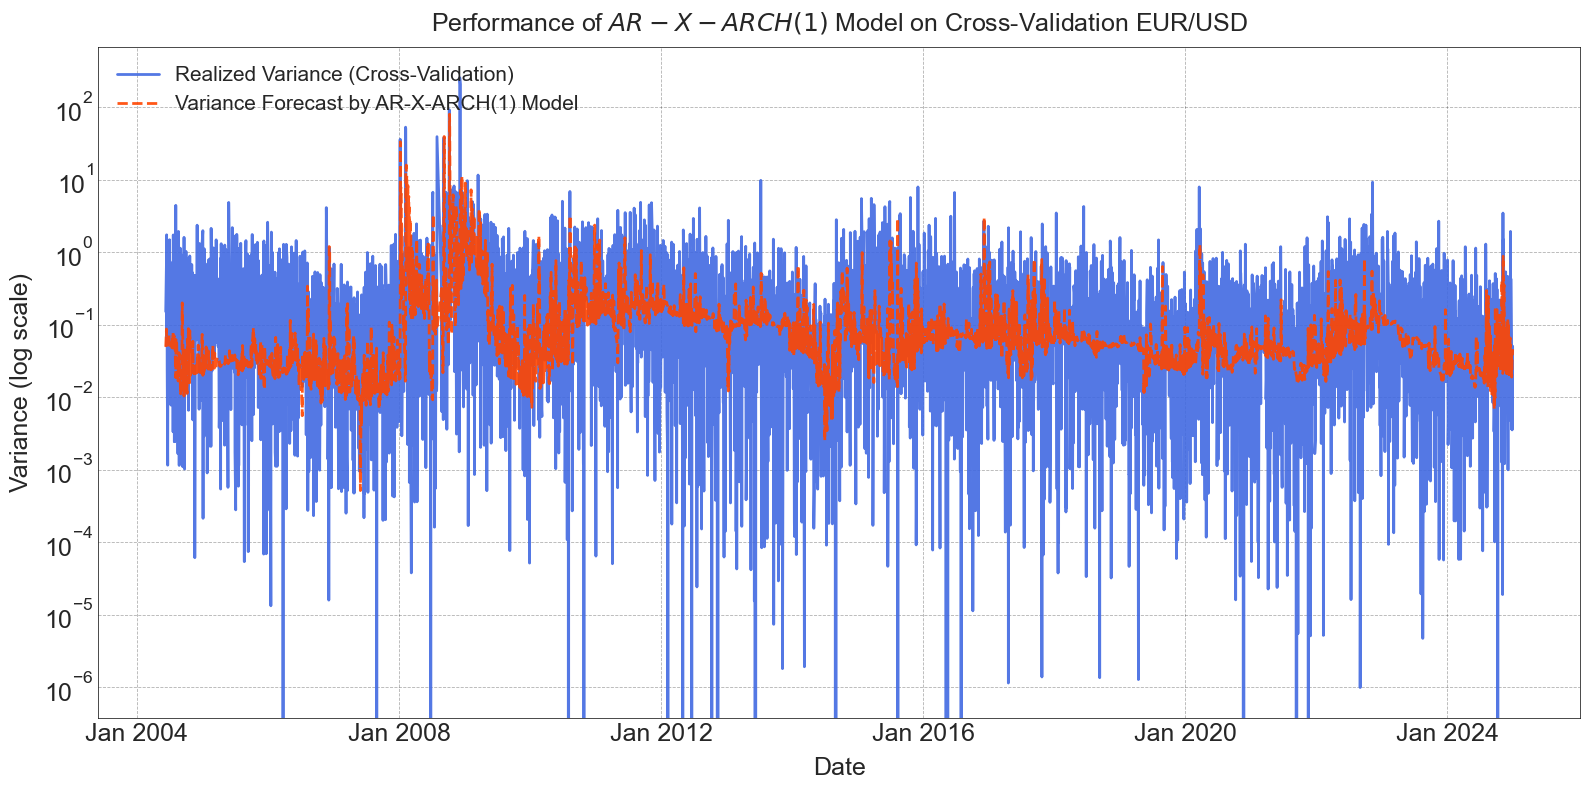

In [96]:
print("\n" + "="*40 + "\nVisualisation des Résultats de la Validation Croisée\n" + "="*40)

if 'num_valid_points_for_eval' not in locals() or num_valid_points_for_eval <= 5:
    print("Pas assez de données de prévision valides pour la visualisation.")
else:
    try:
        import matplotlib.pyplot as plt
        import matplotlib.dates as mdates
        import numpy as np
        import pandas as pd

        plt.figure(figsize=(16, 8))

        dates_for_plot = None
        if 'cv_results_df' in globals() and isinstance(cv_results_df.index, pd.DatetimeIndex):
            if 'cv_df_cleaned_for_metrics' in globals() and isinstance(cv_df_cleaned_for_metrics.index, pd.DatetimeIndex):
                dates_for_plot = cv_df_cleaned_for_metrics.index
                actuals_to_plot = cv_df_cleaned_for_metrics['Variance_Réelle_CV']
                forecasts_to_plot = cv_df_cleaned_for_metrics['Variance_Prédite_CV']
            elif isinstance(cv_results_df.index, pd.DatetimeIndex):
                 if 'actual_indices_cv' in locals():
                     temp_dates_all = pd.to_datetime(actual_indices_cv, errors='ignore')
                     if not pd.api.types.is_datetime64_any_dtype(temp_dates_all):
                          print("Avertissement: Impossible de convertir actual_indices_cv en dates pour le graphique.")
                          dates_for_plot = np.arange(len(valid_actuals_eval))
                     else:
                          dates_for_plot = temp_dates_all[valid_indices_for_eval]
                 else:
                    dates_for_plot = np.arange(len(valid_actuals_eval))
                 actuals_to_plot = valid_actuals_eval
                 forecasts_to_plot = valid_forecasts_eval
        else:
            print("Avertissement: L'index de date n'est pas disponible dans cv_results_df. Utilisation d'index numériques.")
            dates_for_plot = np.arange(len(valid_actuals_eval))
            actuals_to_plot = valid_actuals_eval
            forecasts_to_plot = valid_forecasts_eval

        if not (len(dates_for_plot) == len(actuals_to_plot) == len(forecasts_to_plot)):
            raise ValueError("Les longueurs des séries ne correspondent pas.")

        # Courbes
        plt.plot(dates_for_plot, actuals_to_plot,
                 label='Realized Variance (Cross-Validation)',
                 alpha=0.9, color='royalblue', linewidth=2)

        plt.plot(dates_for_plot, forecasts_to_plot,
                 label='Variance Forecast by AR-X-ARCH(1) Model',
                 alpha=0.9, linestyle='--', color='orangered', linewidth=2)

        # Axe X : format date clair
        if pd.api.types.is_datetime64_any_dtype(dates_for_plot) or isinstance(dates_for_plot, pd.DatetimeIndex):
            plt.xlabel('Date', fontsize=18)
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
            plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=8))
            plt.xticks(rotation=0, ha='center', fontsize=12)
        else:
            plt.xlabel('Time Index (No Dates)', fontsize=18)

        # Axe Y
        plt.ylabel('Variance (log scale)', fontsize=18)
        plt.yscale('log')

        # Légende
        plt.legend(loc='upper left', fontsize=15, frameon=False)

        # Grille légère et espacée uniquement sur les ticks majeurs
        plt.minorticks_off()
        plt.grid(True, which='major', color='black', linestyle='--', linewidth=0.6, alpha=0.3)

        for spine in plt.gca().spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.5)
            spine.set_color('black')

        # Taille de police des ticks des axes X et Y
        plt.xticks(fontsize=18)  # agrandit les dates ou indices
        plt.yticks(fontsize=18)  # agrandit les valeurs de variance

        plt.title(f'Performance of $AR-X-ARCH(1)$ Model on Cross-Validation {chosen_currency}', fontsize=18)


        # Mise en page
        plt.tight_layout()
        plt.show()


    except ValueError as ve_plot:
        print(f"Erreur de valeur (souvent liée à des valeurs non positives sur l'échelle log) : {ve_plot}")
    except Exception as plot_err:
        print(f"Erreur inattendue lors de la création de la visualisation : {plot_err}")

In [97]:
print("\n" + "="*50 + "\nPréparation et Exécution des Prévisions Futures (Automatisé)\n" + "="*50)

if 'predicted_df' not in globals() or not isinstance(predicted_df, pd.DataFrame) or predicted_df.empty:
    raise NameError("Le DataFrame 'predicted_df' (contenant les prédictions du script précédent) est requis mais non défini ou vide.")

num_future_days_to_predict = len(predicted_df)
if num_future_days_to_predict == 0:
    raise ValueError("Le DataFrame 'predicted_df' est vide. Aucune prévision ne peut être effectuée.")

if chosen_currency not in predicted_df.columns:
    raise KeyError(f"La colonne de l'actif principal '{chosen_currency}' n'a pas été trouvée dans 'predicted_df'.")

future_arbitrary_prices_direct_list = predicted_df[chosen_currency].tolist()

def get_raw_name_from_log_return_name(log_return_name):
    if log_return_name.startswith('Log_Returns_'):
        return log_return_name[len('Log_Returns_'):]
    return log_return_name

names_of_raw_exogs_to_extract = []
indices_of_exogs_for_model_input = []
names_of_log_returns_for_model_input = []

if 'significant_exog_indices_for_future' in globals() and significant_exog_indices_for_future is not None and len(significant_exog_indices_for_future) > 0:
    indices_of_exogs_for_model_input = sorted(list(set(significant_exog_indices_for_future)))
    names_of_log_returns_for_model_input = [exog_variable_names[i] for i in indices_of_exogs_for_model_input]
    names_of_raw_exogs_to_extract = [get_raw_name_from_log_return_name(lr_name) for lr_name in names_of_log_returns_for_model_input]
    num_exog_final_for_model = len(indices_of_exogs_for_model_input)
    print(f"\nLe modèle utilisera les {num_exog_final_for_model} variable(s) exogène(s) significative(s) suivante(s) (extraites de 'predicted_df'):")
    for raw_name in names_of_raw_exogs_to_extract:
        print(f"  - {raw_name}")
else:
    warnings.warn("Aucune exogène significative identifiée. Utilisation de TOUTES les exogènes initiales.", UserWarning)
    indices_of_exogs_for_model_input = list(range(num_exog_vars))
    names_of_log_returns_for_model_input = list(exog_variable_names)
    names_of_raw_exogs_to_extract = [get_raw_name_from_log_return_name(lr_name) for lr_name in names_of_log_returns_for_model_input]
    num_exog_final_for_model = num_exog_vars
    if num_exog_final_for_model > 0:
        print(f"\nLe modèle utilisera les {num_exog_final_for_model} variable(s) exogène(s) suivante(s) (extraites de 'predicted_df'):")
        for raw_name in names_of_raw_exogs_to_extract:
            print(f"  - {raw_name}")

future_exog_raw_values_for_selected_list_of_lists = []
if num_exog_final_for_model > 0:
    for raw_exog_name in names_of_raw_exogs_to_extract:
        if raw_exog_name not in predicted_df.columns:
            raise KeyError(f"La colonne exogène requise '{raw_exog_name}' n'a pas été trouvée dans 'predicted_df'.")
        daily_raw_values_for_current_exog = predicted_df[raw_exog_name].tolist()
        future_exog_raw_values_for_selected_list_of_lists.append(daily_raw_values_for_current_exog)

future_exog_log_returns_for_model_list_of_lists = []
if num_exog_final_for_model > 0:
    for i in range(num_exog_final_for_model):
        raw_exog_name_for_hist_lookup = names_of_raw_exogs_to_extract[i]
        future_raw_values_for_this_exog = future_exog_raw_values_for_selected_list_of_lists[i]
        last_historical_raw_value = pmi_data[raw_exog_name_for_hist_lookup].dropna().iloc[-1]
        log_returns_for_this_exog = []
        current_reference_value = last_historical_raw_value
        if pd.isna(current_reference_value) or current_reference_value <= 0:
            warnings.warn(f"Dernière valeur hist. pour '{raw_exog_name_for_hist_lookup}' invalide. Log-returns mis à 0.0.", UserWarning)
            log_returns_for_this_exog = [0.0] * num_future_days_to_predict
        else:
            for future_val_raw in future_raw_values_for_this_exog:
                if pd.isna(future_val_raw) or future_val_raw <= 0:
                    log_return = 0.0
                    warnings.warn(f"Valeur future invalide pour '{raw_exog_name_for_hist_lookup}' ({future_val_raw}). Log-return mis à 0.0.", UserWarning)
                else:
                    log_return = np.log(future_val_raw / current_reference_value) * 100
                log_returns_for_this_exog.append(log_return)
                current_reference_value = future_val_raw
        future_exog_log_returns_for_model_list_of_lists.append(log_returns_for_this_exog)
    future_exog_scenario_values_calc = np.array(future_exog_log_returns_for_model_list_of_lists).T
elif num_exog_final_for_model == 0:
    future_exog_scenario_values_calc = np.empty((num_future_days_to_predict, 0))

if 'params_for_final_model' not in globals() or params_for_final_model is None:
    if 'most_frequent_params_val_str' in locals() and most_frequent_params_val_str:
        try: params_for_final_model = eval(most_frequent_params_val_str)
        except: params_for_final_model = (1,0)
    else: params_for_final_model = (1,0)

if len(Y) < window_size: raise ValueError(f"Pas assez de données Y.")
final_training_Y = Y[-window_size:]

if num_exog_final_for_model > 0:
    final_training_exog_selected = exog_data[-window_size:, indices_of_exogs_for_model_input]
else:
    final_training_exog_selected = None

if hasattr(fit_garch_x, '__wrapped__'):
    final_model_aic, final_model_obj_for_future_preds = fit_garch_x.__wrapped__(final_training_Y, final_training_exog_selected, params_for_final_model)
else:
    final_model_aic, final_model_obj_for_future_preds = fit_garch_x(final_training_Y, final_training_exog_selected, params_for_final_model)
if final_model_obj_for_future_preds is None: raise ValueError("Échec de l'ajustement du modèle final.")
print(final_model_obj_for_future_preds.summary())

last_hist_date_for_future_calc = pmi_data['Date'].iloc[-1]
future_prediction_dates_calc = pd.to_datetime(predicted_df.index)
future_prices_output_df_calc = pd.DataFrame({'Date': future_prediction_dates_calc, 'Prix_Futur_Prédit': future_arbitrary_prices_direct_list})

predicted_variances_for_future_calc = []
if num_exog_final_for_model > 0:
    exog_input_for_future_forecast_calc = {f'x{k}': future_exog_scenario_values_calc[:, k] for k in range(num_exog_final_for_model)}
else:
    exog_input_for_future_forecast_calc = None
try:
    forecast_results_future_calc = final_model_obj_for_future_preds.forecast(horizon=num_future_days_to_predict, x=exog_input_for_future_forecast_calc, reindex=False, method='analytic')
    predicted_variances_for_future_calc = forecast_results_future_calc.variance.values.flatten()
except Exception as e:
    warnings.warn(f"Erreur pendant la prévision future de la variance : {e}", UserWarning)
    predicted_variances_for_future_calc = [np.nan] * num_future_days_to_predict

future_predictions_output_df_calc = pd.DataFrame({'Date': future_prediction_dates_calc, 'Variance_Prédite': predicted_variances_for_future_calc})
future_predictions_output_df_calc['Volatilité_Prédite'] = np.sqrt(future_predictions_output_df_calc['Variance_Prédite'].clip(lower=0))
future_predictions_output_df_calc['Volatilité_Prédite_Ann'] = future_predictions_output_df_calc['Volatilité_Prédite'] * np.sqrt(252)

final_future_plot_df = pd.merge(future_predictions_output_df_calc, future_prices_output_df_calc, on='Date', how='left')
final_future_plot_df = final_future_plot_df.rename(columns={'Prix_Futur_Prédit': 'Prix_Futur_Arbitraire'})
print("\nPrévisions de Volatilité Futures:\n", final_future_plot_df[['Date', 'Variance_Prédite', 'Volatilité_Prédite_Ann', 'Prix_Futur_Arbitraire']].round(6))

if 'final_future_plot_df' in globals() and isinstance(final_future_plot_df, pd.DataFrame) and not final_future_plot_df.empty:
    final_future_plot_df['Vol_Journaliere_Pred_Decimal'] = final_future_plot_df['Volatilité_Prédite'] / 100.0
else:
    print("final_future_plot_df n'est pas défini ou est vide, impossible de préparer pour Monte Carlo.")


Préparation et Exécution des Prévisions Futures (Automatisé)

Le modèle utilisera les 4 variable(s) exogène(s) significative(s) suivante(s) (extraites de 'predicted_df'):
  - DX-/Y.NYB
  - CNY/EUR
  - GBP/USD
  - ^DJ/I
                          AR-X - ARCH Model Results                           
Dep. Variable:                      y   R-squared:                       0.628
Mean Model:                      AR-X   Adj. R-squared:                  0.615
Vol Model:                       ARCH   Log-Likelihood:                15.8133
Distribution:                  Normal   AIC:                          -17.6266
Method:            Maximum Likelihood   BIC:                           2.17161
                                        No. Observations:                  125
Date:                Thu, Oct 02 2025   Df Residuals:                      120
Time:                        05:24:24   Df Model:                            5
                                  Mean Model                         


Visualisation Claire des Prévisions Futures


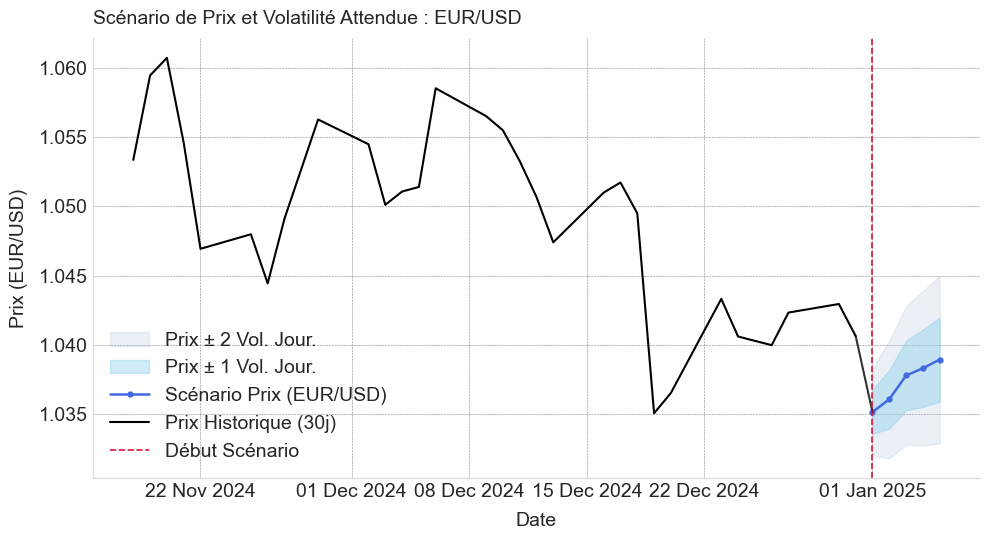

In [98]:
print("\n" + "="*40 + "\nVisualisation Claire des Prévisions Futures\n" + "="*40)

if 'final_future_plot_df' not in globals() or final_future_plot_df.empty:
    print("`final_future_plot_df` est vide ou non défini. Graphique de prévision impossible.")
else:
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({
        'figure.facecolor': 'white',
        'axes.facecolor': 'white',
        'axes.edgecolor': '#DDDDDD',
        'grid.color': '#EAEAEA',
        'grid.linestyle': '-',
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.titlesize': 14,
        'axes.labelsize': 11,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 9,
        'legend.frameon': False,
        'figure.dpi': 100,
        'font.family': 'sans-serif'
    })

    df_plot = final_future_plot_df.copy()
    df_plot['Date'] = pd.to_datetime(df_plot['Date'])

    if 'Volatilité_Prédite' in df_plot.columns:
        df_plot['Vol_Journaliere_Pred_Perc'] = df_plot['Volatilité_Prédite']
    elif 'Volatilité_Prédite_Ann' in df_plot.columns:
        df_plot['Vol_Journaliere_Pred_Perc'] = df_plot['Volatilité_Prédite_Ann'] / np.sqrt(252)
    else:
        df_plot['Vol_Journaliere_Pred_Perc'] = np.nan
        warnings.warn("Colonnes de volatilité manquantes. Bandes de prix non tracées.", UserWarning)

    df_plot['Vol_Journaliere_Pred_Decimal'] = df_plot['Vol_Journaliere_Pred_Perc'] / 100.0

    if 'Prix_Futur_Arbitraire' in df_plot.columns:
        df_plot['Prix_Upper_Band'] = df_plot['Prix_Futur_Arbitraire'] * (1 + df_plot['Vol_Journaliere_Pred_Decimal'])
        df_plot['Prix_Lower_Band'] = df_plot['Prix_Futur_Arbitraire'] * (1 - df_plot['Vol_Journaliere_Pred_Decimal'])
        df_plot['Prix_Upper_Band_Wide'] = df_plot['Prix_Futur_Arbitraire'] * (1 + 2 * df_plot['Vol_Journaliere_Pred_Decimal'])
        df_plot['Prix_Lower_Band_Wide'] = df_plot['Prix_Futur_Arbitraire'] * (1 - 2 * df_plot['Vol_Journaliere_Pred_Decimal'])
    else:
        for col in ['Prix_Upper_Band', 'Prix_Lower_Band', 'Prix_Upper_Band_Wide', 'Prix_Lower_Band_Wide']:
            df_plot[col] = np.nan

    fig1, ax_price = plt.subplots(figsize=(10, 5.5))

    color_prix_futur = 'royalblue'
    color_bande_1 = 'skyblue'
    color_bande_2 = 'lightsteelblue'
    color_hist_price = 'black'
    color_demarcation = 'crimson'
    color_liaison_prix = 'black'

    ax_price.fill_between(df_plot['Date'], df_plot['Prix_Lower_Band_Wide'], df_plot['Prix_Upper_Band_Wide'],
                          color=color_bande_2, alpha=0.25, label='Prix ± 2 Vol. Jour.')
    ax_price.fill_between(df_plot['Date'], df_plot['Prix_Lower_Band'], df_plot['Prix_Upper_Band'],
                          color=color_bande_1, alpha=0.4, label='Prix ± 1 Vol. Jour.')

    ax_price.plot(df_plot['Date'], df_plot['Prix_Futur_Arbitraire'],
                  color=color_prix_futur, linestyle='-', linewidth=1.8, marker='.', markersize=7,
                  label=f'Scénario Prix ({chosen_currency if "chosen_currency" in globals() else "Actif"})')

    if 'pmi_data' in globals() and 'Date' in pmi_data.columns and chosen_currency in pmi_data.columns:
        hist_data = pmi_data[['Date', chosen_currency]].copy()
        hist_data['Date'] = pd.to_datetime(hist_data['Date'])
        hist_data = hist_data.sort_values('Date')
        min_future_dt = df_plot['Date'].min()
        hist_data_to_plot = hist_data[hist_data['Date'] < min_future_dt].tail(30)
        if not hist_data_to_plot.empty:
            ax_price.plot(hist_data_to_plot['Date'], hist_data_to_plot[chosen_currency],
                          color=color_hist_price, linestyle='-', linewidth=1.5, label='Prix Historique (30j)')

            ax_price.plot(
                [hist_data_to_plot['Date'].iloc[-1], df_plot['Date'].iloc[0]],
                [hist_data_to_plot[chosen_currency].iloc[-1], df_plot['Prix_Futur_Arbitraire'].iloc[0]],
                color=color_liaison_prix, linestyle='-', linewidth=1.5, alpha=0.8
            )

    if not df_plot.empty and pd.notna(df_plot['Date'].iloc[0]):
        ax_price.axvline(df_plot['Date'].iloc[0], color=color_demarcation, linestyle='--', linewidth=1.2,
                         label='Début Scénario')

    ax_price.set_title(f'Scénario de Prix et Volatilité Attendue : {chosen_currency if "chosen_currency" in globals() else "Actif"}', loc='left', pad=10, fontsize=14)
    ax_price.set_ylabel(f'Prix ({chosen_currency if "chosen_currency" in globals() else "Actif"})', fontsize=14)
    ax_price.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))
    ax_price.tick_params(axis='x', rotation=0)
    plt.setp(ax_price.get_xticklabels(), ha="center", rotation_mode="anchor")
    ax_price.legend(loc='best', fontsize=14)
    ax_price.tick_params(axis='x', labelsize=14)
    ax_price.tick_params(axis='y', labelsize=14)
    ax_price.set_xlabel('Date', fontsize=14)
    ax_price.grid(color='gray', linewidth=0.4, linestyle='--')
    plt.tight_layout()
    plt.show()

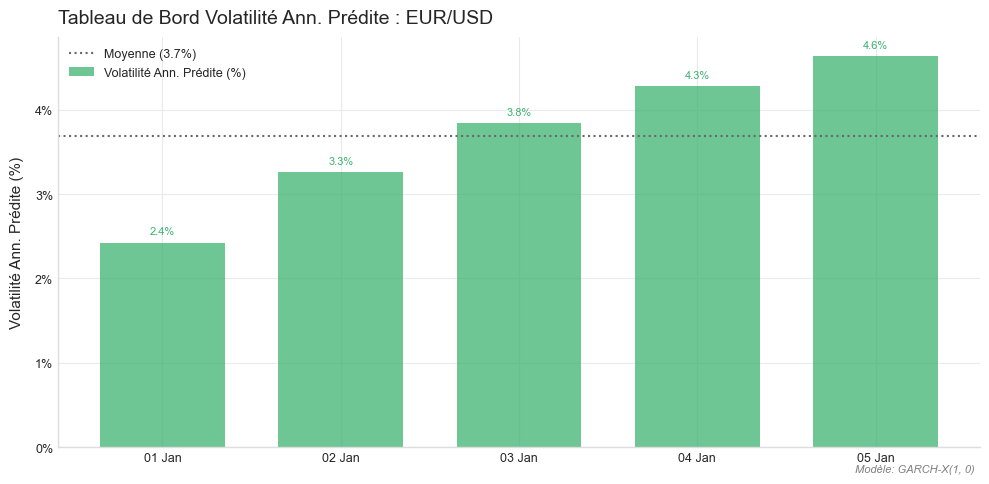

In [99]:
if 'Volatilité_Prédite_Ann' in df_plot.columns:
    fig2, ax_vol_bar = plt.subplots(figsize=(10, 5))
    color_vol_bar_g2 = 'mediumseagreen'
    color_vol_mean_g2 = 'dimgray'

    bars = ax_vol_bar.bar(df_plot['Date'], df_plot['Volatilité_Prédite_Ann'],
                          width=0.7, color=color_vol_bar_g2, alpha=0.75,
                          label='Volatilité Ann. Prédite (%)')

    y_min_g2, y_max_g2 = ax_vol_bar.get_ylim()
    text_offset_g2 = 0.0
    if y_max_g2 > 0:
        text_offset_g2 = (y_max_g2 - y_min_g2) * 0.015
        if y_max_g2 < 2 and text_offset_g2 > 0.1:
            text_offset_g2 = 0.1
        elif text_offset_g2 < 0.05 and y_max_g2 > 0:
            text_offset_g2 = 0.05 * y_max_g2

    if len(df_plot) <= 10:
        for bar_item in bars:
            yval = bar_item.get_height()
            if pd.notna(yval) and yval > 0:
                text_y_position = min(yval + text_offset_g2, y_max_g2 * 0.98) if y_max_g2 > 0 else yval + 0.1
                ax_vol_bar.text(bar_item.get_x() + bar_item.get_width()/2.0,
                                text_y_position, f'{yval:.1f}%',
                                ha='center', va='bottom', fontsize=8, color=color_vol_bar_g2)

    if df_plot['Volatilité_Prédite_Ann'].notna().any():
        vol_pred_mean_g2 = df_plot['Volatilité_Prédite_Ann'].mean()
        ax_vol_bar.axhline(vol_pred_mean_g2, color=color_vol_mean_g2, linestyle=':', linewidth=1.5,
                           label=f'Moyenne ({vol_pred_mean_g2:.1f}%)')

    title_str_vol_g2 = f'Tableau de Bord Volatilité Ann. Prédite : {chosen_currency if "chosen_currency" in globals() else "Actif"}'
    ax_vol_bar.set_title(title_str_vol_g2, loc='left', pad=10)
    ax_vol_bar.set_ylabel('Volatilité Ann. Prédite (%)')
    ax_vol_bar.yaxis.set_major_formatter(mticker.PercentFormatter(decimals=0))
    ax_vol_bar.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    ax_vol_bar.tick_params(axis='x', rotation=0)

    ax_vol_bar.legend(loc='best')
    fig2.subplots_adjust(bottom=0.15)

    if 'params_for_final_model' in globals() and params_for_final_model is not None:
        model_name_txt_g2 = f"Modèle: GARCH-X{params_for_final_model}"
        fig2.text(0.98, 0.04, model_name_txt_g2, ha='right', va='bottom',
                  style='italic', color='grey', fontsize=8)

    plt.tight_layout(rect=[0, 0.03, 1, 1])
    plt.show()
else:
    print("Colonne 'Volatilité_Prédite_Ann' non trouvée pour Graphique 2.")


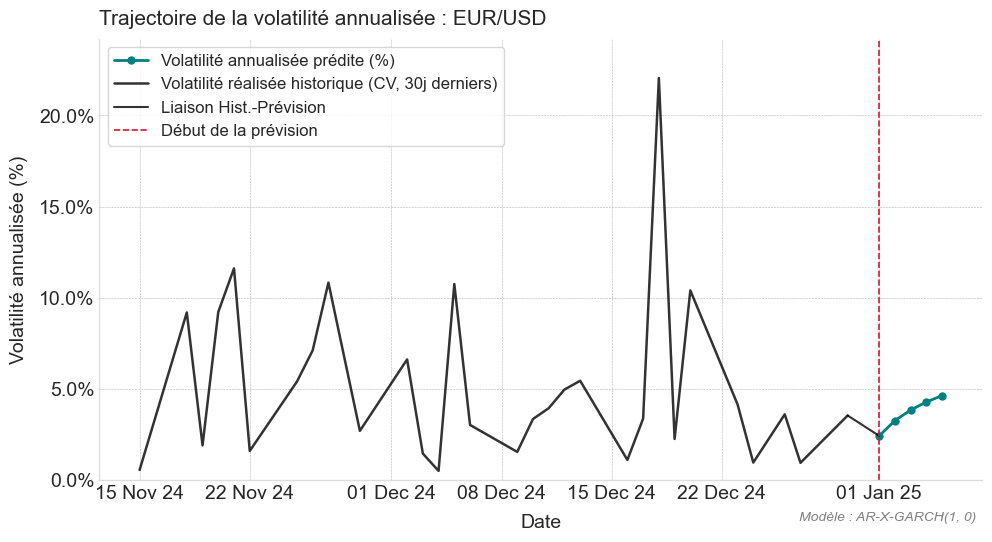

In [100]:
# --- Graphique 3 : Trajectoire de la Volatilité Prédite (Ligne avec Historique) ---
if 'Volatilité_Prédite_Ann' in df_plot.columns:
    fig3, ax_vol_line = plt.subplots(figsize=(10, 5.5))

    color_vol_pred_line = 'teal'
    color_hist_vol_line = 'black'
    color_liaison_line = 'black'
    color_demarcation_line = 'crimson'

    ax_vol_line.plot(df_plot['Date'], df_plot['Volatilité_Prédite_Ann'],
                     color=color_vol_pred_line, linestyle='-', linewidth=2, marker='o', markersize=5,
                     label='Volatilité annualisée prédite (%)')

    last_hist_date_point = None
    last_hist_vol_value = None
    first_future_date_point = None
    first_future_vol_value = None

    if not df_plot.empty and df_plot['Volatilité_Prédite_Ann'].notna().any():
        first_future_date_point = df_plot['Date'].iloc[0]
        first_future_vol_value = df_plot['Volatilité_Prédite_Ann'].iloc[0]

    num_hist_days_vol_line = 30
    if 'cv_results_df' in globals() and isinstance(cv_results_df, pd.DataFrame) and \
       'Variance_Réelle_CV' in cv_results_df.columns and isinstance(cv_results_df.index, pd.DatetimeIndex):
        try:
            if 'Vol_Réelle_CV_Ann_Calc' not in cv_results_df.columns:
                cv_results_df['Vol_Réelle_CV_Ann_Calc'] = np.sqrt(np.maximum(cv_results_df['Variance_Réelle_CV'], 0)) * np.sqrt(252)

            hist_vol_data = cv_results_df['Vol_Réelle_CV_Ann_Calc'].dropna().sort_index()

            if not hist_vol_data.empty and first_future_date_point is not None:
                hist_vol_relevant = hist_vol_data[hist_vol_data.index < first_future_date_point].tail(num_hist_days_vol_line)
                if not hist_vol_relevant.empty:
                    ax_vol_line.plot(hist_vol_relevant.index, hist_vol_relevant.values,
                                     color=color_hist_vol_line, linestyle='-', linewidth=1.8, alpha=0.8,
                                     label=f'Volatilité réalisée historique (CV, {num_hist_days_vol_line}j derniers)')
                    last_hist_date_point = hist_vol_relevant.index[-1]
                    last_hist_vol_value = hist_vol_relevant.values[-1]
        except Exception as e_hist_vol:
            warnings.warn(f"Avertissement lors du tracé de la volatilité historique : {e_hist_vol}")

    if last_hist_date_point and pd.notna(last_hist_vol_value) and \
       first_future_date_point and pd.notna(first_future_vol_value):
        ax_vol_line.plot([last_hist_date_point, first_future_date_point],
                         [last_hist_vol_value, first_future_vol_value],
                         color=color_liaison_line, linestyle='-', linewidth=1.5, alpha=0.8,
                         label='Liaison Hist.-Prévision')

    if first_future_date_point is not None and pd.notna(first_future_date_point):
        ax_vol_line.axvline(first_future_date_point, color=color_demarcation_line, linestyle='--', linewidth=1.2,
                            label='Début de la prévision')

    title_str_vol3 = f"Trajectoire de la volatilité annualisée : {chosen_currency if 'chosen_currency' in globals() else 'Actif'}"
    ax_vol_line.set_title(title_str_vol3, loc='left', pad=10, fontsize=15)
    ax_vol_line.set_ylabel('Volatilité annualisée (%)', fontsize=14)
    ax_vol_line.set_xlabel('Date', fontsize=14)
    ax_vol_line.yaxis.set_major_formatter(mticker.PercentFormatter(decimals=1))
    ax_vol_line.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %y'))
    ax_vol_line.tick_params(axis='both', which='major', labelsize=14)
    plt.setp(ax_vol_line.get_xticklabels(), ha="center", rotation_mode="anchor")

    ax_vol_line.legend(loc='best', fontsize=12, frameon=True)

    if df_plot['Volatilité_Prédite_Ann'].notna().any() or ('hist_vol_relevant' in locals() and hist_vol_relevant.notna().any()):
        all_y_values = []
        if 'hist_vol_relevant' in locals() and not hist_vol_relevant.empty:
            all_y_values.extend(hist_vol_relevant.values)
        if not df_plot.empty:
            all_y_values.extend(df_plot['Volatilité_Prédite_Ann'].dropna().values)

        if all_y_values:
            min_y = np.nanmin(all_y_values)
            max_y = np.nanmax(all_y_values)
            padding = (max_y - min_y) * 0.1
            if padding == 0: padding = 1
            ax_vol_line.set_ylim(bottom=max(0, min_y - padding), top=max_y + padding)

    if 'params_for_final_model' in globals() and params_for_final_model is not None:
        model_name_txt = f"Modèle : AR-X-GARCH{params_for_final_model}"
        fig3.text(0.98, 0.04, model_name_txt, ha='right', va='bottom', style='italic', color='grey', fontsize=10)

    ax_vol_line.grid(True, which='major', color='gray', linestyle='--', linewidth=0.4, alpha=0.6)

    plt.tight_layout(pad=1.0)
    plt.show()

else:
    print("Colonne 'Volatilité_Prédite_Ann' non trouvée dans df_plot. Le graphique de trajectoire de volatilité ne sera pas généré.")



Quantification du Scénario de Prix par Monte Carlo VaR (avec Drift de votre scénario)


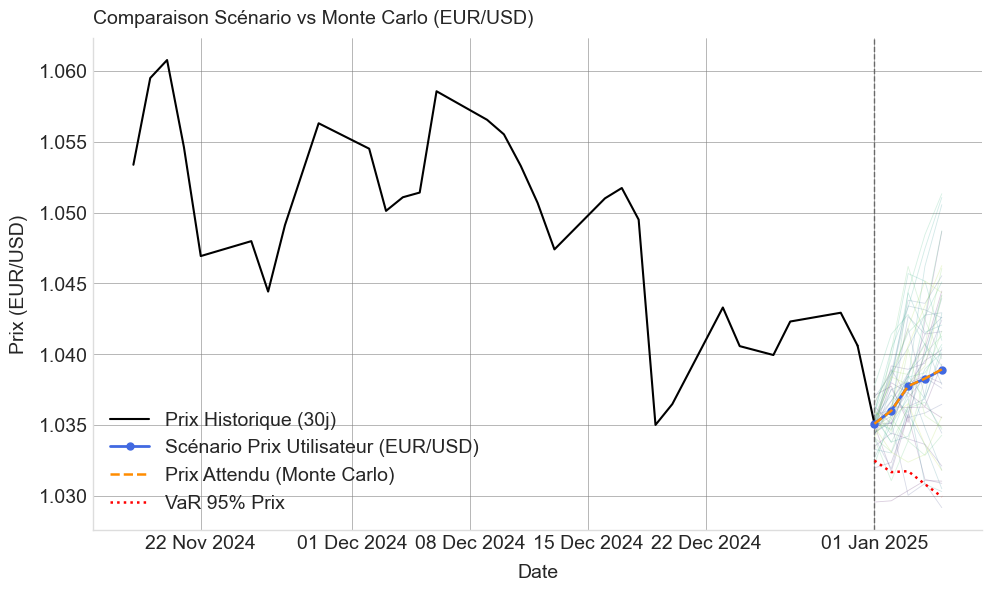

In [101]:
print("\n" + "="*40 + "\nQuantification du Scénario de Prix par Monte Carlo VaR (avec Drift de votre scénario)\n" + "="*40)

if 'final_future_plot_df' not in globals() or not isinstance(final_future_plot_df, pd.DataFrame) or final_future_plot_df.empty:
    print("`final_future_plot_df` est vide ou non défini. Simulation de Monte Carlo impossible.")
elif 'Prix_Futur_Arbitraire' not in final_future_plot_df.columns or \
     'Vol_Journaliere_Pred_Decimal' not in final_future_plot_df.columns:
    if 'Vol_Journaliere_Pred_Decimal' not in final_future_plot_df.columns:
        if 'Volatilité_Prédite' in final_future_plot_df.columns:
            final_future_plot_df['Vol_Journaliere_Pred_Decimal'] = final_future_plot_df['Volatilité_Prédite'] / 100.0
        elif 'Volatilité_Prédite_Ann' in final_future_plot_df.columns:
            final_future_plot_df['Vol_Journaliere_Pred_Decimal'] = (final_future_plot_df['Volatilité_Prédite_Ann'] / np.sqrt(252)) / 100.0
        else:
             print("Colonnes de volatilité nécessaires manquantes. Simulation impossible.")

    if 'Prix_Futur_Arbitraire' not in final_future_plot_df.columns:
         print("Colonne 'Prix_Futur_Arbitraire' manquante. Simulation impossible.")

else:
    num_simulations = 10000
    var_confidence_level = 0.95
    df_mc = final_future_plot_df.copy()
    df_mc['Date'] = pd.to_datetime(df_mc['Date'])
    num_future_days = len(df_mc)

    start_price = np.nan
    if 'pmi_data' in globals() and isinstance(pmi_data, pd.DataFrame) and \
       'Date' in pmi_data.columns and 'chosen_currency' in globals() and chosen_currency in pmi_data.columns and \
       not pmi_data.empty and 'last_hist_date_for_future' in globals() and pd.notna(last_hist_date_for_future):
        pmi_data_sorted = pmi_data.sort_values(by='Date'); last_hist_dt_ts = pd.to_datetime(last_hist_date_for_future)
        last_known_price_series = pmi_data_sorted[pmi_data_sorted['Date'] <= last_hist_dt_ts][chosen_currency].dropna()
        if not last_known_price_series.empty: start_price = last_known_price_series.iloc[-1]

    if pd.isna(start_price):
        if not df_mc['Prix_Futur_Arbitraire'].empty and pd.notna(df_mc['Prix_Futur_Arbitraire'].iloc[0]):
            start_price = df_mc['Prix_Futur_Arbitraire'].iloc[0]
            warnings.warn(f"Données historiques non disponibles. Utilisation du premier prix du scénario ({start_price:.4f}) comme point de départ.")
        else:
            raise ValueError("Impossible de déterminer le prix de départ pour la simulation de Monte Carlo.")

    prix_futurs_du_scenario = df_mc['Prix_Futur_Arbitraire'].tolist()

    reference_price_series_for_drift = pd.Series([start_price] + prix_futurs_du_scenario)

    daily_drift_series = np.log(reference_price_series_for_drift / reference_price_series_for_drift.shift(1))

    df_mc['Daily_Drift'] = daily_drift_series.iloc[1:].values

    all_simulated_prices = np.zeros((num_future_days, num_simulations))

    for i in range(num_simulations):
        current_simulated_price = start_price
        for t in range(num_future_days):
            vol_pred_day_t_decimal = df_mc['Vol_Journaliere_Pred_Decimal'].iloc[t]
            daily_drift = df_mc['Daily_Drift'].iloc[t]

            if pd.isna(vol_pred_day_t_decimal) or vol_pred_day_t_decimal <= 0:
                simulated_log_return = daily_drift if pd.notna(daily_drift) else 0.0 
                if i == 0: warnings.warn(f"Volatilité invalide jour {t+1}. Seul le drift est appliqué.", UserWarning)
            else:
                simulated_log_return = np.random.normal(loc=daily_drift, scale=vol_pred_day_t_decimal)

            current_simulated_price = current_simulated_price * np.exp(simulated_log_return)
            all_simulated_prices[t, i] = current_simulated_price

    var_results, expected_prices_mc, median_prices_mc, percentile_5_mc, percentile_95_mc = [], [], [], [], []
    for t in range(num_future_days):
        prices_at_day_t = all_simulated_prices[t, :]
        var_results.append(np.percentile(prices_at_day_t, (1 - var_confidence_level) * 100))
        expected_prices_mc.append(np.mean(prices_at_day_t))
        median_prices_mc.append(np.median(prices_at_day_t))
        percentile_5_mc.append(np.percentile(prices_at_day_t, 5))
        percentile_95_mc.append(np.percentile(prices_at_day_t, 95))

    df_mc['VaR_Price'] = var_results; df_mc['Expected_Price_MC'] = expected_prices_mc
    df_mc['Median_Price_MC'] = median_prices_mc; df_mc['P05_Price_MC'] = percentile_5_mc
    df_mc['P95_Price_MC'] = percentile_95_mc

    num_paths_to_plot_shared = min(50, num_simulations)
    indices_paths_shared = np.random.choice(range(num_simulations), size=num_paths_to_plot_shared, replace=False)
    try:
        cmap_shared_object = plt.colormaps.get_cmap('viridis')
    except AttributeError:
        cmap_shared_object = plt.cm.get_cmap('viridis')
    num_colors_from_cmap = cmap_shared_object.N if hasattr(cmap_shared_object, 'N') else 256
    colors_for_shared_paths = [cmap_shared_object(i) for i in np.linspace(0, 0.9, min(num_colors_from_cmap, num_paths_to_plot_shared))]

    color_scenario_user = 'royalblue'
    label_scenario_user = f'Scénario Prix Utilisateur ({chosen_currency if "chosen_currency" in globals() else "Actif"})'
    linewidth_scenario_user = 2
    marker_scenario_user = 'o'
    markersize_scenario_user = 5

    color_expected_mc = 'darkorange' 
    color_median_mc = 'darkblue'
    color_var_line = 'red' 
    color_expected_mc_dist = 'black' 

    fig_mc, ax_mc = plt.subplots(figsize=(10, 6))
    color_hist_price_mc = 'black'

    for i_idx, sim_idx in enumerate(indices_paths_shared):
        color_index = i_idx % len(colors_for_shared_paths)
        ax_mc.plot(df_mc['Date'], all_simulated_prices[:, sim_idx],
                color=colors_for_shared_paths[color_index], alpha=0.2, linewidth=0.6)

    if 'pmi_data' in globals() and isinstance(pmi_data, pd.DataFrame) and \
    'Date' in pmi_data.columns and 'chosen_currency' in globals() and chosen_currency in pmi_data.columns and \
    not pmi_data.empty:

        pmi_data_sorted = pmi_data.sort_values(by='Date')
        hist_data_to_plot_mc = pmi_data_sorted[pmi_data_sorted['Date'] <= df_mc['Date'].iloc[0]].tail(30)

        if not hist_data_to_plot_mc.empty:
            ax_mc.plot(hist_data_to_plot_mc['Date'], hist_data_to_plot_mc[chosen_currency],
                    color=color_hist_price_mc, linestyle='-', linewidth=1.5, zorder=4, label='Prix Historique (30j)')

            raccord_date = df_mc['Date'].iloc[0]
            raccord_price = hist_data_to_plot_mc[chosen_currency].iloc[-1]
            premier_price_scenario = df_mc['Prix_Futur_Arbitraire'].iloc[0]

            ax_mc.plot([raccord_date - pd.Timedelta(days=1), raccord_date],
                    [raccord_price, premier_price_scenario],
                    color=color_hist_price_mc, linestyle='-', linewidth=1.5, zorder=4)

    ax_mc.plot(df_mc['Date'], df_mc['Prix_Futur_Arbitraire'],
            color=color_scenario_user, linestyle='-', linewidth=linewidth_scenario_user,
            marker=marker_scenario_user, markersize=markersize_scenario_user, zorder=5,
            label=label_scenario_user)

    ax_mc.plot(df_mc['Date'], df_mc['Expected_Price_MC'],
            color=color_expected_mc, linestyle='--', linewidth=1.8, zorder=5,
            label='Prix Attendu (Monte Carlo)')
    ax_mc.plot(df_mc['Date'], df_mc['VaR_Price'],
            color=color_var_line, linestyle=':', linewidth=1.8, zorder=5,
            label=f'VaR {var_confidence_level*100:.0f}% Prix')

    first_forecast_date = df_mc['Date'].iloc[0]
    ax_mc.axvline(first_forecast_date, color='dimgrey', linestyle='--', linewidth=1)

    title_str_mc = f'Comparaison Scénario vs Monte Carlo ({chosen_currency if "chosen_currency" in globals() else "Actif"})'
    ax_mc.set_title(title_str_mc, loc='left', pad=10, fontsize=14)
    ax_mc.set_ylabel(f'Prix ({chosen_currency if "chosen_currency" in globals() else "Actif"})', fontsize=14)
    ax_mc.set_xlabel('Date', fontsize=14)
    ax_mc.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))
    ax_mc.tick_params(axis='x', rotation=0)
    ax_mc.tick_params(axis='x', labelsize=14)  
    ax_mc.tick_params(axis='y', labelsize=14)  
    plt.setp(ax_mc.get_xticklabels(), ha="center", rotation_mode="anchor")
    ax_mc.legend(loc='best', fontsize=14)
    ax_mc.grid(color='gray', linewidth=0.4, linestyle='-')
    plt.tight_layout(pad=1.0)
    plt.show()


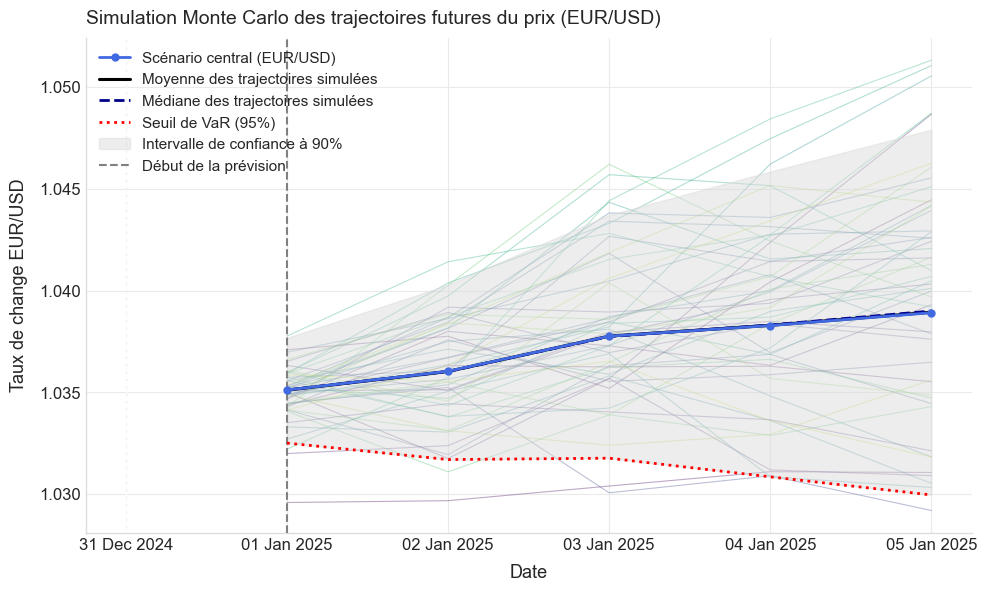

In [102]:
last_hist_date_for_future = pmi_data['Date'].iloc[-1]

label_scenario_user = f'Scénario central ({chosen_currency if "chosen_currency" in globals() else "Actif"})'

fig_mc_dist, ax_mc_dist = plt.subplots(figsize=(10, 6))

for i_idx, sim_idx in enumerate(indices_paths_shared):
    color_index = i_idx % len(colors_for_shared_paths)
    ax_mc_dist.plot(df_mc['Date'], all_simulated_prices[:, sim_idx],
                    color=colors_for_shared_paths[color_index],
                    alpha=0.35, linewidth=0.8)

ax_mc_dist.plot(df_mc['Date'], df_mc['Prix_Futur_Arbitraire'],
                color=color_scenario_user, linestyle='-', linewidth=linewidth_scenario_user,
                marker=marker_scenario_user, markersize=markersize_scenario_user, zorder=6,
                label=label_scenario_user)

ax_mc_dist.plot(df_mc['Date'], df_mc['Expected_Price_MC'],
                color=color_expected_mc_dist, linestyle='-', linewidth=2.2, zorder=5,
                label='Moyenne des trajectoires simulées')
ax_mc_dist.plot(df_mc['Date'], df_mc['Median_Price_MC'],
                color=color_median_mc, linestyle='--', linewidth=2, zorder=5,
                label='Médiane des trajectoires simulées')
ax_mc_dist.plot(df_mc['Date'], df_mc['VaR_Price'],
                color=color_var_line, linestyle=':', linewidth=2, zorder=5,
                label=f'Seuil de VaR ({var_confidence_level*100:.0f}%)')

ax_mc_dist.fill_between(df_mc['Date'], df_mc['P05_Price_MC'], df_mc['P95_Price_MC'],
                        color='gainsboro', alpha=0.5, zorder=2,
                        label='Intervalle de confiance à 90%')

if 'last_hist_date_for_future' in globals() and pd.notna(last_hist_date_for_future):
    ax_mc_dist.axvline(pd.to_datetime(last_hist_date_for_future), color='white', linestyle='--',
                       linewidth=1.0, zorder=1, label='_nolegend_')

if 'df_mc' in globals() and 'Prix_Futur_Arbitraire' in df_mc.columns:
    idx_valid = df_mc['Prix_Futur_Arbitraire'].first_valid_index()
    if idx_valid is not None:
        first_scenario_date = df_mc.loc[idx_valid, 'Date']
        ax_mc_dist.axvline(pd.to_datetime(first_scenario_date), color='gray', linestyle='--',
                           linewidth=1.5, zorder=4, label='Début de la prévision')

title_str_mc_dist = f'Simulation Monte Carlo des trajectoires futures du prix ({chosen_currency if "chosen_currency" in globals() else "Actif"})'
ax_mc_dist.set_title(title_str_mc_dist, loc='left', pad=10, fontsize=14)
ax_mc_dist.set_ylabel(f'Taux de change {chosen_currency if "chosen_currency" in globals() else "Actif"}', fontsize=13)
ax_mc_dist.set_xlabel('Date', fontsize=13)

ax_mc_dist.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))
ax_mc_dist.tick_params(axis='x', rotation=0, labelsize=12)
ax_mc_dist.tick_params(axis='y', labelsize=12)

ax_mc_dist.legend(loc='best', fontsize=11)
plt.tight_layout(pad=1.0)
plt.show()


In [103]:

print("\n" + "="*40 + "\nPricing d'Option Européenne sur Devises avec Grecques (Strike ATMF)\n" + "="*40)

FRED_RATE_SERIES_MAP = {
    "USD": ([("SOFR", "SOFR"), ("DTB3", "US T-Bill 3-mo"), ("FEDFUNDS", "Fed Funds Rate")], "USD Taux CT"),
    "EUR": ([("ECBESTRVOL", "€STR"), ("IRSTCI01EZM156N", "EZ Call Rate")], "EUR Taux CT"),
    "GBP": ([("IUDSOIA", "SONIA"), ("IRSTCI01GBM156N", "GBP Call Rate")], "GBP Taux CT"),
    "JPY": ([("IRSTCI01JPM156N", "JPY Call Rate"), ("TONAR", "TONAR")], "JPY Taux CT"),
    "CAD": ([("CORRA", "CORRA"),("IRSTCI01CAM156N", "CAD Call Rate")], "CAD Taux CT"),
    "CHF": ([("SARON", "SARON"), ("IRSTCI01CHM156N", "CHF Call Rate")], "CHF Taux CT"),
    "AUD": ([("RBATCTR", "AUD Cash Rate Target"), ("IRSTCI01AUM156N", "AUD Interbank Rate")], "AUD Taux CT"),
    "NZD": ([("IRSTCI01NZM156N", "NZD Call Rate"), ("RBOKOCR", "NZD OCR")], "NZD Taux CT"),
    "CNY": ([("IRSTCI01CNM156N", "CNY Call Rate (Onshore)")], "CNY Taux CT"),
    "HKD": ([("IRSTCI01HKM156N", "HKD Call Rate")], "HKD Taux CT"),
    "SGD": ([("IRSTCI01SGM156N", "SGD Call Rate")], "SGD Taux CT"),
    "KRW": ([("IRSTCI01KRM156N", "KRW Call Rate")], "KRW Taux CT"),
    "INR": ([("IRSTCI01INM156N", "INR Call Rate")], "INR Taux CT"),
    "BRL": ([("IRSTCI01BRM156N", "BRL Interbank Rate")], "BRL Taux CT"),
    "RUB": ([("IRSTCI01RUM156N", "RUB Interbank Rate")], "RUB Taux CT"),
    "ZAR": ([("IRSTCI01ZAM156N", "ZAR Call Rate")], "ZAR Taux CT"),
    "TRY": ([("IRSTCI01TRM156N", "TRY Interbank Rate")], "TRY Taux CT"),
    "MXN": ([("IRSTCI01MXM156N", "MXN Interbank Rate")], "MXN Taux CT"),
    "PLN": ([("IRSTCI01PLM156N", "PLN Call Rate")], "PLN Taux CT"),
    "HUF": ([("IRSTCI01HUM156N", "HUF Call Rate")], "HUF Taux CT"),
    "CZK": ([("IRSTCI01CZM156N", "CZK Call Rate")], "CZK Taux CT"),
}
DEFAULT_RATE_VALUE = 0.03

use_fred_api = False
fred = None
if 'api_key' in globals() and api_key:
    try:
        fred = Fred(api_key=api_key); print("API FRED initialisée."); use_fred_api = True
    except Exception as e:
        warnings.warn(f"Erreur init API FRED: {e}. Taux par défaut utilisés."); use_fred_api = False
else:
    warnings.warn("Clé API FRED non trouvée. Taux par défaut utilisés.")

if 'final_future_plot_df' not in globals() or not isinstance(final_future_plot_df, pd.DataFrame) or final_future_plot_df.empty:
    print("`final_future_plot_df` non défini/vide. Pricing impossible."); sys.exit()
if not all(col in final_future_plot_df.columns for col in ['Prix_Futur_Arbitraire', 'Volatilité_Prédite_Ann']):
    print("Colonnes requises manquantes dans final_future_plot_df. Pricing impossible."); sys.exit()
if 'chosen_currency' not in globals() or not isinstance(chosen_currency, str) or '/' not in chosen_currency:
    print("`chosen_currency` non définie ou format incorrect. Pricing impossible."); sys.exit()

df_pricing = final_future_plot_df.copy()
df_pricing['Date'] = pd.to_datetime(df_pricing['Date'])

try:
    base_ccy, quote_ccy = chosen_currency.split('/')
    print(f"Pricing d'option pour la paire: {base_ccy}/{quote_ccy} (Base: {base_ccy}, Cotation: {quote_ccy})")
except ValueError:
    print(f"Format de 'chosen_currency' ({chosen_currency}) non reconnu. Pricing impossible."); sys.exit()

notional_amount = None; r_domestic = None; r_foreign = None
pricing_date = None; option_type_input = None; strike_price = None
can_proceed_with_pricing = False

try:
    notional_amount_str = input(f"Entrez le montant notionnel en {base_ccy} (ex: 100000) : ")
    notional_amount = float(notional_amount_str.replace(',', '.'))

    if 'last_hist_date_for_future' in globals() and pd.notna(last_hist_date_for_future):
        pricing_date = pd.to_datetime(last_hist_date_for_future)
    else:
        pricing_date = pd.Timestamp.now().normalize() - pd.Timedelta(days=1)
        warnings.warn(f"last_hist_date_for_future non définie. Pricing à hier: {pricing_date.strftime('%Y-%m-%d')}")
    print(f"Date de Pricing (T0) : {pricing_date.strftime('%Y-%m-%d')}")

    while True:
        option_type_str = input(f"Quel type d'option sur {base_ccy} (Call ou Put) : ").strip().lower()
        if option_type_str in ['call', 'c']: option_type_input = 'call'; break
        elif option_type_str in ['put', 'p']: option_type_input = 'put'; break
        else: print("Invalide. 'Call' ou 'Put'.")

    print("\nRécupération des taux d'intérêt...")
    def get_fred_rate_dynamic(currency_code_to_fetch, p_date, fred_instance, is_fred_api_usable_flag):
        rate_value = DEFAULT_RATE_VALUE; series_name_display = "Taux par défaut"; rate_date_display = "N/A"
        if not is_fred_api_usable_flag: warnings.warn(f"API FRED non dispo. Taux défaut pour {currency_code_to_fetch}."); return rate_value
        if currency_code_to_fetch in FRED_RATE_SERIES_MAP:
            series_to_try_list, _ = FRED_RATE_SERIES_MAP[currency_code_to_fetch]
            for series_id, s_name_short in series_to_try_list:
                try:
                    rate_data = fred_instance.get_series(series_id, observation_start=p_date - pd.Timedelta(days=30), observation_end=p_date)
                    if not rate_data.dropna().empty:
                        rate_value = rate_data.dropna().iloc[-1] / 100.0; series_name_display = s_name_short
                        rate_date_display = rate_data.dropna().index[-1].strftime('%Y-%m-%d'); break
                except Exception as e: warnings.warn(f"FRED API Erreur {series_id} ({currency_code_to_fetch}): {e}")
            print(f"  Taux pour {currency_code_to_fetch} ({series_name_display}): {rate_value*100:.3f}% ({rate_date_display})")
        else: warnings.warn(f"Devise {currency_code_to_fetch} non mappée. Taux défaut.")
        return rate_value

    r_domestic = get_fred_rate_dynamic(quote_ccy, pricing_date, fred, use_fred_api)
    r_foreign = get_fred_rate_dynamic(base_ccy, pricing_date, fred, use_fred_api)

    if pd.isna(r_domestic) or pd.isna(r_foreign): raise ValueError("Taux d'intérêt manquants.")
    can_proceed_with_pricing = True

except ValueError as e_val: print(f"Erreur paramètres/taux: {e_val}. Pricing annulé.")
except Exception as e_gen: print(f"Erreur préparation pricing: {e_gen}. Pricing annulé."); traceback.print_exc()

if can_proceed_with_pricing:
    maturity_date = df_pricing['Date'].max()
    time_to_maturity_days = (maturity_date - pricing_date).days
    if time_to_maturity_days <= 0:
        warnings.warn(f"Maturité non postérieure à pricing date. T=1 jour.", UserWarning)
        time_to_maturity_years = 1/365.0
    else:
        time_to_maturity_years = time_to_maturity_days / 365.0
    print(f"Échéance option: {maturity_date.strftime('%Y-%m-%d')} (T={time_to_maturity_years:.4f} années)")

    current_spot_price = np.nan
    if 'pmi_data' in globals() and isinstance(pmi_data, pd.DataFrame) and 'Date' in pmi_data.columns and 'chosen_currency' in globals() and chosen_currency in pmi_data.columns and not pmi_data.empty:
        pmi_data_sorted = pmi_data.sort_values(by='Date'); spot_price_series = pmi_data_sorted[pmi_data_sorted['Date'] <= pricing_date][chosen_currency].dropna()
        if not spot_price_series.empty: current_spot_price = spot_price_series.iloc[-1]
    if pd.isna(current_spot_price):
        if not df_pricing['Prix_Futur_Arbitraire'].empty: current_spot_price = df_pricing['Prix_Futur_Arbitraire'].iloc[0]; warnings.warn(f"Spot non trouvé. Utilisation 1er prix scénario: {current_spot_price:.4f}")
        else: raise ValueError("Impossible de déterminer S0.")
    print(f"Prix Spot (S0) ({chosen_currency}): {current_spot_price:.4f}")

    avg_predicted_vol_ann_perc = df_pricing['Volatilité_Prédite_Ann'].mean()
    if pd.isna(avg_predicted_vol_ann_perc) or avg_predicted_vol_ann_perc <=0:
        warnings.warn(f"Vol GARCH invalide ({avg_predicted_vol_ann_perc}). Vol=10%.")
        sigma = 0.10
    else:
        sigma = avg_predicted_vol_ann_perc / 100.0
    print(f"Volatilité (σ) (moyenne GARCH): {sigma*100:.2f}%")

    strike_price = current_spot_price * np.exp((r_domestic - r_foreign) * time_to_maturity_years)
    print(f"Prix d'Exercice (K) (ATMF): {strike_price:.4f} {quote_ccy}/{base_ccy}")

    option_premium_per_unit = np.nan
    delta_val, gamma_val, vega_val, theta_val_day = np.nan, np.nan, np.nan, np.nan
    rho_domestic_val, rho_foreign_val = np.nan, np.nan


    if sigma <= 0 or time_to_maturity_years <=0 :
        print("Volatilité ou temps à maturité invalide pour Black-Scholes.")
    else:
        d1_num = np.log(current_spot_price / strike_price) + (r_domestic - r_foreign + 0.5 * sigma**2) * time_to_maturity_years
        d1_den = sigma * np.sqrt(time_to_maturity_years)
        if d1_den == 0: d1 = np.inf if d1_num > 0 else (-np.inf if d1_num < 0 else 0)
        else: d1 = d1_num / d1_den
        d2 = d1 - sigma * np.sqrt(time_to_maturity_years)
        nd1 = norm.pdf(d1) 

        if option_type_input == 'call':
            option_premium_per_unit = current_spot_price * np.exp(-r_foreign * time_to_maturity_years) * norm.cdf(d1) - \
                                      strike_price * np.exp(-r_domestic * time_to_maturity_years) * norm.cdf(d2)
            delta_val = np.exp(-r_foreign * time_to_maturity_years) * norm.cdf(d1)
            theta_val_yearly = - (current_spot_price * nd1 * sigma * np.exp(-r_foreign * time_to_maturity_years)) / (2 * np.sqrt(time_to_maturity_years)) \
                                - r_domestic * strike_price * np.exp(-r_domestic * time_to_maturity_years) * norm.cdf(d2) \
                                + r_foreign * current_spot_price * np.exp(-r_foreign * time_to_maturity_years) * norm.cdf(d1)
            rho_domestic_val = strike_price * time_to_maturity_years * np.exp(-r_domestic * time_to_maturity_years) * norm.cdf(d2) / 100.0
            rho_foreign_val = -current_spot_price * time_to_maturity_years * np.exp(-r_foreign * time_to_maturity_years) * norm.cdf(d1) / 100.0
            print(f"\n--- Prix d'une Option d'Achat (Call) Européenne ATMF sur {base_ccy} ---")
        elif option_type_input == 'put':
            option_premium_per_unit = strike_price * np.exp(-r_domestic * time_to_maturity_years) * norm.cdf(-d2) - \
                                      current_spot_price * np.exp(-r_foreign * time_to_maturity_years) * norm.cdf(-d1)
            delta_val = np.exp(-r_foreign * time_to_maturity_years) * (norm.cdf(d1) - 1)
            theta_val_yearly =  - (current_spot_price * nd1 * sigma * np.exp(-r_foreign * time_to_maturity_years)) / (2 * np.sqrt(time_to_maturity_years)) \
                                + r_domestic * strike_price * np.exp(-r_domestic * time_to_maturity_years) * norm.cdf(-d2) \
                                - r_foreign * current_spot_price * np.exp(-r_foreign * time_to_maturity_years) * norm.cdf(-d1)
            rho_domestic_val = -strike_price * time_to_maturity_years * np.exp(-r_domestic * time_to_maturity_years) * norm.cdf(-d2) / 100.0
            rho_foreign_val = current_spot_price * time_to_maturity_years * np.exp(-r_foreign * time_to_maturity_years) * norm.cdf(-d1) / 100.0
            print(f"\n--- Prix d'une Option de Vente (Put) Européenne ATMF sur {base_ccy} ---")

        if d1_den != 0 : 
            gamma_val = (nd1 * np.exp(-r_foreign * time_to_maturity_years)) / (current_spot_price * sigma * np.sqrt(time_to_maturity_years))
        else:
            gamma_val = np.nan 

        vega_raw = current_spot_price * np.exp(-r_foreign * time_to_maturity_years) * nd1 * np.sqrt(time_to_maturity_years)
        vega_val = vega_raw / 100.0 
        theta_val_day = theta_val_yearly / 365.0 if pd.notna(theta_val_yearly) else np.nan


        if pd.notna(option_premium_per_unit):
            print(f"  Devise Base: {base_ccy}, Cotation: {quote_ccy}")
            print(f"  Prix d'Exercice (K) (ATMF): {strike_price:.4f}")
            print(f"  Échéance: {maturity_date.strftime('%Y-%m-%d')} (T = {time_to_maturity_years:.4f} années)")
            print(f"  Volatilité (σ): {sigma*100:.2f}%")
            print(f"  Taux {quote_ccy} (rd): {r_domestic*100:.3f}%")
            print(f"  Taux {base_ccy} (rf): {r_foreign*100:.3f}%")
            print(f"  Valeur théorique par unité de {base_ccy}: {option_premium_per_unit:.5f} {quote_ccy}")
            if notional_amount and notional_amount > 0:
                total_option_premium = option_premium_per_unit * notional_amount
                print(f"  Prime totale pour {notional_amount:,.2f} {base_ccy}: {total_option_premium:,.2f} {quote_ccy}")

            print("\n  --- Sensibilités de l'Option (Grecques) ---")
            print(f"    Delta                 : {delta_val:.4f}")
            print(f"    Gamma                 : {gamma_val:.4f}")
            print(f"    Vega (pour 1% chg vol): {vega_val:.5f} {quote_ccy}")
            print(f"    Theta (par jour)      : {theta_val_day:.5f} {quote_ccy}")
            print(f"    Rho (taux {quote_ccy})    : {rho_domestic_val:.5f} (pour +1% chgmt du taux)")
            print(f"    Rho (taux {base_ccy})     : {rho_foreign_val:.5f} (pour +1% chgmt du taux)")
        else:
            print("Calcul de la prime de l'option a échoué.")


Pricing d'Option Européenne sur Devises avec Grecques (Strike ATMF)
Pricing d'option pour la paire: EUR/USD (Base: EUR, Cotation: USD)
Date de Pricing (T0) : 2024-12-31

Récupération des taux d'intérêt...
Échéance option: 2025-01-05 (T=0.0137 années)
Prix Spot (S0) (EUR/USD): 1.0406
Volatilité (σ) (moyenne GARCH): 3.69%
Prix d'Exercice (K) (ATMF): 1.0406 USD/EUR

--- Prix d'une Option de Vente (Put) Européenne ATMF sur EUR ---
  Devise Base: EUR, Cotation: USD
  Prix d'Exercice (K) (ATMF): 1.0406
  Échéance: 2025-01-05 (T = 0.0137 années)
  Volatilité (σ): 3.69%
  Taux USD (rd): 3.000%
  Taux EUR (rf): 3.000%
  Valeur théorique par unité de EUR: 0.00179 USD
  Prime totale pour 100,000.00 EUR: 179.09 USD

  --- Sensibilités de l'Option (Grecques) ---
    Delta                 : -0.4989
    Gamma                 : 88.7954
    Vega (pour 1% chg vol): 0.00049 USD
    Theta (par jour)      : -0.00018 USD
    Rho (taux USD)    : -0.00007 (pour +1% chgmt du taux)
    Rho (taux EUR)     : 0.0

In [104]:

greeks_calculated_successfully = False
if 'delta_val' in globals() and \
    'gamma_val' in globals() and \
    'vega_val' in globals() and \
    'theta_val_day' in globals() and \
    not any(pd.isna(val) for val in [delta_val, gamma_val, vega_val, theta_val_day]):
    greeks_calculated_successfully = True


if 'current_spot_price' not in globals() or pd.isna(current_spot_price):
    s0_for_payoff = strike_price 
    warnings.warn("current_spot_price non trouvé pour le graphique de payoff, utilisation du strike.")
else:
    s0_for_payoff = current_spot_price

sigma_for_range = df_pricing['Volatilité_Prédite_Ann'].mean() / 100.0 if 'Volatilité_Prédite_Ann' in df_pricing and pd.notna(df_pricing['Volatilité_Prédite_Ann'].mean()) else 0.10

price_range_factor = 3.5 * sigma_for_range * np.sqrt(time_to_maturity_years if time_to_maturity_years > 0 else 1/252)
min_spot_payoff = strike_price * (1 - price_range_factor) if strike_price > 0 else s0_for_payoff * (1 - price_range_factor)
max_spot_payoff = strike_price * (1 + price_range_factor) if strike_price > 0 else s0_for_payoff * (1 + price_range_factor)
if min_spot_payoff <=0 : min_spot_payoff = 0.01 

spot_prices_at_maturity = np.linspace(min_spot_payoff, max_spot_payoff, 200)
payoff = np.zeros_like(spot_prices_at_maturity)
profit_loss = np.zeros_like(spot_prices_at_maturity)


Delta & Gamma of the Put Option


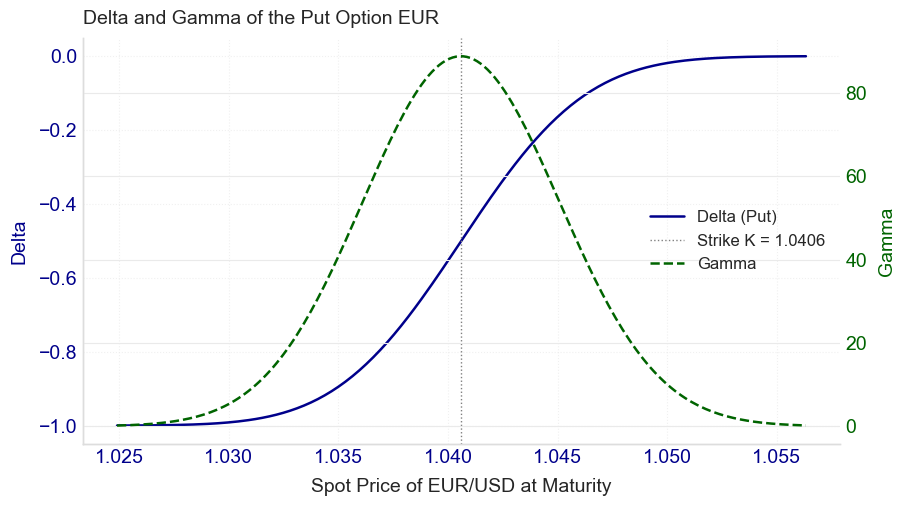

In [105]:
if greeks_calculated_successfully and option_type_input == 'put':
    print("\n" + "="*40 + "\nDelta & Gamma of the Put Option\n" + "="*40)

    delta_curve = []
    gamma_curve = []

    for s_val in spot_prices_at_maturity:
        if s_val <= 0 or strike_price <= 0:
            d1_greek = np.nan
        elif sigma * np.sqrt(time_to_maturity_years) == 0:
            d1_greek = np.inf if np.log(s_val / strike_price) > 0 else (-np.inf if np.log(s_val / strike_price) < 0 else 0)
        else:
            d1_greek = (np.log(s_val / strike_price) + (r_domestic - r_foreign + 0.5 * sigma**2) * time_to_maturity_years) / (sigma * np.sqrt(time_to_maturity_years))

        d2_greek = d1_greek - sigma * np.sqrt(time_to_maturity_years)
        nd1_greek = norm.pdf(d1_greek)

        delta_s = np.exp(-r_foreign * time_to_maturity_years) * (norm.cdf(d1_greek) - 1)
        delta_curve.append(delta_s)

        if s_val > 0 and sigma > 0 and time_to_maturity_years > 0:
            gamma_s = (nd1_greek * np.exp(-r_foreign * time_to_maturity_years)) / (s_val * sigma * np.sqrt(time_to_maturity_years))
        else:
            gamma_s = np.nan
        gamma_curve.append(gamma_s)

    fig, ax_delta = plt.subplots(figsize=(9, 5))
    color_delta = 'darkblue'
    color_gamma = 'darkgreen'

    ax_delta.plot(spot_prices_at_maturity, delta_curve, color=color_delta, linewidth=1.8, label="Delta (Put)")
    ax_delta.set_xlabel(f'Spot Price of {chosen_currency} at Maturity', fontsize=14)
    ax_delta.set_ylabel('Delta', color=color_delta, fontsize=14)
    ax_delta.tick_params(axis='both', labelsize=14, labelcolor=color_delta)
    ax_delta.grid(True, linestyle=':', alpha=0.7)

    ax_gamma = ax_delta.twinx()
    ax_gamma.plot(spot_prices_at_maturity, gamma_curve, color=color_gamma, linestyle='--', linewidth=1.8, label="Gamma")
    ax_gamma.set_ylabel('Gamma', color=color_gamma, fontsize=14)
    ax_gamma.tick_params(axis='y', labelsize=14, labelcolor=color_gamma)
    ax_gamma.spines["right"].set_position(("outward", 0))

    ax_delta.axvline(strike_price, color='grey', linestyle=':', linewidth=1.0, label=f'Strike K = {strike_price:.4f}')

    lines_delta, labels_delta = ax_delta.get_legend_handles_labels()
    lines_gamma, labels_gamma = ax_gamma.get_legend_handles_labels()
    ax_gamma.legend(lines_delta + lines_gamma, labels_delta + labels_gamma, loc='center right', fontsize=12)

    ax_delta.set_title(f'Delta and Gamma of the Put Option {base_ccy}', loc='left', pad=10, fontsize=14)

    plt.tight_layout(pad=0.5)
    plt.show()


Vega & Theta of the Put Option


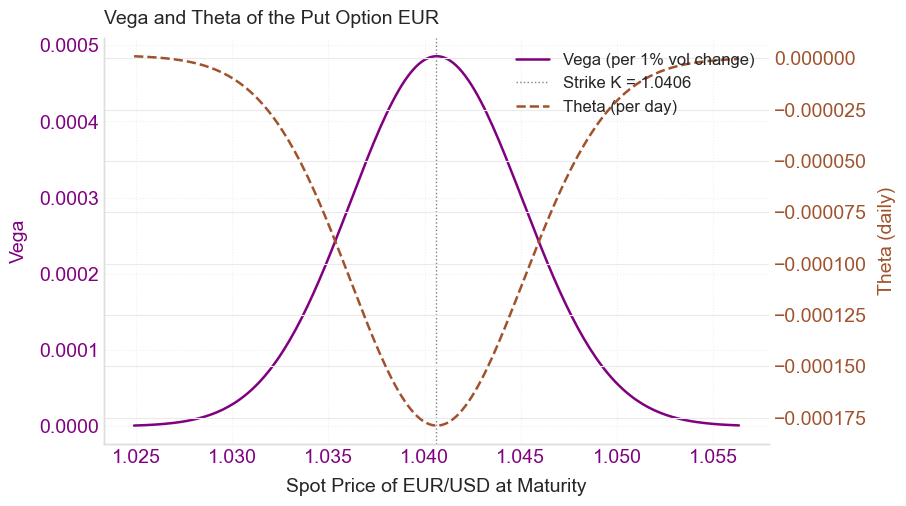

In [106]:
if greeks_calculated_successfully and option_type_input == 'put':
    print("\n" + "="*40 + "\nVega & Theta of the Put Option\n" + "="*40)

    vega_curve = []
    theta_curve_day = []

    for s_val in spot_prices_at_maturity:
        if s_val <= 0 or strike_price <= 0:
            d1_greek = np.nan
        elif sigma * np.sqrt(time_to_maturity_years) == 0:
            d1_greek = np.inf if np.log(s_val / strike_price) > 0 else (-np.inf if np.log(s_val / strike_price) < 0 else 0)
        else:
            d1_greek = (np.log(s_val / strike_price) + (r_domestic - r_foreign + 0.5 * sigma**2) * time_to_maturity_years) / (sigma * np.sqrt(time_to_maturity_years))

        d2_greek = d1_greek - sigma * np.sqrt(time_to_maturity_years)
        nd1_greek = norm.pdf(d1_greek)

        if s_val > 0 and time_to_maturity_years > 0:
            vega_raw = s_val * np.exp(-r_foreign * time_to_maturity_years) * nd1_greek * np.sqrt(time_to_maturity_years)
            vega_curve.append(vega_raw / 100.0)  
        else:
            vega_curve.append(np.nan)

        if time_to_maturity_years > 0:
            theta_yearly = - (s_val * nd1_greek * sigma * np.exp(-r_foreign * time_to_maturity_years)) / (2 * np.sqrt(time_to_maturity_years)) \
                           + r_domestic * strike_price * np.exp(-r_domestic * time_to_maturity_years) * norm.cdf(-d2_greek) \
                           - r_foreign * s_val * np.exp(-r_foreign * time_to_maturity_years) * norm.cdf(-d1_greek)
            theta_curve_day.append(theta_yearly / 365.0)
        else:
            theta_curve_day.append(np.nan)

    fig, ax_vega = plt.subplots(figsize=(9, 5))
    color_vega = 'purple'
    color_theta = 'sienna'

    ax_vega.plot(spot_prices_at_maturity, vega_curve, color=color_vega, linewidth=1.8, label="Vega (per 1% vol change)")
    ax_vega.set_xlabel(f'Spot Price of {chosen_currency} at Maturity', fontsize=14)
    ax_vega.set_ylabel('Vega', color=color_vega, fontsize=14)
    ax_vega.tick_params(axis='both', labelsize=14, labelcolor=color_vega)
    ax_vega.grid(True, linestyle=':', alpha=0.7)

    ax_theta = ax_vega.twinx()
    ax_theta.plot(spot_prices_at_maturity, theta_curve_day, color=color_theta, linestyle='--', linewidth=1.8, label="Theta (per day)")
    ax_theta.set_ylabel('Theta (daily)', color=color_theta, fontsize=14)
    ax_theta.tick_params(axis='y', labelsize=14, labelcolor=color_theta)
    ax_theta.spines["right"].set_position(("outward", 0))

    ax_vega.axvline(strike_price, color='grey', linestyle=':', linewidth=1.0, label=f'Strike K = {strike_price:.4f}')

    lines_vega, labels_vega = ax_vega.get_legend_handles_labels()
    lines_theta, labels_theta = ax_theta.get_legend_handles_labels()
    ax_theta.legend(lines_vega + lines_theta, labels_vega + labels_theta, loc='upper right', fontsize=12)

    ax_vega.set_title(f'Vega and Theta of the Put Option {base_ccy}', loc='left', pad=10, fontsize=14)

    plt.tight_layout(pad=0.5)
    plt.show()

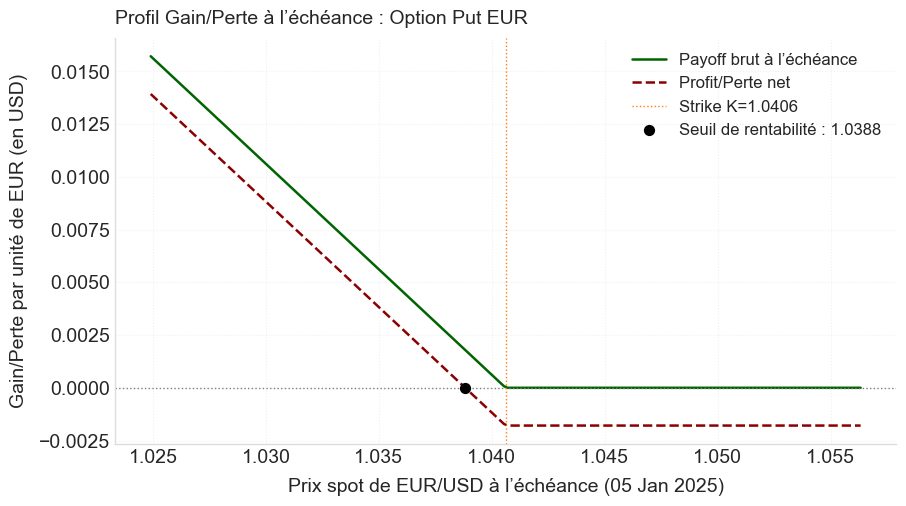

In [107]:
fig2, ax2 = plt.subplots(figsize=(9, 5))

if 'current_spot_price' not in globals() or pd.isna(current_spot_price):
    s0_for_payoff = strike_price
    warnings.warn("current_spot_price non trouvé pour le graphique de payoff, utilisation du strike.")
else:
    s0_for_payoff = current_spot_price

sigma_for_range = df_pricing['Volatilité_Prédite_Ann'].mean() / 100.0 \
                  if 'Volatilité_Prédite_Ann' in df_pricing and pd.notna(df_pricing['Volatilité_Prédite_Ann'].mean()) \
                  else 0.10

price_range_factor = 3.5 * sigma_for_range * np.sqrt(time_to_maturity_years if time_to_maturity_years > 0 else 1/252)
min_spot_payoff = strike_price * (1 - price_range_factor) if strike_price > 0 else s0_for_payoff * (1 - price_range_factor)
max_spot_payoff = strike_price * (1 + price_range_factor) if strike_price > 0 else s0_for_payoff * (1 + price_range_factor)
if min_spot_payoff <= 0:
    min_spot_payoff = 0.01

spot_prices_at_maturity = np.linspace(min_spot_payoff, max_spot_payoff, 200)

if option_type_input == 'call':
    payoff = np.maximum(spot_prices_at_maturity - strike_price, 0)
    profit_loss = payoff - option_premium_per_unit
    option_name_for_title = f"Call {base_ccy}"
elif option_type_input == 'put':
    payoff = np.maximum(strike_price - spot_prices_at_maturity, 0)
    profit_loss = payoff - option_premium_per_unit
    option_name_for_title = f"Put {base_ccy}"
else:
    raise ValueError("Type d'option non reconnu (call/put attendu).")

color_payoff = 'darkgreen'
color_profit_loss = 'darkred'
color_zero_line = 'grey'
color_strike = '#FF7F0E'

ax2.plot(spot_prices_at_maturity, payoff, color=color_payoff, linewidth=1.8, label='Payoff brut à l’échéance')
ax2.plot(spot_prices_at_maturity, profit_loss, color=color_profit_loss, linestyle='--', linewidth=1.8, label='Profit/Perte net')
ax2.axhline(0, color=color_zero_line, linestyle=':', linewidth=1.0)
ax2.axvline(strike_price, color=color_strike, linestyle=':', linewidth=1.0, label=f'Strike K={strike_price:.4f}')

if option_type_input == 'call' and pd.notna(option_premium_per_unit):
    break_even_call = strike_price + option_premium_per_unit
    ax2.scatter([break_even_call], [0], color='black', marker='o', s=50, zorder=5, label=f'Seuil de rentabilité : {break_even_call:.4f}')
elif option_type_input == 'put' and pd.notna(option_premium_per_unit):
    break_even_put = strike_price - option_premium_per_unit
    ax2.scatter([break_even_put], [0], color='black', marker='o', s=50, zorder=5, label=f'Seuil de rentabilité : {break_even_put:.4f}')

ax2.set_title(f'Profil Gain/Perte à l’échéance : Option {option_name_for_title}', loc='left', pad=10, fontsize=14)
ax2.set_xlabel(f'Prix spot de {chosen_currency} à l’échéance ({maturity_date.strftime("%d %b %Y")})', fontsize=14)
ax2.set_ylabel(f'Gain/Perte par unité de {base_ccy} (en {quote_ccy})', fontsize=14)
ax2.legend(loc='best', fontsize=12)
ax2.tick_params(axis='x', labelsize=14) 
ax2.tick_params(axis='y', labelsize=14)  
ax2.grid(True, linestyle=':', alpha=0.7)

plt.tight_layout(pad=0.5)
plt.show()

In [108]:
if greeks_calculated_successfully and option_type_input in ['call', 'put'] and pd.notna(delta_val):
    print("\n" + "="*40 + "\nIllustration du Delta Hedging pour Ibanfirst (Vendeur de l'Option)\n" + "="*40)

    position_option_ibanfirst = ""
    hedge_action_ibanfirst = ""
    delta_position_ibanfirst = 0.0
    quantite_a_couvrir_base_ccy = 0.0

    if option_type_input == 'call':
        delta_position_ibanfirst = -delta_val
        position_option_ibanfirst = f"Vente d'une Call {base_ccy}"
        quantite_a_couvrir_base_ccy = delta_val * notional_amount 
        hedge_action_ibanfirst = f"Acheter {quantite_a_couvrir_base_ccy:,.2f} {base_ccy}"

    elif option_type_input == 'put':
        delta_position_ibanfirst = -delta_val 
        position_option_ibanfirst = f"Vente d'une Put {base_ccy}"
        quantite_a_couvrir_base_ccy = -delta_val * notional_amount 
        hedge_action_ibanfirst = f"Vendre {quantite_a_couvrir_base_ccy:,.2f} {base_ccy}"

    print(f"Hypothèse: Ibanfirst a une position de '{position_option_ibanfirst}'.")
    print(f"  - Notionnel de l'option : {notional_amount:,.2f} {base_ccy}")
    print(f"  - Delta de l'option (du point de vue de l'acheteur) : {delta_val:.4f}")
    print(f"  - Delta de la position d'Ibanfirst (vendeur) : {delta_position_ibanfirst:.4f}")
    print(f"Pour être Delta-Neutre au prix spot S0={current_spot_price:.4f} {chosen_currency} et K={strike_price:.4f} {chosen_currency}:")
    print(f"  - Action de couverture initiale d'Ibanfirst : {hedge_action_ibanfirst}")
    petit_changement_spot_abs = current_spot_price * 0.001 

    for direction_changement in [1, -1]:
        changement_spot = petit_changement_spot_abs * direction_changement
        nouveau_spot = current_spot_price + changement_spot

        print(f"\n  --- Simulation si {chosen_currency} passe de {current_spot_price:.4f} à {nouveau_spot:.4f} (chg: {changement_spot:.4f}) ---")

        gain_perte_hedge = 0
        if quantite_a_couvrir_base_ccy != 0 : 
            if (option_type_input == 'call' and hedge_action_ibanfirst.startswith("Acheter")) or \
               (option_type_input == 'put' and hedge_action_ibanfirst.startswith("Vendre")): 
                montant_hedge_signe = -delta_position_ibanfirst * notional_amount
                gain_perte_hedge = montant_hedge_signe * changement_spot 
                print(f"    Gain/Perte sur la couverture spot ({montant_hedge_signe:,.2f} {base_ccy}) : {gain_perte_hedge:,.2f} {quote_ccy}")


        changement_valeur_option_vendue = - (delta_val * changement_spot * notional_amount)
        print(f"    Changement de valeur approx. de l'option vendue : {changement_valeur_option_vendue:,.2f} {quote_ccy}")

        changement_net_position_ibanfirst = gain_perte_hedge + changement_valeur_option_vendue
        print(f"    --------------------------------------------------------------------")
        print(f"    Changement Net Estimé de la position Delta-Hedgée d'Ibanfirst : {changement_net_position_ibanfirst:,.2f} {quote_ccy}")

        if abs(changement_net_position_ibanfirst) > 1e-9 : 
            print(f"    (Ce changement net non nul est principalement dû à l'effet Gamma et au fait que Delta change.)")
            if sigma > 0 and time_to_maturity_years > 0 :
                d1_new_num = np.log(nouveau_spot / strike_price) + (r_domestic - r_foreign + 0.5 * sigma**2) * time_to_maturity_years
                d1_new_den = sigma * np.sqrt(time_to_maturity_years)
                if d1_new_den == 0: d1_new = np.inf if d1_new_num > 0 else (-np.inf if d1_new_num < 0 else 0)
                else: d1_new = d1_new_num / d1_new_den
                d2_new = d1_new - sigma * np.sqrt(time_to_maturity_years)

                nouveau_prix_option_unitaire = np.nan
                if option_type_input == 'call':
                    nouveau_prix_option_unitaire = nouveau_spot * np.exp(-r_foreign * time_to_maturity_years) * norm.cdf(d1_new) - \
                                                   strike_price * np.exp(-r_domestic * time_to_maturity_years) * norm.cdf(d2_new)
                elif option_type_input == 'put':
                    nouveau_prix_option_unitaire = strike_price * np.exp(-r_domestic * time_to_maturity_years) * norm.cdf(-d2_new) - \
                                                   nouveau_spot * np.exp(-r_foreign * time_to_maturity_years) * norm.cdf(-d1_new)

                if pd.notna(nouveau_prix_option_unitaire) and pd.notna(option_premium_per_unit):
                    changement_reel_valeur_option = (nouveau_prix_option_unitaire - option_premium_per_unit) * notional_amount
                    perte_gain_sur_option_vendue_ibanfirst = -changement_reel_valeur_option

                    changement_net_precis = gain_perte_hedge + perte_gain_sur_option_vendue_ibanfirst
                    print(f"    Changement de valeur réel de l'option vendue (re-pricing) : {perte_gain_sur_option_vendue_ibanfirst:,.2f} {quote_ccy}")
                    print(f"    Changement Net PRÉCIS de la position Delta-Hedgée d'Ibanfirst : {changement_net_precis:,.2f} {quote_ccy}")
                    print(f"    (La différence avec l'estimation par Delta est due au Gamma et autres effets non linéaires.)")


    print("\nNote Importante sur le Delta Hedging Dynamique :")
    print("  - Le Delta d'une option change lorsque le prix du sous-jacent, la volatilité, ou le temps à l'échéance changent.")
    print("  - Par conséquent, une couverture Delta-Neutre doit être réajustée dynamiquement (fréquemment) pour rester efficace.")
    print("  - Le Gamma mesure la vitesse à laquelle le Delta change, indiquant la fréquence de réajustement nécessaire.")
    print("  - Cette illustration montre l'impact d'un petit mouvement de prix sur une position initialement Delta-Neutre. "
          "Le résultat net n'est pas exactement zéro à cause du Gamma (l'option n'est pas un instrument linéaire).")

else:
    print("\nCalcul des Grecques ou des paramètres d'option non effectué ou invalide. "
          "Illustration du Delta Hedging impossible.")


Illustration du Delta Hedging pour Ibanfirst (Vendeur de l'Option)
Hypothèse: Ibanfirst a une position de 'Vente d'une Put EUR'.
  - Notionnel de l'option : 100,000.00 EUR
  - Delta de l'option (du point de vue de l'acheteur) : -0.4989
  - Delta de la position d'Ibanfirst (vendeur) : 0.4989
Pour être Delta-Neutre au prix spot S0=1.0406 EUR/USD et K=1.0406 EUR/USD:
  - Action de couverture initiale d'Ibanfirst : Vendre 49,893.41 EUR

  --- Simulation si EUR/USD passe de 1.0406 à 1.0417 (chg: 0.0010) ---
    Gain/Perte sur la couverture spot (-49,893.41 EUR) : -51.92 USD
    Changement de valeur approx. de l'option vendue : 51.92 USD
    --------------------------------------------------------------------
    Changement Net Estimé de la position Delta-Hedgée d'Ibanfirst : -0.00 USD

  --- Simulation si EUR/USD passe de 1.0406 à 1.0396 (chg: -0.0010) ---
    Gain/Perte sur la couverture spot (-49,893.41 EUR) : 51.92 USD
    Changement de valeur approx. de l'option vendue : -51.92 USD
   


Visualisation du Delta Hedging


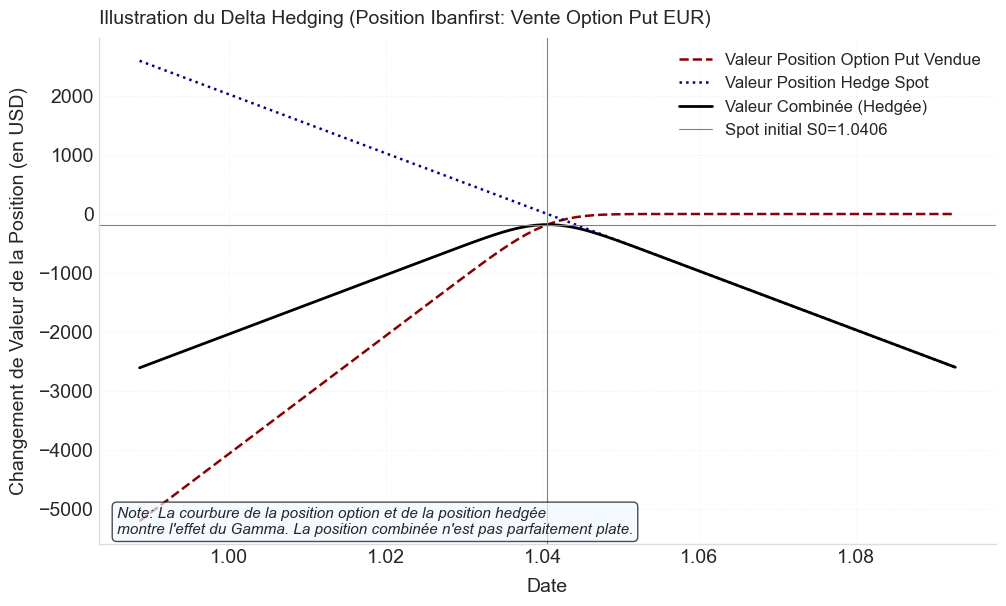

In [110]:
spot_range_factor = 0.05 

if greeks_calculated_successfully and option_type_input in ['call', 'put'] and pd.notna(delta_val):
    print("\n" + "="*40 + "\nVisualisation du Delta Hedging\n" + "="*40)


    min_spot_hedge_plot = current_spot_price * (1 - spot_range_factor)
    max_spot_hedge_plot = current_spot_price * (1 + spot_range_factor)
    if min_spot_hedge_plot <=0 : min_spot_hedge_plot = 0.01

    spot_prices_for_hedge_plot = np.linspace(min_spot_hedge_plot, max_spot_hedge_plot, 100)

    initial_premium_received = option_premium_per_unit * notional_amount 

    value_of_sold_option = []
    delta_of_sold_option_curve = []

    for s_val_plot in spot_prices_for_hedge_plot:

        if s_val_plot <= 0 or strike_price <=0 or sigma <= 0 or time_to_maturity_years <=0:
            d1_plot, d2_plot = np.nan, np.nan
            current_option_price_unit = np.nan
            delta_sold_opt = np.nan
        else:
            d1_plot_num = np.log(s_val_plot / strike_price) + (r_domestic - r_foreign + 0.5 * sigma**2) * time_to_maturity_years
            d1_plot_den = sigma * np.sqrt(time_to_maturity_years)
            if d1_plot_den == 0: d1_plot = np.inf if d1_plot_num > 0 else (-np.inf if d1_plot_num < 0 else 0)
            else: d1_plot = d1_plot_num / d1_plot_den
            d2_plot = d1_plot - sigma * np.sqrt(time_to_maturity_years)

            if option_type_input == 'call':
                current_option_price_unit = s_val_plot * np.exp(-r_foreign * time_to_maturity_years) * norm.cdf(d1_plot) - \
                                            strike_price * np.exp(-r_domestic * time_to_maturity_years) * norm.cdf(d2_plot)
                delta_sold_opt = - (np.exp(-r_foreign * time_to_maturity_years) * norm.cdf(d1_plot)) # Delta de la short call
            else: 
                current_option_price_unit = strike_price * np.exp(-r_domestic * time_to_maturity_years) * norm.cdf(-d2_plot) - \
                                            s_val_plot * np.exp(-r_foreign * time_to_maturity_years) * norm.cdf(-d1_plot)
                delta_sold_opt = - (np.exp(-r_foreign * time_to_maturity_years) * (norm.cdf(d1_plot) - 1)) # Delta de la short put

        value_of_sold_option.append(-current_option_price_unit * notional_amount if pd.notna(current_option_price_unit) else np.nan)
        delta_of_sold_option_curve.append(delta_sold_opt)

    amount_of_base_ccy_hedged = 0
    if option_type_input == 'call': 
        amount_of_base_ccy_hedged = delta_val * notional_amount
    else: 
        amount_of_base_ccy_hedged = delta_val * notional_amount
    
    position_hedge_base_ccy = delta_val * notional_amount


    value_of_hedge_position = (spot_prices_for_hedge_plot - current_spot_price) * position_hedge_base_ccy

    value_combined_position = np.array(value_of_sold_option) + np.array(value_of_hedge_position)

    fig_dh, ax_dh = plt.subplots(figsize=(10, 6))

    color_option_pos = 'darkred'
    color_hedge_pos = 'darkblue'
    color_combined_pos = 'black'

    ax_dh.plot(spot_prices_for_hedge_plot, value_of_sold_option, color=color_option_pos, linestyle='--', linewidth=1.8, label=f'Valeur Position Option {option_type_input.capitalize()} Vendue')
    ax_dh.plot(spot_prices_for_hedge_plot, value_of_hedge_position, color=color_hedge_pos, linestyle=':', linewidth=1.8, label=f'Valeur Position Hedge Spot')
    ax_dh.plot(spot_prices_for_hedge_plot, value_combined_position, color=color_combined_pos, linestyle='-', linewidth=2.0, label='Valeur Combinée (Hedgée)')

    ax_dh.axvline(current_spot_price, color='grey', linestyle='-', linewidth=0.8, label=f'Spot initial S0={current_spot_price:.4f}')
    ax_dh.axhline(value_combined_position[np.argmin(np.abs(spot_prices_for_hedge_plot - current_spot_price))],
                  color='grey', linestyle='-', linewidth=0.8) 

    ax_dh.set_title(f'Illustration du Delta Hedging (Position Ibanfirst: Vente Option {option_type_input.capitalize()} {base_ccy})', loc='left', pad=10, fontsize=14)
    ax_dh.set_xlabel(f'Prix Spot de {chosen_currency}',fontsize=14)
    ax_dh.set_ylabel(f'Changement de Valeur de la Position (en {quote_ccy})',fontsize=14)
    ax_dh.legend(loc='best')
    ax_dh.grid(True, linestyle=':', alpha=0.6)

    ax_dh.text(0.02, 0.02, "Note: La courbure de la position option et de la position hedgée\n"
                           "montre l'effet du Gamma. La position combinée n'est pas parfaitement plate.",
               transform=ax_dh.transAxes, fontsize=11, style='italic',
               bbox=dict(boxstyle='round,pad=0.3', fc='aliceblue', alpha=0.7))
    plt.setp(ax_dh.get_xticklabels(), ha="center", rotation_mode="anchor")
    ax_dh.tick_params(axis='x', labelsize=14)  
    ax_dh.tick_params(axis='y', labelsize=14)  
    ax_dh.set_xlabel('Date', fontsize=14)
    ax_dh.legend(loc='best', fontsize=12)
    plt.tight_layout(pad=0.5)
    plt.show()

else:
    print("\nCalcul des Grecques ou des paramètres d'option non effectué ou invalide. "
          "Graphique du Delta Hedging non généré.")